In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import warnings
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# try:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#   # Invalid device or cannot modify virtual devices once initialized.
#   pass

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
DATA_PATH_INTERPRO = os.getenv('DATA_PATH_INTERPRO')
print(DATA_PATH)
print(DATA_PATH_INTERPRO)

# Choose subontology (CCO, MFO or BPO)
SO = 'MFO'

2023-08-14 19:58:44.926077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 19:58:45.563659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/cafa-5-protein-function-prediction
/mnt/e/ML/output


2023-08-14 19:58:46.708256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-14 19:58:46.826206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-14 19:58:46.826549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)


In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfSO = df.loc[df["aspect"]==SO]
uniqueTerms = dfSO["term"].unique()
termsArr = list(dfSO["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfSO.shape)
df=dfSO

df.set_index("EntryID", inplace=True)

(670114, 3)


In [5]:
testID = df.index.to_list()[0]

In [6]:
dfGo = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfGo = dfGo.loc[dfGo["aspect"]==SO]

dfGo.set_index("term", inplace=True)

In [ ]:
dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

soEntries = dfAll.loc[dfAll["aspect"]==SO]
soEntryIds = soEntries["EntryID"].unique()

print(soEntryIds)

dfAll.set_index("EntryID", inplace=True)

Every protein should have at least one GO in every ontology.

There are several sequences that don't have all GOs assigned, so we'll exclude them.

allMfoIds = set(list(dfAll.loc[dfAll["aspect"]=="MFO"].index))
allCcoIds = set(list(dfAll.loc[dfAll["aspect"]=="CCO"].index))
allBpoIds = set(list(dfAll.loc[dfAll["aspect"]=="BPO"].index))
cleanedIds = list(set.intersection(*[allMfoIds, allCcoIds, allBpoIds]))
print(len(ids))
len(cleanedIds)

cleanedSequences=[]
for cleanedId in tqdm(cleanedIds):
    idxInSeqList = ids.index(cleanedId)
    cleanedSequences.append(sequences[idxInSeqList])

len(cleanedSequences)
assert(len(cleanedSequences)==len(cleanedIds))

## GO analysis

In [7]:
item_counts = df["term"].value_counts()

In [8]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [9]:
if SO=="CCO":
    GOTarget=name_to_id["cellular_component"]
elif SO=="MFO":
    GOTarget=name_to_id["molecular_function"]
elif SO=="BPO":
    GOTarget = name_to_id["biological_process"]

def getAllAncestors(go):
    try:
        paths = networkx.all_simple_paths(
            graph,
            source=go,
            target=GOTarget
        )
    except:
        return []
    gos = []
    for path in paths:
        for node in path:
            gos.append(node)
    return list(set(gos))


## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

Extract label weights from IA

In [10]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()



notFound=0
for go in item_counts.index.to_list():
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeights.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))

Not found GOs: 0 (set to 0)


In [11]:
topGOs=item_counts.index.to_list()

threshold=0
labelWeights=np.array(labelWeights)
selection = labelWeights>threshold
topGOs=np.array(topGOs)[selection]

if os.path.exists(os.path.join(DATA_PATH, "GODataSizes_"+SO+".npy")):
    print("Loading presaved data")
    GODataSizes = np.load(os.path.join(DATA_PATH, "GODataSizes_"+SO+".npy"))
else:
    GODataSizes= [dfGo.loc[g].size for g in topGOs]
    np.save(os.path.join(DATA_PATH, "GODataSizes_"+SO), GODataSizes)


Loading presaved data


In [12]:
#At least 10 samples
print(np.count_nonzero(np.array(GODataSizes)>5))
GODataSizes= np.array(GODataSizes)
GOsWithSufficientData = topGOs[GODataSizes>5]


4282


In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

print(len(topGOs))
mlb = MultiLabelBinarizer()
mlb.fit([GOsWithSufficientData])

dftest=df.loc[testID]
indices = dftest["term"].to_numpy()
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

with open(os.path.join(DATA_PATH,'MLB_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlb, f)

6574
['GO:0003674' 'GO:0003953' 'GO:0016787' 'GO:0016799' 'GO:0016798'
 'GO:0003824']
[[0 0 0 ... 0 0 0]]
4282


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['GO:0003674'] will be ignored
  warnings.warn(


In [14]:
labelWeightsCorr=[]
occurenceScores=[]
occurenceDict={}
termHist= df["term"].value_counts()
maxGoCount = termHist.max()

notFound=0
for go in mlb.classes_:
    if go in allIndices:
        occurenceScore = (maxGoCount-termHist[go])/maxGoCount
        occurenceScores.append(occurenceScore)
        occurenceDict[go] = termHist[go]
        labelWeightsCorr.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeightsCorr.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))
labelWeightsCorr=np.array(labelWeightsCorr)

Not found GOs: 0 (set to 0)


In [15]:
ancestorDict = {}
goIdxTensors=[]

for goIdx, go in tqdm(enumerate(mlb.classes_)):
    ancestors = getAllAncestors(go)
    ancestors.append(go)
    with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        fullPath = mlb.transform([ancestors])[0]
    fullPathTensor = tf.constant(fullPath)
    goIdxTensor = tf.constant(goIdx)
    goIdxTensors.append(goIdxTensor)
    ancestorDict[goIdxTensor.ref()] = fullPathTensor
    
# AncestorDictTensor = tf.lookup.KeyValueTensorInitializer(tf.constant(list(ancestorDict.keys())),tf.constant(np.array(list(ancestorDict.values()))))
# AncestorDictLookup = tf.lookup.StaticHashTable(AncestorDictTensor,default_value=-1)

0it [00:00, ?it/s]

2023-08-14 19:59:02.545684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-14 19:59:02.546120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-14 19:59:02.546433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-14 19:59:03.130601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-14 19:59:03.130986: I tensorflow/compile

In [16]:
ancestorDict[goIdxTensors[12].ref()]

<tf.Tensor: shape=(4282,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [17]:
mlb.inverse_transform(np.array([ancestorDict[goIdxTensors[12].ref()]]))

[('GO:0000064',
  'GO:0005215',
  'GO:0005342',
  'GO:0008514',
  'GO:0015171',
  'GO:0015179',
  'GO:0022857',
  'GO:0046943')]

In [18]:
np.array(list(ancestorDict.values())).shape

(4282, 4282)

## Amino acids encoding

In [19]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## T5 Embeds

In [20]:
train_embeddings = np.load(os.path.join(DATA_PATH, "t5/train_embeds.npy"))

column_num = train_embeddings.shape[1]
t5df = pd.DataFrame(
    train_embeddings, columns=["Column_" + str(i) for i in range(1, column_num + 1)]
)
t5Dimension = t5df.shape[1]

train_protein_ids = np.load(os.path.join(DATA_PATH, "t5/train_ids.npy"))
t5df["ids"] = train_protein_ids
print(train_protein_ids.shape)
print(t5df.shape)
t5df.set_index("ids", inplace=True)
t5df.head()

(142246,)
(142246, 1025)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
ids,,,,,,,,,,,,,,,,,,,,,
P20536,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
O73864,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
O95231,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
A0A0B4J1F4,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
P54366,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


## ESM2 Embeds

In [21]:
train_esm2_embeddings = np.load(os.path.join(DATA_PATH, "esm2/train_embeds_esm2_t36_3B_UR50D.npy"))

column_num = train_esm2_embeddings.shape[1]
esm2df = pd.DataFrame(
    train_esm2_embeddings, columns=["Column_" + str(i) for i in range(1, column_num + 1)]
)
esm2Dimension = esm2df.shape[1]

train_protein_ids_esm2 = np.load(os.path.join(DATA_PATH, "esm2/train_ids_esm2_t36_3B_UR50D.npy"))
esm2df["ids"] = train_protein_ids_esm2
print(train_protein_ids_esm2.shape)
print(esm2df.shape)
esm2df.set_index("ids", inplace=True)
esm2df.head()

(142246,)
(142246, 2561)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_2551,Column_2552,Column_2553,Column_2554,Column_2555,Column_2556,Column_2557,Column_2558,Column_2559,Column_2560
ids,,,,,,,,,,,,,,,,,,,,,
P20536,-0.006932,0.007936,0.002732,0.008902,-0.041230,0.011959,0.007449,0.088468,0.027504,-0.058287,...,0.019839,0.074110,0.014544,0.045950,0.042379,-0.000532,-0.056042,0.025682,-0.028790,-0.009521
O73864,-0.008232,-0.074880,-0.008287,-0.082649,0.004363,0.042135,-0.046334,0.083998,0.012416,-0.045745,...,0.095438,-0.049323,0.120818,0.013928,0.107403,0.024934,-0.041349,0.063856,-0.062438,-0.051984
O95231,0.079354,-0.034172,0.028020,0.038319,-0.006604,-0.037847,-0.050455,0.013767,0.007118,-0.000116,...,0.056358,-0.052374,0.018207,0.041541,0.038180,-0.037411,0.011259,0.008821,-0.161301,-0.003935
A0A0B4J1F4,-0.028833,-0.021754,-0.007713,-0.067681,-0.081395,0.005322,-0.091768,0.146422,0.042343,-0.081021,...,0.225756,-0.050869,-0.024418,-0.106160,0.075731,-0.020250,-0.056059,0.057696,-0.156398,-0.133214
P54366,0.082937,0.028213,0.051966,0.024844,-0.001088,0.028256,-0.014439,0.074051,-0.005088,-0.073510,...,0.015249,-0.083649,-0.009176,0.111403,0.016327,-0.033296,0.003102,-0.014339,-0.105367,0.042954


## Interpro Data

In [22]:
import xml.etree.ElementTree as ET
root = ET.parse(os.path.join(DATA_PATH, "interpro.xml")).getroot()

In [23]:
possibleDomains=[]
allIPTypes=[]
for child in root:
    if "type" in child.attrib:
        allIPTypes.append(child.attrib["type"])
        if(child.attrib["type"]=="Domain" or child.attrib["type"]=="Repeat" or child.attrib["type"]=="Family" or child.attrib["type"]=="Homologous_superfamily"):
            # print(child.tag, child.attrib)
            possibleDomains.append(child.attrib["id"])

set(allIPTypes)

{'Active_site',
 'Binding_site',
 'Conserved_site',
 'Domain',
 'Family',
 'Homologous_superfamily',
 'PTM',
 'Repeat'}

In [24]:
len(possibleDomains)

mlbInterPro = MultiLabelBinarizer()
mlbInterPro.fit([possibleDomains])


print(mlbInterPro.transform([["IPR000001"]]))
print(len(mlbInterPro.classes_))

with open(os.path.join(DATA_PATH,'MLB_InterPro_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlbInterPro, f)

[[1 0 0 ... 0 0 0]]
38293


In [25]:
import json

allInterproData =[]

for root,dirs,files in os.walk(os.path.join(DATA_PATH_INTERPRO, "train")):
    for f in files:
        if f.endswith(".json"):
            print("Processing ", f)
            with open(os.path.join(root, f)) as inputFile:
                iprData = json.load(inputFile)
            allInterproData=[*allInterproData, *iprData["results"]]

Processing  train_sequences0.fasta.json
Processing  train_sequences1.fasta.json
Processing  train_sequences2.fasta.json
Processing  train_sequences3.fasta.json
Processing  train_sequences4_1.fasta.json
Processing  train_sequences4_2.fasta.json
Processing  train_sequences4_3.fasta.json
Processing  train_sequences4_4.fasta.json
Processing  train_sequences5_1.fasta.json
Processing  train_sequences5_2.fasta.json
Processing  train_sequences5_3.fasta.json


In [26]:
len(allInterproData)

141650

In [27]:

iprIds = {}


for entry in tqdm(allInterproData):
    entryId = entry["xref"][0]["id"]
    matches=[]
    for match in entry["matches"]:
        sigEntry = match["signature"]["entry"]
        if(sigEntry):
            type = sigEntry["type"]
            if type=="DOMAIN" or type=="REPEAT" or type=="FAMILY" or type=="HOMOLOGOUS_SUPERFAMILY":
                iprId = match["signature"]["entry"]["accession"]
                matches.append(iprId)
    iprIds[entryId] = matches

  0%|          | 0/141650 [00:00<?, ?it/s]

In [28]:
testInput = mlbInterPro.transform([iprIds["Q55G04"]])
np.count_nonzero(testInput)

4

## Physiochemical Properties

In [29]:

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import MutableSeq, Seq
from tqdm.notebook import tqdm
import pickle

if os.path.exists(os.path.join(DATA_PATH, "PCDict"+".pkl")):
    print("Loading presaved data")
    with open(os.path.join(DATA_PATH, "PCDict"+".pkl"), 'rb') as f:
        PCDict = pickle.load(f)
else:
    PCDict = {}

    for i,seq in enumerate(tqdm(sequences)):

        index = ids[i]
        
        X =ProteinAnalysis(seq)

        if "X" in seq or "U" in seq or "O" in seq or "B" in seq or "Z" in seq:
            cleanedSeq = seq.replace("X", "A")
            cleanedSeq = cleanedSeq.replace("U", "A")
            cleanedSeq = cleanedSeq.replace("O", "A")
            cleanedSeq = cleanedSeq.replace("B", "A")
            cleanedSeq = cleanedSeq.replace("Z", "A")
            XClean =ProteinAnalysis(cleanedSeq)
            flex = XClean.flexibility()
            molW = XClean.molecular_weight()
            instabIdx = XClean.instability_index()
            gravy = XClean.gravy()
        else:
            flex= X.flexibility()
            molW = X.molecular_weight()
            instabIdx = X.instability_index()
            gravy = X.gravy()

        if len(flex)>10:
            idx = np.round(np.linspace(0, len(flex) - 1, 10)).astype(int)
            flex = np.array(flex)[idx]
        elif len(flex)<10:
            flex = np.pad(flex, (0,10-len(flex)))

        protS= X.protein_scale(aa_dict,100)
        if len(protS)>10:
            idx = np.round(np.linspace(0, len(protS) - 1, 10)).astype(int)
            protS = np.array(protS)[idx]
        elif len(protS)<10:
            protS = np.pad(protS, (0,10-len(protS)))

        #Adding all the physiochemical properties (N = 53)
        PCDict[index] = [ molW, X.aromaticity(), instabIdx, *list(X.get_amino_acids_percent().values()),
                *flex, gravy, *protS, X.isoelectric_point(), X.charge_at_pH(7), X.charge_at_pH(3), X.charge_at_pH(10), *X.molar_extinction_coefficient(),
                *X.secondary_structure_fraction()]
        
    with open(os.path.join(DATA_PATH, "PCDict"+".pkl"), 'wb') as f:
        pickle.dump(PCDict, f)
    


Loading presaved data


## Build Dataset

In [33]:
from itertools import product
from tqdm import tqdm
import os


TRAIN_VAL_SPLIT = 0.7
k = 3
PCLength = len(PCDict[ids[0]])

allAA = list(aa_dict.keys())
allAA.sort()
allCombinations= list(product(*(allAA for i in range(k))))
allCombinations=np.array([''.join(el) for el in allCombinations])

positionDict = dict(zip(allCombinations, np.arange(0,allCombinations.size).T))

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(cleanedSequences, cleanedIds))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)


#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator():
  for idxTrain,seqTrain in enumerate(trainSeq):
      entryIdTrain = trainIds[idxTrain]
      labelDataTrain = df.loc[entryIdTrain]
      # indices = labelData["termToken"].to_numpy()
      indicesTrain = labelDataTrain["term"].to_numpy()
 

      with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        yTrain = mlb.transform([indicesTrain])

      kmersTrain = [seqTrain[j:j+k] if j < len(seqTrain)-(k-1) else 0 for j,el in enumerate(seqTrain)]
      kmersTrain = kmersTrain[0:-(k-1)]
      kmersTrain = [str(el) for el in kmersTrain]
      valuesTrain, countsTrain = np.unique(kmersTrain, return_counts=True)
      freqVectorTrain=np.zeros(allCombinations.shape)
      for lTrain,vTrain in enumerate(valuesTrain):
          freqVectorTrain[positionDict[vTrain]] = countsTrain[lTrain]

      with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        if entryIdTrain in iprIds:
          xTrain  = mlbInterPro.transform([iprIds[entryIdTrain]])
        else:
          xTrain  = mlbInterPro.transform([[]])
      

      #Adding all the physiochemical properties (N = 53)
      pcPropsTrain = PCDict[entryIdTrain]

      t5data = t5df.loc[entryIdTrain].to_numpy()

      esm2Data = esm2df.loc[entryIdTrain].to_numpy()
     
      yield (np.array(pcPropsTrain),xTrain[0],freqVectorTrain, t5data, esm2Data, yTrain[0])


def generatorVal():
  for idxVal,seqVal in enumerate(valSeq):
      entryIdVal = valIds[idxVal]
      labelDataVal = df.loc[entryIdVal]
      # indices = labelData["termToken"].to_numpy()
      indicesVal = labelDataVal["term"].to_numpy()
 

      with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        yVal = mlb.transform([indicesVal])

      kmersVal = [seqVal[jVal:jVal+k] if jVal < len(seqVal)-(k-1) else 0 for jVal,elVal in enumerate(seqVal)]
      kmersVal = kmersVal[0:-(k-1)]
      kmersVal = [str(el) for el in kmersVal]
      valuesVal, countsVal = np.unique(kmersVal, return_counts=True)
      freqVectorVal=np.zeros(allCombinations.shape)
      for lVal,vVal in enumerate(valuesVal):
          freqVectorVal[positionDict[vVal]] = countsVal[lVal]

      with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        if entryIdVal in iprIds:
          xVal  = mlbInterPro.transform([iprIds[entryIdVal]])
        else:
          xVal  = mlbInterPro.transform([[]])

      #Adding all the physiochemical properties (N = 53)
      pcPropsVal = PCDict[entryIdVal]

      t5dataVal = t5df.loc[entryIdVal].to_numpy()

      esm2DataVal = esm2df.loc[entryIdVal].to_numpy()
      
      yield (np.array(pcPropsVal),xVal[0],freqVectorVal, t5dataVal, esm2DataVal, yVal[0])

30232


In [34]:
g = generatorVal()
test = next(g)
print("PC Input: \n{}\n{}\n".format(test[0].shape, test[0][0:10]))
print("Interpro Input: \n{}\n{}\n".format(test[1].shape, test[1][0:10]))
print("kMer Input: \n{}\n{}\n".format(test[2].shape, test[2][0:20]))
print("t5 Input: \n{}\n{}\n".format(test[3].shape, test[3][0:20]))
print("esm2 Input: \n{}\n{}\n".format(test[3].shape, test[4][0:20]))
print("Targets: \n{}\n{}\n".format(test[4].shape, test[5][0:20]))
print("The first sample has {} Interpro input classes".format(np.count_nonzero(test[1])))
print("The first sample has {} kMer input classes".format(np.count_nonzero(test[2])))
print("The first sample has {} output classes".format(np.count_nonzero(test[5])))

PC Input: 
(53,)
[1.06189589e+05 9.13921360e-02 4.92421148e+01 6.80127524e-02
 3.50690755e-02 3.93198725e-02 6.26992561e-02 3.18809777e-02
 4.88841658e-02 2.12539851e-02]

Interpro Input: 
(38293,)
[1 0 0 0 0 0 0 0 0 0]

kMer Input: 
(15625,)
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

t5 Input: 
(1024,)
[ 1.77426673e-02  6.19425513e-02  1.74952894e-02  1.95267648e-02
 -3.25413309e-02  5.74584305e-03 -2.16382071e-02 -4.09549326e-02
  3.34014297e-02  4.56633934e-05  4.48733522e-03  1.90920904e-02
  9.18693561e-03 -7.44962739e-03  2.62813866e-02  4.12542559e-03
 -2.53835395e-02  1.20967478e-02  1.13738468e-02 -2.80377902e-02]

esm2 Input: 
(1024,)
[ 0.00591983 -0.06119964 -0.03214392 -0.05490642 -0.01714402 -0.00676042
 -0.03208588  0.10209425  0.03970791  0.02067089 -0.01764517  0.00446736
  0.05763815  0.07710359 -0.02148874 -0.07691865 -0.10479486  0.00029762
  0.01032666  0.01914726]

Targets: 
(2560,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

The first sample has

## Tensorflow Classification

In [35]:
#Input =  53 physiochemical properties, Interpro Domains, kMers

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(PCLength,), dtype=tf.float32),                 #Physiochemical properties
    tf.TensorSpec(shape=(len(mlbInterPro.classes_),), dtype=tf.int32),  #Interpro Classes
    tf.TensorSpec(shape=(allCombinations.shape[0],), dtype=tf.int32),   #kMers
    tf.TensorSpec(shape=(t5Dimension,), dtype=tf.float32),              #t5
    tf.TensorSpec(shape=(esm2Dimension,), dtype=tf.float32),            #esm2
    tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))         #GO Classes (Output)

datasetVal = tf.data.Dataset.from_generator(generatorVal, output_signature=(
    tf.TensorSpec(shape=(PCLength,), dtype=tf.float32),                 #Physiochemical properties
    tf.TensorSpec(shape=(len(mlbInterPro.classes_),), dtype=tf.int32),  #Interpro Classes
    tf.TensorSpec(shape=(allCombinations.shape[0],), dtype=tf.int32),   #kMers
    tf.TensorSpec(shape=(t5Dimension,), dtype=tf.float32),              #t5
    tf.TensorSpec(shape=(esm2Dimension,), dtype=tf.float32),            #esm2
    tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))         #GO Classes (Output)
print(list(datasetVal.take(1)))

[(<tf.Tensor: shape=(53,), dtype=float32, numpy=
array([ 1.06189586e+05,  9.13921371e-02,  4.92421150e+01,  6.80127516e-02,
        3.50690745e-02,  3.93198729e-02,  6.26992583e-02,  3.18809785e-02,
        4.88841645e-02,  2.12539844e-02,  5.41976616e-02,  4.67587672e-02,
        8.92667398e-02,  2.33793836e-02,  4.88841645e-02,  6.80127516e-02,
        3.82571742e-02,  6.26992583e-02,  7.97024444e-02,  5.31349629e-02,
        6.90754503e-02,  1.38150901e-02,  4.56960686e-02,  1.02278566e+00,
        9.90000010e-01,  1.03778577e+00,  9.73749995e-01,  9.63666677e-01,
        1.00789285e+00,  9.85678554e-01,  9.82678592e-01,  1.04136908e+00,
        1.04044044e+00, -2.78746009e-01,  1.09207916e+01,  9.61386108e+00,
        1.10792084e+01,  1.04554453e+01,  1.07326736e+01,  1.17425747e+01,
        1.08118811e+01,  9.53465366e+00,  1.05049505e+01,  1.13267326e+01,
        8.22437668e+00,  8.03688812e+00,  1.18709625e+02, -6.80810394e+01,
        1.35570000e+05,  1.37570000e+05,  3.0393198

In [36]:
%load_ext tensorboard


Model: "DenseMultiModal5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 53)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 38293)]              0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 15625)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1024)]               0         []                            
                                                                                   

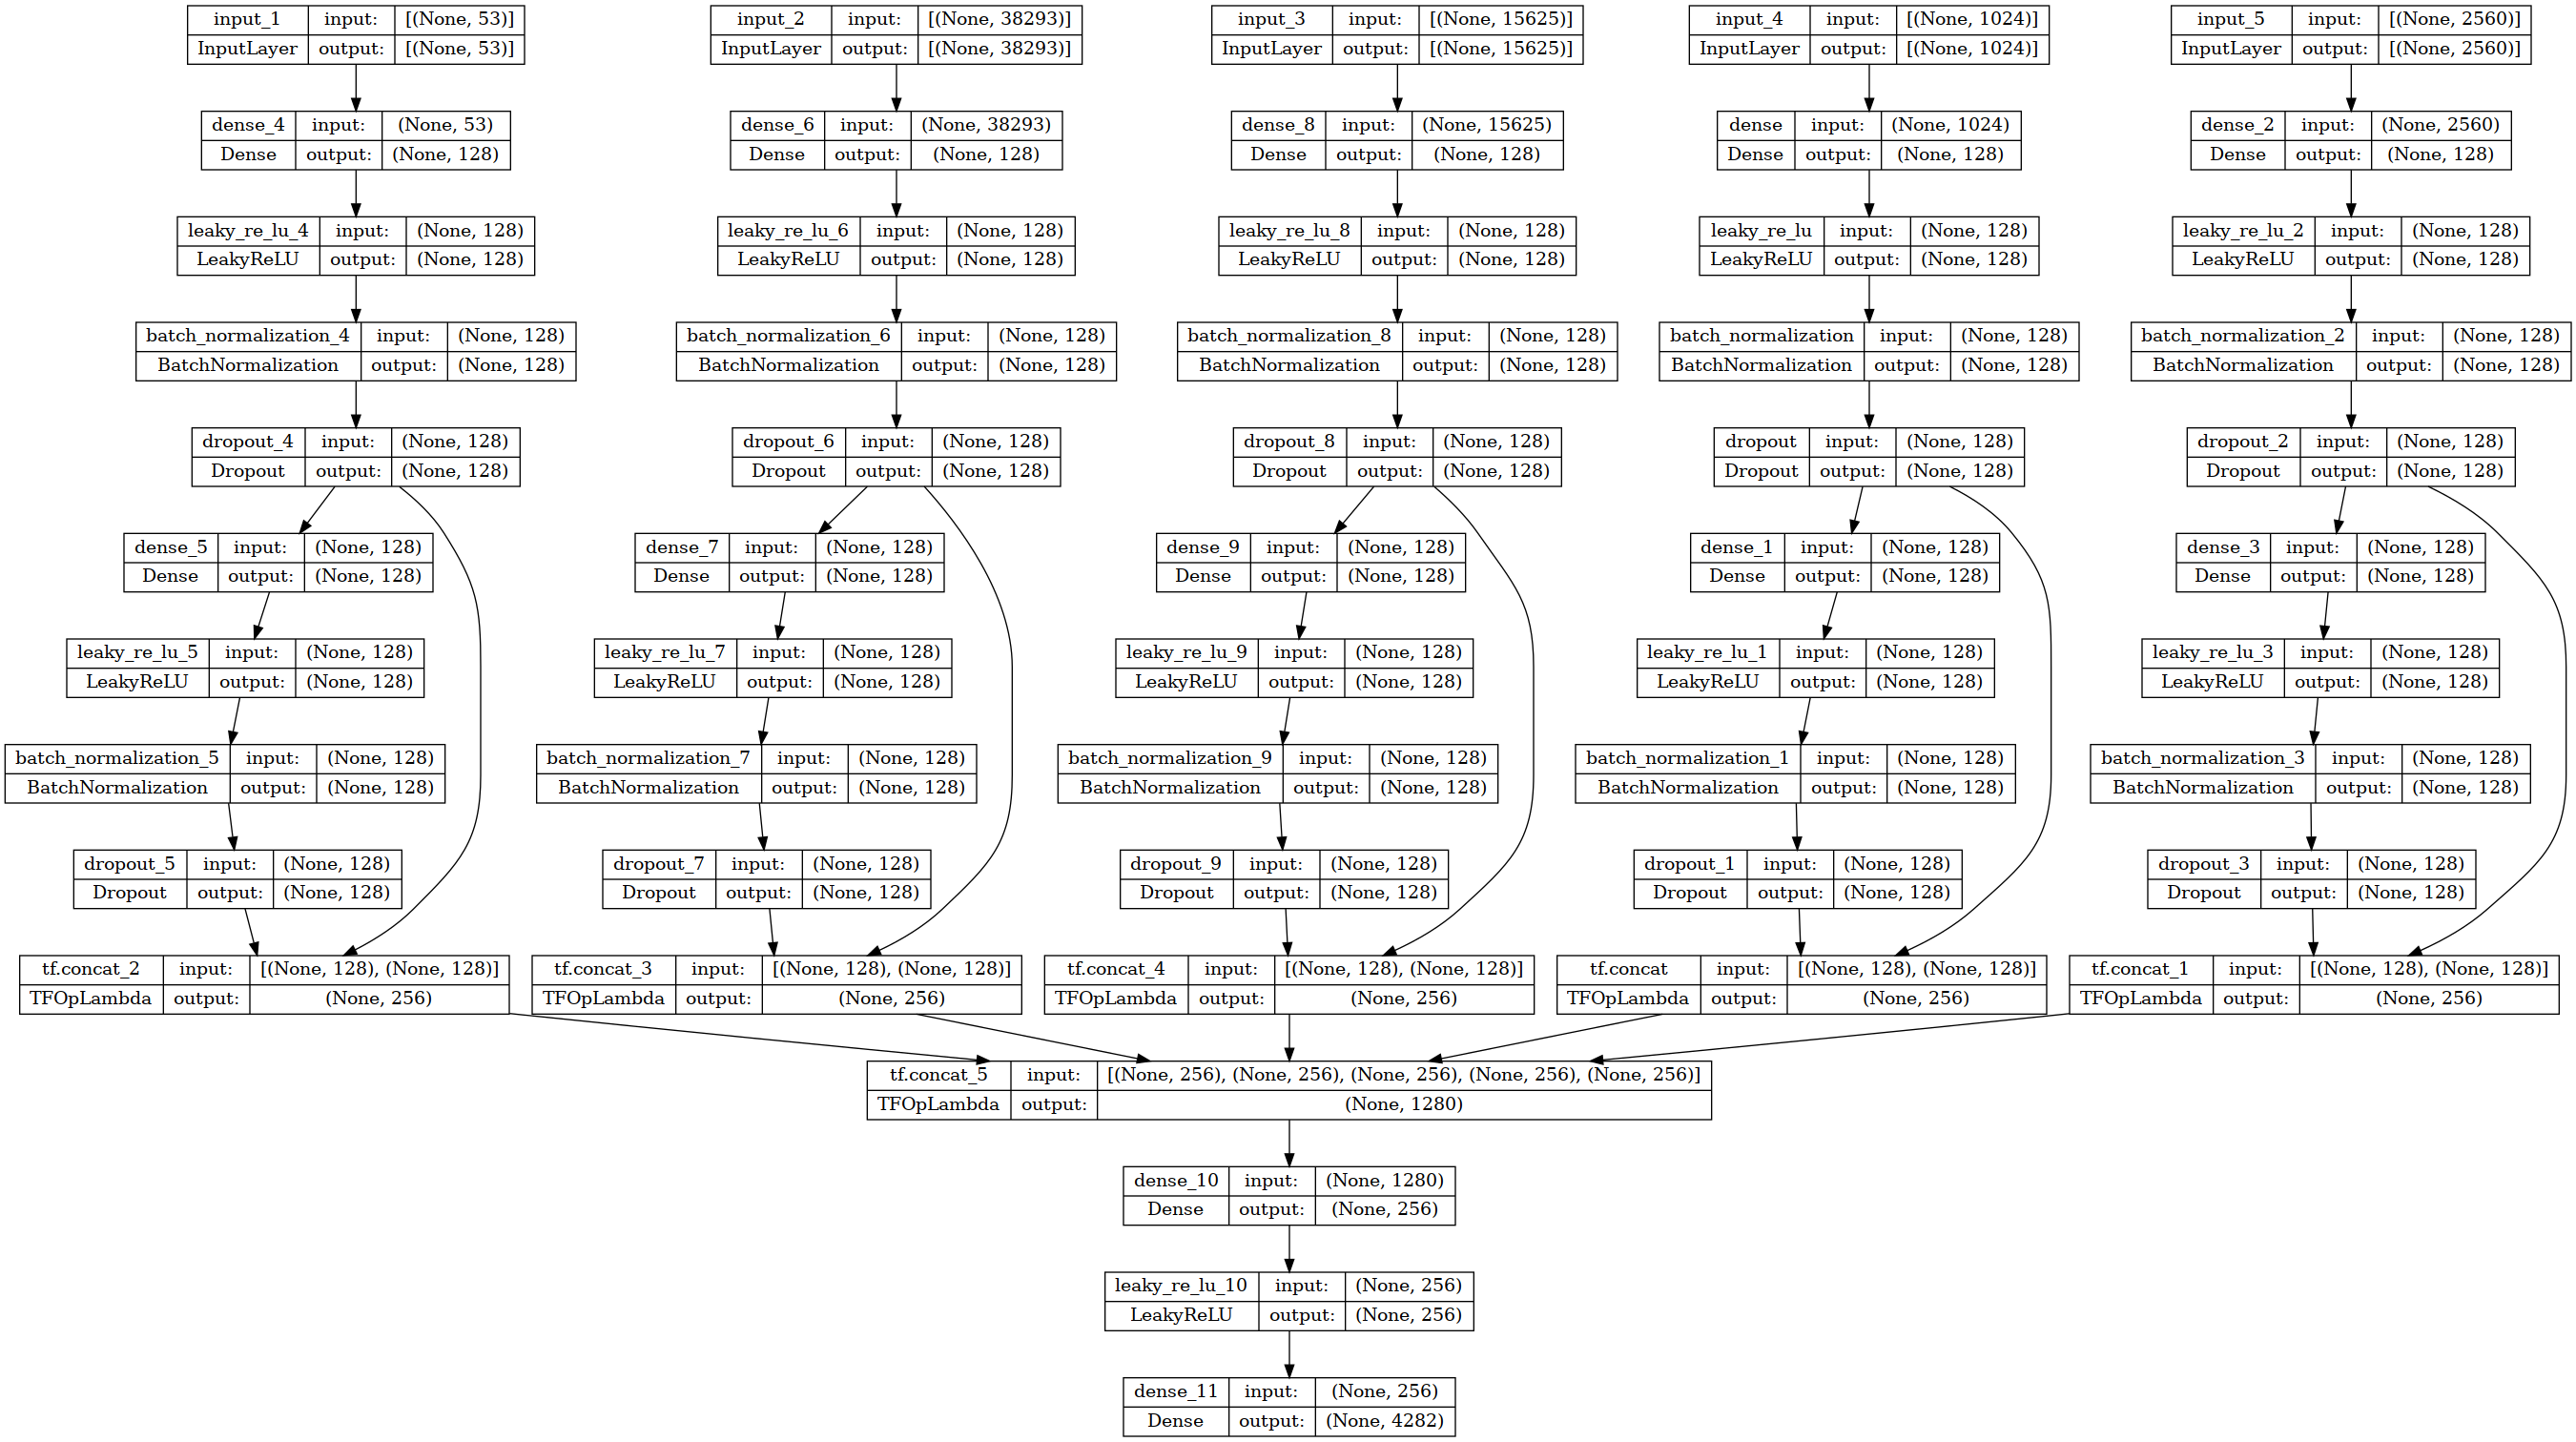

In [37]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=10

def createModel():
    inputsPC = tf.keras.Input(shape=(PCLength,))
    inputsIP = tf.keras.Input(shape=(len(mlbInterPro.classes_),))
    inputsKmer = tf.keras.Input(shape=(allCombinations.shape[0],))
    inputsT5 = tf.keras.Input(shape=(t5Dimension,))
    inputsEsm2 = tf.keras.Input(shape=(esm2Dimension,))
    
    # xT5 = layers.Attention()([inputsT5,inputsT5])
    xT5 = layers.Dense(128)(inputsT5)
    xT5 = layers.LeakyReLU()(xT5)
    xT5 = layers.BatchNormalization()(xT5)
    xT5Res = layers.Dropout(0.1)(xT5)
    xT5 = layers.Dense(128)(xT5Res)
    xT5 = layers.LeakyReLU()(xT5)
    xT5 = layers.BatchNormalization()(xT5)
    xT5 = layers.Dropout(0.1)(xT5)
    xT5 = tf.concat([xT5,xT5Res],1)

    xEsm2 = layers.Dense(128)(inputsEsm2)
    xEsm2 = layers.LeakyReLU()(xEsm2)
    xEsm2 = layers.BatchNormalization()(xEsm2)
    xEsm2Res = layers.Dropout(0.1)(xEsm2)
    xEsm2 = layers.Dense(128)(xEsm2Res)
    xEsm2 = layers.LeakyReLU()(xEsm2)
    xEsm2 = layers.BatchNormalization()(xEsm2)
    xEsm2 = layers.Dropout(0.1)(xEsm2)
    xEsm2 = tf.concat([xEsm2,xEsm2Res],1)

    # xPC = layers.Attention()([inputsPC,inputsPC])
    xPC = layers.Dense(128)(inputsPC)
    xPC = layers.LeakyReLU()(xPC)
    xPC = layers.BatchNormalization()(xPC)
    xPCRes = layers.Dropout(0.1)(xPC)
    xPC = layers.Dense(128)(xPCRes)
    xPC = layers.LeakyReLU()(xPC)
    xPC = layers.BatchNormalization()(xPC)
    xPC = layers.Dropout(0.1)(xPC)
    xPC = tf.concat([xPC,xPCRes],1)

    # xIP = layers.Attention()([inputsIP,inputsIP])
    xIP = layers.Dense(128)(inputsIP)
    xIP = layers.LeakyReLU()(xIP)
    xIP = layers.BatchNormalization()(xIP)
    xIPRes = layers.Dropout(0.1)(xIP)
    xIP = layers.Dense(128)(xIPRes)
    xIP = layers.LeakyReLU()(xIP)
    xIP = layers.BatchNormalization()(xIP)
    xIP = layers.Dropout(0.1)(xIP)
    xIP = tf.concat([xIP,xIPRes],1)

    # xKmer = layers.Attention()([inputsKmer,inputsKmer])
    xKmer = layers.Dense(128)(inputsKmer)
    xKmer = layers.LeakyReLU()(xKmer)
    xKmer = layers.BatchNormalization()(xKmer)
    xKmerRes = layers.Dropout(0.1)(xKmer)
    xKmer = layers.Dense(128)(xKmerRes)
    xKmer = layers.LeakyReLU()(xKmer)
    xKmer = layers.BatchNormalization()(xKmer)
    xKmer = layers.Dropout(0.1)(xKmer)
    xKmer = tf.concat([xKmer,xKmerRes],1)

    concat = tf.concat([xPC,xIP,xKmer,xT5, xEsm2],1)

    x = layers.Dense(256)(concat)
    x = layers.LeakyReLU()(x)

    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)

    return tf.keras.Model(inputs=[inputsPC, inputsIP, inputsKmer, inputsT5, inputsEsm2], outputs=outputs, name="DenseMultiModal5")

model = createModel()

model.summary()

dot_img_file = './model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [38]:
import matplotlib.pyplot as plt
#Learning rate schedule
initial_learning_rate = 0.001
decaySteps=5000
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps=decaySteps,
                                                                t_mul=1.7, m_mul=0.7)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps=decaySteps, alpha=0.01)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,decay_steps=decaySteps,decay_rate=0.9,staircase=False)
# step = np.linspace(0,decaySteps*3)
# lr = lr_schedule(step)
# plt.figure(figsize = (8,6))
# # plt.yscale("log")
# plt.plot(step, lr)
# plt.ylim([0,max(plt.ylim())])
# plt.xlabel('step')
# _ = plt.ylabel('Learning Rate')

In [39]:
from utils import *

In [40]:

BATCH_SIZE=64
LOG_INTERVAL=20
epochs = 100
saveModel=True


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"_"+SO
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4)

# Instantiate a loss function.
# loss_fn = tf.keras.losses.BinaryCrossentropy()
# loss_fn = WeightedBinaryCE(np.ones(len(mlb.classes_)))
# loss_fn = WeightedBinaryCE(labelWeightsCorr)
# loss_fn = WeightedComboLoss(labelWeightsCorr, alpha=0.5, beta=0.5, labelSmoothing=0.05)
loss_fn = WeightedComboLoss(labelWeightsCorr/np.max(labelWeightsCorr)+occurenceScores, alpha=0.5, beta=0.5, labelSmoothing=0.1)
# loss_fn = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma=2)

train_acc_metric = WeightedAccuracy(classWeights=labelWeightsCorr)
train_f1_metric = WeightedF1(classWeights=labelWeightsCorr, threshold=0.5)
train_prec = WeightedPrecision(classWeights=labelWeightsCorr)
train_rec = WeightedRecall(classWeights=labelWeightsCorr)

val_acc_metric = WeightedAccuracy(classWeights=labelWeightsCorr)
val_f1_metric = WeightedF1(classWeights=labelWeightsCorr, threshold=0.5)
val_prec = WeightedPrecision(classWeights=labelWeightsCorr)
val_rec = WeightedRecall(classWeights=labelWeightsCorr)

batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

@tf.function()
def trainStep(x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:
        probs = model(x_batch_train, training=True) 

        #Add all ancestor GOs based on the predictions
        # probsNew = tf.TensorArray(tf.float32, size=probs.shape[0])
        # for probsIdx in range(probs.shape[0]):
        #     predictedIdx = tf.where(tf.math.greater(probs[probsIdx], 0.5))
        #     predictedProbs = tf.gather_nd(probs[probsIdx], predictedIdx)
        #     # print(predictedIdx.numpy(), predictedProbs.numpy())
        #     vectToAdd = tf.TensorArray(tf.float32, size=predictedIdx.shape[0])
        #     for addingIdx, predIdx in enumerate(predictedIdx):
        #         ancestorsArr = ancestorDict[goIdxTensors[predIdx.numpy()[0]].ref()]
        #         vectToAdd.write(addingIdx, tf.math.multiply(tf.cast(ancestorsArr, tf.float32), predictedProbs[addingIdx])).mark_used()
        #     vectToAddTensors = vectToAdd.stack()
            # print(vectToAddTensors.numpy())
            # probsNew.write(probsIdx, tf.math.reduce_max(vectToAddTensors,axis=0)).mark_used()
        # probsNewTensor = probsNew.stack()
        
        loss_value = loss_fn(y_batch_train, probs)

    grads = tape.gradient(loss_value, model.trainable_weights)

    #Gradient clipping
    # grads = [tf.clip_by_norm(g, 2.0) for g in grads]

    train_acc_metric.update_state(y_batch_train, probs)
    train_f1_metric.update_state(y_batch_train, probs)
    train_prec.update_state(y_batch_train, probs)
    train_rec.update_state(y_batch_train, probs)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 
    return loss_value

@tf.function()
def valStep(x_batch_val, y_batch_val):
    valProbs = model(x_batch_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_batch_val, valProbs)
    val_f1_metric.update_state(y_batch_val, valProbs)
    val_prec.update_state(y_batch_val, valProbs)
    val_rec.update_state(y_batch_val, valProbs)

maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_trainPC, x_batch_trainIP, x_batch_trainKmer, x_batch_trainT5, x_batch_trainEsm2, y_batch_train) in enumerate(batchedDataset):
        loss_value =trainStep((x_batch_trainPC, x_batch_trainIP, x_batch_trainKmer, x_batch_trainT5, x_batch_trainEsm2),y_batch_train)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.5f}, Accuracy: {:.5f}, F1: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, lr: {:.5f}'
            print(template.format(epoch+1, step,loss_value.numpy(), 
                                    train_acc_metric.result(),train_f1_metric.result(),
                                    train_prec.result(), train_rec.result(), optimizer.learning_rate.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_value, step=maxStep*epoch+step)
                tf.summary.scalar('accuracy', train_acc_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('f1', train_f1_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('prec', train_prec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('rec', train_rec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('learning rate', optimizer.learning_rate.numpy(), step=maxStep*epoch+step)
                summary_writer.flush()

    
    train_acc_metric.reset_states()
    train_f1_metric.reset_states()
    train_prec.reset_states()
    train_rec.reset_states()

    maxStep=step

    print("Epoch finished. Start validation")
    for x_batch_valPC, x_batch_valIP, x_batch_valKmer, x_batch_valT5, x_batch_valEsm2, y_batch_val in batchedDatasetVal:
        valStep((x_batch_valPC, x_batch_valIP, x_batch_valKmer, x_batch_valT5, x_batch_valEsm2), y_batch_val)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_f1 = val_f1_metric.result()
    val_f1_metric.reset_states()
    val_precision = val_prec.result()
    val_prec.reset_states()
    val_recall = val_rec.result()
    val_rec.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Validation f1: %.4f" % (float(val_f1),))
    print("Validation precision: %.4f" % (float(val_precision),))
    print("Validation recall: %.4f" % (float(val_recall),))
    with summary_writer.as_default():
        tf.summary.scalar('valAcc', float(val_acc), step=epoch)
        tf.summary.scalar('valF1', float(val_f1), step=epoch)
        tf.summary.scalar('valPrecision', float(val_precision), step=epoch)
        tf.summary.scalar('valRecall', float(val_recall), step=epoch)
        summary_writer.flush()
    if saveModel:
      model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valF1Score{:.4f}".format(epoch, float(val_f1))))




Start of epoch 1


2023-08-14 20:00:24.281452: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f476816a510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-14 20:00:24.281490: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-08-14 20:00:24.303395: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-14 20:00:24.467830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-14 20:00:24.642471: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/Step 0, Loss: 0.00063, Accuracy: 0.50537, F1: 0.0019, Prec: 0.5111, Rec: 0.0010, lr: 0.00030
Epoch 1/Step 20, Loss: -0.00058, Accuracy: 0.55261, F1: 0.0028, Prec: 0.6675, Rec: 0.0014, lr: 0.00030
Epoch 1/Step 40, Loss: -0.00129, Accuracy: 0.62977, F1: 0.0040, Prec: 0.7208, Rec: 0.0020, lr: 0.00030
Epoch 1/Step 60, Loss: -0.00443, Accuracy: 0.71482, F1: 0.0083, Prec: 0.7397, Rec: 0.0042, lr: 0.00030
Epoch 1/Step 80, Loss: -0.03191, Accuracy: 0.77903, F1: 0.0205, Prec: 0.7423, Rec: 0.0106, lr: 0.00030
Epoch 1/Step 100, Loss: -0.08296, Accuracy: 0.82082, F1: 0.0374, Prec: 0.7290, Rec: 0.0200, lr: 0.00030
Epoch 1/Step 120, Loss: -0.10494, Accuracy: 0.84961, F1: 0.0568, Prec: 0.7052, Rec: 0.0314, lr: 0.00030
Epoch 1/Step 140, Loss: -0.15282, Accuracy: 0.87050, F1: 0.0788, Prec: 0.6776, Rec: 0.0460, lr: 0.00030
Epoch 1/Step 160, Loss: -0.17979, Accuracy: 0.88632, F1: 0.1005, Prec: 0.6482, Rec: 0.0625, lr: 0.00030
Epoch 1/Step 180, Loss: -0.16593, Accuracy: 0.89869, F1: 0.1215, Prec: 

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_0_valF1Score0.4663/assets



Start of epoch 2
Epoch 2/Step 0, Loss: -0.25545, Accuracy: 0.99910, F1: 0.5000, Prec: 0.3933, Rec: 0.6863, lr: 0.00030
Epoch 2/Step 20, Loss: -0.26853, Accuracy: 0.99911, F1: 0.5001, Prec: 0.3789, Rec: 0.7400, lr: 0.00030
Epoch 2/Step 40, Loss: -0.26759, Accuracy: 0.99911, F1: 0.5041, Prec: 0.3849, Rec: 0.7348, lr: 0.00030
Epoch 2/Step 60, Loss: -0.24814, Accuracy: 0.99911, F1: 0.5029, Prec: 0.3846, Rec: 0.7317, lr: 0.00030
Epoch 2/Step 80, Loss: -0.23816, Accuracy: 0.99911, F1: 0.5033, Prec: 0.3860, Rec: 0.7292, lr: 0.00030
Epoch 2/Step 100, Loss: -0.29971, Accuracy: 0.99911, F1: 0.5056, Prec: 0.3887, Rec: 0.7297, lr: 0.00030
Epoch 2/Step 120, Loss: -0.22863, Accuracy: 0.99912, F1: 0.5070, Prec: 0.3904, Rec: 0.7289, lr: 0.00030
Epoch 2/Step 140, Loss: -0.25200, Accuracy: 0.99912, F1: 0.5103, Prec: 0.3939, Rec: 0.7307, lr: 0.00030
Epoch 2/Step 160, Loss: -0.26224, Accuracy: 0.99912, F1: 0.5108, Prec: 0.3946, Rec: 0.7300, lr: 0.00030
Epoch 2/Step 180, Loss: -0.24234, Accuracy: 0.99912,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_1_valF1Score0.5240/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_1_valF1Score0.5240/assets



Start of epoch 3
Epoch 3/Step 0, Loss: -0.26734, Accuracy: 0.99911, F1: 0.5161, Prec: 0.4041, Rec: 0.7139, lr: 0.00030
Epoch 3/Step 20, Loss: -0.28154, Accuracy: 0.99916, F1: 0.5350, Prec: 0.4093, Rec: 0.7769, lr: 0.00030
Epoch 3/Step 40, Loss: -0.28812, Accuracy: 0.99915, F1: 0.5392, Prec: 0.4132, Rec: 0.7791, lr: 0.00030
Epoch 3/Step 60, Loss: -0.25898, Accuracy: 0.99916, F1: 0.5376, Prec: 0.4119, Rec: 0.7786, lr: 0.00030
Epoch 3/Step 80, Loss: -0.24958, Accuracy: 0.99915, F1: 0.5360, Prec: 0.4106, Rec: 0.7769, lr: 0.00030
Epoch 3/Step 100, Loss: -0.31111, Accuracy: 0.99916, F1: 0.5374, Prec: 0.4129, Rec: 0.7750, lr: 0.00030
Epoch 3/Step 120, Loss: -0.24632, Accuracy: 0.99916, F1: 0.5381, Prec: 0.4143, Rec: 0.7727, lr: 0.00030
Epoch 3/Step 140, Loss: -0.26298, Accuracy: 0.99916, F1: 0.5397, Prec: 0.4157, Rec: 0.7749, lr: 0.00030
Epoch 3/Step 160, Loss: -0.27475, Accuracy: 0.99916, F1: 0.5391, Prec: 0.4152, Rec: 0.7738, lr: 0.00030
Epoch 3/Step 180, Loss: -0.25971, Accuracy: 0.99916,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_2_valF1Score0.5281/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_2_valF1Score0.5281/assets



Start of epoch 4
Epoch 4/Step 0, Loss: -0.27705, Accuracy: 0.99915, F1: 0.5409, Prec: 0.4144, Rec: 0.7783, lr: 0.00030
Epoch 4/Step 20, Loss: -0.28512, Accuracy: 0.99918, F1: 0.5452, Prec: 0.4153, Rec: 0.7982, lr: 0.00030
Epoch 4/Step 40, Loss: -0.29571, Accuracy: 0.99917, F1: 0.5498, Prec: 0.4208, Rec: 0.7965, lr: 0.00030
Epoch 4/Step 60, Loss: -0.26603, Accuracy: 0.99918, F1: 0.5476, Prec: 0.4190, Rec: 0.7956, lr: 0.00030
Epoch 4/Step 80, Loss: -0.26186, Accuracy: 0.99917, F1: 0.5474, Prec: 0.4189, Rec: 0.7951, lr: 0.00030
Epoch 4/Step 100, Loss: -0.31544, Accuracy: 0.99918, F1: 0.5491, Prec: 0.4214, Rec: 0.7937, lr: 0.00030
Epoch 4/Step 120, Loss: -0.25457, Accuracy: 0.99918, F1: 0.5493, Prec: 0.4220, Rec: 0.7923, lr: 0.00030
Epoch 4/Step 140, Loss: -0.27035, Accuracy: 0.99919, F1: 0.5514, Prec: 0.4240, Rec: 0.7941, lr: 0.00030
Epoch 4/Step 160, Loss: -0.28164, Accuracy: 0.99918, F1: 0.5508, Prec: 0.4231, Rec: 0.7942, lr: 0.00030
Epoch 4/Step 180, Loss: -0.26171, Accuracy: 0.99918,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_3_valF1Score0.5320/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_3_valF1Score0.5320/assets



Start of epoch 5
Epoch 5/Step 0, Loss: -0.28423, Accuracy: 0.99918, F1: 0.5459, Prec: 0.4154, Rec: 0.7958, lr: 0.00030
Epoch 5/Step 20, Loss: -0.28775, Accuracy: 0.99920, F1: 0.5522, Prec: 0.4188, Rec: 0.8165, lr: 0.00030
Epoch 5/Step 40, Loss: -0.29998, Accuracy: 0.99919, F1: 0.5583, Prec: 0.4256, Rec: 0.8153, lr: 0.00030
Epoch 5/Step 60, Loss: -0.26397, Accuracy: 0.99919, F1: 0.5564, Prec: 0.4240, Rec: 0.8142, lr: 0.00030
Epoch 5/Step 80, Loss: -0.26890, Accuracy: 0.99919, F1: 0.5572, Prec: 0.4253, Rec: 0.8133, lr: 0.00030
Epoch 5/Step 100, Loss: -0.32435, Accuracy: 0.99919, F1: 0.5592, Prec: 0.4285, Rec: 0.8106, lr: 0.00030
Epoch 5/Step 120, Loss: -0.26825, Accuracy: 0.99920, F1: 0.5598, Prec: 0.4295, Rec: 0.8095, lr: 0.00030
Epoch 5/Step 140, Loss: -0.27418, Accuracy: 0.99920, F1: 0.5619, Prec: 0.4316, Rec: 0.8107, lr: 0.00030
Epoch 5/Step 160, Loss: -0.28378, Accuracy: 0.99920, F1: 0.5614, Prec: 0.4312, Rec: 0.8098, lr: 0.00030
Epoch 5/Step 180, Loss: -0.27110, Accuracy: 0.99920,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_4_valF1Score0.5383/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_4_valF1Score0.5383/assets



Start of epoch 6
Epoch 6/Step 0, Loss: -0.29542, Accuracy: 0.99922, F1: 0.5629, Prec: 0.4295, Rec: 0.8164, lr: 0.00030
Epoch 6/Step 20, Loss: -0.29619, Accuracy: 0.99921, F1: 0.5618, Prec: 0.4291, Rec: 0.8190, lr: 0.00030
Epoch 6/Step 40, Loss: -0.30840, Accuracy: 0.99920, F1: 0.5666, Prec: 0.4344, Rec: 0.8183, lr: 0.00030
Epoch 6/Step 60, Loss: -0.27583, Accuracy: 0.99920, F1: 0.5649, Prec: 0.4328, Rec: 0.8179, lr: 0.00030
Epoch 6/Step 80, Loss: -0.27623, Accuracy: 0.99920, F1: 0.5656, Prec: 0.4334, Rec: 0.8192, lr: 0.00030
Epoch 6/Step 100, Loss: -0.32793, Accuracy: 0.99921, F1: 0.5677, Prec: 0.4360, Rec: 0.8188, lr: 0.00030
Epoch 6/Step 120, Loss: -0.28408, Accuracy: 0.99921, F1: 0.5682, Prec: 0.4371, Rec: 0.8174, lr: 0.00030
Epoch 6/Step 140, Loss: -0.28003, Accuracy: 0.99921, F1: 0.5706, Prec: 0.4397, Rec: 0.8180, lr: 0.00030
Epoch 6/Step 160, Loss: -0.29405, Accuracy: 0.99921, F1: 0.5703, Prec: 0.4393, Rec: 0.8180, lr: 0.00030
Epoch 6/Step 180, Loss: -0.27280, Accuracy: 0.99921,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_5_valF1Score0.5426/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_5_valF1Score0.5426/assets



Start of epoch 7
Epoch 7/Step 0, Loss: -0.30302, Accuracy: 0.99923, F1: 0.5679, Prec: 0.4357, Rec: 0.8154, lr: 0.00030
Epoch 7/Step 20, Loss: -0.30327, Accuracy: 0.99922, F1: 0.5688, Prec: 0.4362, Rec: 0.8231, lr: 0.00030
Epoch 7/Step 40, Loss: -0.31449, Accuracy: 0.99922, F1: 0.5786, Prec: 0.4461, Rec: 0.8269, lr: 0.00030
Epoch 7/Step 60, Loss: -0.28041, Accuracy: 0.99922, F1: 0.5764, Prec: 0.4440, Rec: 0.8262, lr: 0.00030
Epoch 7/Step 80, Loss: -0.27939, Accuracy: 0.99921, F1: 0.5764, Prec: 0.4440, Rec: 0.8268, lr: 0.00030
Epoch 7/Step 100, Loss: -0.32845, Accuracy: 0.99922, F1: 0.5777, Prec: 0.4460, Rec: 0.8255, lr: 0.00030
Epoch 7/Step 120, Loss: -0.29019, Accuracy: 0.99923, F1: 0.5781, Prec: 0.4466, Rec: 0.8250, lr: 0.00030
Epoch 7/Step 140, Loss: -0.28567, Accuracy: 0.99923, F1: 0.5803, Prec: 0.4490, Rec: 0.8260, lr: 0.00030
Epoch 7/Step 160, Loss: -0.30791, Accuracy: 0.99923, F1: 0.5800, Prec: 0.4485, Rec: 0.8262, lr: 0.00030
Epoch 7/Step 180, Loss: -0.27589, Accuracy: 0.99922,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_6_valF1Score0.5433/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_6_valF1Score0.5433/assets



Start of epoch 8
Epoch 8/Step 0, Loss: -0.30331, Accuracy: 0.99922, F1: 0.5726, Prec: 0.4395, Rec: 0.8212, lr: 0.00030
Epoch 8/Step 20, Loss: -0.30066, Accuracy: 0.99923, F1: 0.5757, Prec: 0.4423, Rec: 0.8305, lr: 0.00030
Epoch 8/Step 40, Loss: -0.31700, Accuracy: 0.99923, F1: 0.5855, Prec: 0.4515, Rec: 0.8369, lr: 0.00030
Epoch 8/Step 60, Loss: -0.28912, Accuracy: 0.99923, F1: 0.5825, Prec: 0.4485, Rec: 0.8358, lr: 0.00030
Epoch 8/Step 80, Loss: -0.28298, Accuracy: 0.99923, F1: 0.5823, Prec: 0.4488, Rec: 0.8347, lr: 0.00030
Epoch 8/Step 100, Loss: -0.33026, Accuracy: 0.99923, F1: 0.5839, Prec: 0.4509, Rec: 0.8338, lr: 0.00030
Epoch 8/Step 120, Loss: -0.29380, Accuracy: 0.99924, F1: 0.5850, Prec: 0.4521, Rec: 0.8340, lr: 0.00030
Epoch 8/Step 140, Loss: -0.30333, Accuracy: 0.99924, F1: 0.5877, Prec: 0.4550, Rec: 0.8354, lr: 0.00030
Epoch 8/Step 160, Loss: -0.30888, Accuracy: 0.99924, F1: 0.5874, Prec: 0.4546, Rec: 0.8350, lr: 0.00030
Epoch 8/Step 180, Loss: -0.28131, Accuracy: 0.99923,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_7_valF1Score0.5436/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_7_valF1Score0.5436/assets



Start of epoch 9
Epoch 9/Step 0, Loss: -0.30578, Accuracy: 0.99922, F1: 0.5682, Prec: 0.4420, Rec: 0.7951, lr: 0.00030
Epoch 9/Step 20, Loss: -0.30941, Accuracy: 0.99923, F1: 0.5802, Prec: 0.4469, Rec: 0.8330, lr: 0.00030
Epoch 9/Step 40, Loss: -0.32054, Accuracy: 0.99924, F1: 0.5922, Prec: 0.4570, Rec: 0.8448, lr: 0.00030
Epoch 9/Step 60, Loss: -0.29068, Accuracy: 0.99924, F1: 0.5891, Prec: 0.4543, Rec: 0.8428, lr: 0.00030
Epoch 9/Step 80, Loss: -0.28538, Accuracy: 0.99924, F1: 0.5887, Prec: 0.4539, Rec: 0.8432, lr: 0.00030
Epoch 9/Step 100, Loss: -0.33165, Accuracy: 0.99924, F1: 0.5899, Prec: 0.4558, Rec: 0.8414, lr: 0.00030
Epoch 9/Step 120, Loss: -0.29849, Accuracy: 0.99925, F1: 0.5908, Prec: 0.4568, Rec: 0.8416, lr: 0.00030
Epoch 9/Step 140, Loss: -0.30388, Accuracy: 0.99925, F1: 0.5935, Prec: 0.4593, Rec: 0.8435, lr: 0.00030
Epoch 9/Step 160, Loss: -0.31753, Accuracy: 0.99925, F1: 0.5933, Prec: 0.4591, Rec: 0.8436, lr: 0.00030
Epoch 9/Step 180, Loss: -0.29091, Accuracy: 0.99925,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_8_valF1Score0.5433/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_8_valF1Score0.5433/assets



Start of epoch 10
Epoch 10/Step 0, Loss: -0.31745, Accuracy: 0.99925, F1: 0.5905, Prec: 0.4624, Rec: 0.8166, lr: 0.00030
Epoch 10/Step 20, Loss: -0.31033, Accuracy: 0.99926, F1: 0.5891, Prec: 0.4527, Rec: 0.8482, lr: 0.00030
Epoch 10/Step 40, Loss: -0.31643, Accuracy: 0.99925, F1: 0.5981, Prec: 0.4624, Rec: 0.8506, lr: 0.00030
Epoch 10/Step 60, Loss: -0.29717, Accuracy: 0.99925, F1: 0.5946, Prec: 0.4592, Rec: 0.8478, lr: 0.00030
Epoch 10/Step 80, Loss: -0.29003, Accuracy: 0.99925, F1: 0.5952, Prec: 0.4602, Rec: 0.8476, lr: 0.00030
Epoch 10/Step 100, Loss: -0.33281, Accuracy: 0.99925, F1: 0.5972, Prec: 0.4636, Rec: 0.8445, lr: 0.00030
Epoch 10/Step 120, Loss: -0.29921, Accuracy: 0.99926, F1: 0.5981, Prec: 0.4647, Rec: 0.8440, lr: 0.00030
Epoch 10/Step 140, Loss: -0.31067, Accuracy: 0.99926, F1: 0.6007, Prec: 0.4679, Rec: 0.8442, lr: 0.00030
Epoch 10/Step 160, Loss: -0.32177, Accuracy: 0.99926, F1: 0.6007, Prec: 0.4678, Rec: 0.8443, lr: 0.00030
Epoch 10/Step 180, Loss: -0.29336, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_9_valF1Score0.5525/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_9_valF1Score0.5525/assets



Start of epoch 11
Epoch 11/Step 0, Loss: -0.32356, Accuracy: 0.99928, F1: 0.6071, Prec: 0.4777, Rec: 0.8327, lr: 0.00030
Epoch 11/Step 20, Loss: -0.32409, Accuracy: 0.99927, F1: 0.5982, Prec: 0.4618, Rec: 0.8541, lr: 0.00030
Epoch 11/Step 40, Loss: -0.32379, Accuracy: 0.99927, F1: 0.6088, Prec: 0.4724, Rec: 0.8594, lr: 0.00030
Epoch 11/Step 60, Loss: -0.30484, Accuracy: 0.99927, F1: 0.6063, Prec: 0.4702, Rec: 0.8578, lr: 0.00030
Epoch 11/Step 80, Loss: -0.29290, Accuracy: 0.99927, F1: 0.6074, Prec: 0.4712, Rec: 0.8592, lr: 0.00030
Epoch 11/Step 100, Loss: -0.34035, Accuracy: 0.99927, F1: 0.6088, Prec: 0.4736, Rec: 0.8570, lr: 0.00030
Epoch 11/Step 120, Loss: -0.30508, Accuracy: 0.99928, F1: 0.6098, Prec: 0.4748, Rec: 0.8569, lr: 0.00030
Epoch 11/Step 140, Loss: -0.31449, Accuracy: 0.99928, F1: 0.6123, Prec: 0.4775, Rec: 0.8579, lr: 0.00030
Epoch 11/Step 160, Loss: -0.32694, Accuracy: 0.99928, F1: 0.6120, Prec: 0.4770, Rec: 0.8582, lr: 0.00030
Epoch 11/Step 180, Loss: -0.30028, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_10_valF1Score0.5532/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_10_valF1Score0.5532/assets



Start of epoch 12
Epoch 12/Step 0, Loss: -0.32395, Accuracy: 0.99927, F1: 0.6109, Prec: 0.4780, Rec: 0.8461, lr: 0.00030
Epoch 12/Step 20, Loss: -0.32825, Accuracy: 0.99928, F1: 0.6025, Prec: 0.4653, Rec: 0.8592, lr: 0.00030
Epoch 12/Step 40, Loss: -0.32802, Accuracy: 0.99928, F1: 0.6141, Prec: 0.4773, Rec: 0.8644, lr: 0.00030
Epoch 12/Step 60, Loss: -0.30859, Accuracy: 0.99928, F1: 0.6118, Prec: 0.4750, Rec: 0.8638, lr: 0.00030
Epoch 12/Step 80, Loss: -0.29976, Accuracy: 0.99928, F1: 0.6130, Prec: 0.4760, Rec: 0.8655, lr: 0.00030
Epoch 12/Step 100, Loss: -0.34234, Accuracy: 0.99928, F1: 0.6146, Prec: 0.4787, Rec: 0.8633, lr: 0.00030
Epoch 12/Step 120, Loss: -0.30974, Accuracy: 0.99929, F1: 0.6155, Prec: 0.4797, Rec: 0.8630, lr: 0.00030
Epoch 12/Step 140, Loss: -0.31713, Accuracy: 0.99929, F1: 0.6179, Prec: 0.4824, Rec: 0.8643, lr: 0.00030
Epoch 12/Step 160, Loss: -0.32755, Accuracy: 0.99929, F1: 0.6175, Prec: 0.4819, Rec: 0.8637, lr: 0.00030
Epoch 12/Step 180, Loss: -0.29970, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_11_valF1Score0.5592/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_11_valF1Score0.5592/assets



Start of epoch 13
Epoch 13/Step 0, Loss: -0.32680, Accuracy: 0.99928, F1: 0.6128, Prec: 0.4777, Rec: 0.8545, lr: 0.00030
Epoch 13/Step 20, Loss: -0.32751, Accuracy: 0.99928, F1: 0.6084, Prec: 0.4705, Rec: 0.8657, lr: 0.00030
Epoch 13/Step 40, Loss: -0.32962, Accuracy: 0.99929, F1: 0.6191, Prec: 0.4812, Rec: 0.8715, lr: 0.00030
Epoch 13/Step 60, Loss: -0.31364, Accuracy: 0.99929, F1: 0.6157, Prec: 0.4783, Rec: 0.8684, lr: 0.00030
Epoch 13/Step 80, Loss: -0.30305, Accuracy: 0.99928, F1: 0.6167, Prec: 0.4792, Rec: 0.8698, lr: 0.00030
Epoch 13/Step 100, Loss: -0.34758, Accuracy: 0.99929, F1: 0.6183, Prec: 0.4818, Rec: 0.8676, lr: 0.00030
Epoch 13/Step 120, Loss: -0.31178, Accuracy: 0.99930, F1: 0.6195, Prec: 0.4832, Rec: 0.8677, lr: 0.00030
Epoch 13/Step 140, Loss: -0.32110, Accuracy: 0.99930, F1: 0.6218, Prec: 0.4859, Rec: 0.8682, lr: 0.00030
Epoch 13/Step 160, Loss: -0.32836, Accuracy: 0.99930, F1: 0.6216, Prec: 0.4855, Rec: 0.8687, lr: 0.00030
Epoch 13/Step 180, Loss: -0.30340, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_12_valF1Score0.5576/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_12_valF1Score0.5576/assets



Start of epoch 14
Epoch 14/Step 0, Loss: -0.32924, Accuracy: 0.99928, F1: 0.6151, Prec: 0.4793, Rec: 0.8582, lr: 0.00030
Epoch 14/Step 20, Loss: -0.33582, Accuracy: 0.99929, F1: 0.6106, Prec: 0.4728, Rec: 0.8673, lr: 0.00030
Epoch 14/Step 40, Loss: -0.33654, Accuracy: 0.99929, F1: 0.6221, Prec: 0.4839, Rec: 0.8747, lr: 0.00030
Epoch 14/Step 60, Loss: -0.31905, Accuracy: 0.99929, F1: 0.6197, Prec: 0.4821, Rec: 0.8714, lr: 0.00030
Epoch 14/Step 80, Loss: -0.30223, Accuracy: 0.99929, F1: 0.6203, Prec: 0.4828, Rec: 0.8721, lr: 0.00030
Epoch 14/Step 100, Loss: -0.35215, Accuracy: 0.99930, F1: 0.6220, Prec: 0.4853, Rec: 0.8709, lr: 0.00030
Epoch 14/Step 120, Loss: -0.31582, Accuracy: 0.99931, F1: 0.6235, Prec: 0.4870, Rec: 0.8712, lr: 0.00030
Epoch 14/Step 140, Loss: -0.32515, Accuracy: 0.99931, F1: 0.6258, Prec: 0.4895, Rec: 0.8719, lr: 0.00030
Epoch 14/Step 160, Loss: -0.33352, Accuracy: 0.99930, F1: 0.6252, Prec: 0.4889, Rec: 0.8716, lr: 0.00030
Epoch 14/Step 180, Loss: -0.30844, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_13_valF1Score0.5576/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_13_valF1Score0.5576/assets



Start of epoch 15
Epoch 15/Step 0, Loss: -0.32899, Accuracy: 0.99928, F1: 0.6052, Prec: 0.4730, Rec: 0.8399, lr: 0.00030
Epoch 15/Step 20, Loss: -0.33563, Accuracy: 0.99930, F1: 0.6148, Prec: 0.4758, Rec: 0.8734, lr: 0.00030
Epoch 15/Step 40, Loss: -0.33796, Accuracy: 0.99930, F1: 0.6251, Prec: 0.4864, Rec: 0.8778, lr: 0.00030
Epoch 15/Step 60, Loss: -0.31816, Accuracy: 0.99930, F1: 0.6228, Prec: 0.4847, Rec: 0.8753, lr: 0.00030
Epoch 15/Step 80, Loss: -0.29911, Accuracy: 0.99929, F1: 0.6232, Prec: 0.4849, Rec: 0.8764, lr: 0.00030
Epoch 15/Step 100, Loss: -0.35155, Accuracy: 0.99930, F1: 0.6248, Prec: 0.4878, Rec: 0.8736, lr: 0.00030
Epoch 15/Step 120, Loss: -0.31775, Accuracy: 0.99931, F1: 0.6258, Prec: 0.4894, Rec: 0.8723, lr: 0.00030
Epoch 15/Step 140, Loss: -0.32866, Accuracy: 0.99931, F1: 0.6282, Prec: 0.4919, Rec: 0.8736, lr: 0.00030
Epoch 15/Step 160, Loss: -0.34177, Accuracy: 0.99931, F1: 0.6279, Prec: 0.4913, Rec: 0.8743, lr: 0.00030
Epoch 15/Step 180, Loss: -0.31397, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_14_valF1Score0.5605/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_14_valF1Score0.5605/assets



Start of epoch 16
Epoch 16/Step 0, Loss: -0.33267, Accuracy: 0.99930, F1: 0.6223, Prec: 0.4908, Rec: 0.8502, lr: 0.00030
Epoch 16/Step 20, Loss: -0.34196, Accuracy: 0.99930, F1: 0.6193, Prec: 0.4816, Rec: 0.8719, lr: 0.00030
Epoch 16/Step 40, Loss: -0.34629, Accuracy: 0.99930, F1: 0.6306, Prec: 0.4930, Rec: 0.8781, lr: 0.00030
Epoch 16/Step 60, Loss: -0.32115, Accuracy: 0.99930, F1: 0.6284, Prec: 0.4913, Rec: 0.8758, lr: 0.00030
Epoch 16/Step 80, Loss: -0.31017, Accuracy: 0.99930, F1: 0.6303, Prec: 0.4933, Rec: 0.8769, lr: 0.00030
Epoch 16/Step 100, Loss: -0.35212, Accuracy: 0.99931, F1: 0.6318, Prec: 0.4959, Rec: 0.8750, lr: 0.00030
Epoch 16/Step 120, Loss: -0.32245, Accuracy: 0.99932, F1: 0.6328, Prec: 0.4972, Rec: 0.8744, lr: 0.00030
Epoch 16/Step 140, Loss: -0.32955, Accuracy: 0.99932, F1: 0.6348, Prec: 0.4994, Rec: 0.8754, lr: 0.00030
Epoch 16/Step 160, Loss: -0.34420, Accuracy: 0.99931, F1: 0.6344, Prec: 0.4986, Rec: 0.8761, lr: 0.00030
Epoch 16/Step 180, Loss: -0.32012, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_15_valF1Score0.5644/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_15_valF1Score0.5644/assets



Start of epoch 17
Epoch 17/Step 0, Loss: -0.34244, Accuracy: 0.99933, F1: 0.6323, Prec: 0.4972, Rec: 0.8682, lr: 0.00030
Epoch 17/Step 20, Loss: -0.34406, Accuracy: 0.99932, F1: 0.6268, Prec: 0.4887, Rec: 0.8780, lr: 0.00030
Epoch 17/Step 40, Loss: -0.35066, Accuracy: 0.99931, F1: 0.6376, Prec: 0.4998, Rec: 0.8838, lr: 0.00030
Epoch 17/Step 60, Loss: -0.32617, Accuracy: 0.99932, F1: 0.6361, Prec: 0.4989, Rec: 0.8817, lr: 0.00030
Epoch 17/Step 80, Loss: -0.31161, Accuracy: 0.99931, F1: 0.6373, Prec: 0.5000, Rec: 0.8830, lr: 0.00030
Epoch 17/Step 100, Loss: -0.35877, Accuracy: 0.99932, F1: 0.6387, Prec: 0.5025, Rec: 0.8806, lr: 0.00030
Epoch 17/Step 120, Loss: -0.32642, Accuracy: 0.99933, F1: 0.6399, Prec: 0.5041, Rec: 0.8800, lr: 0.00030
Epoch 17/Step 140, Loss: -0.33287, Accuracy: 0.99933, F1: 0.6417, Prec: 0.5064, Rec: 0.8802, lr: 0.00030
Epoch 17/Step 160, Loss: -0.34324, Accuracy: 0.99932, F1: 0.6413, Prec: 0.5057, Rec: 0.8806, lr: 0.00030
Epoch 17/Step 180, Loss: -0.32188, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_16_valF1Score0.5667/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_16_valF1Score0.5667/assets



Start of epoch 18
Epoch 18/Step 0, Loss: -0.34238, Accuracy: 0.99932, F1: 0.6283, Prec: 0.4929, Rec: 0.8664, lr: 0.00030
Epoch 18/Step 20, Loss: -0.34596, Accuracy: 0.99932, F1: 0.6294, Prec: 0.4904, Rec: 0.8825, lr: 0.00030
Epoch 18/Step 40, Loss: -0.35298, Accuracy: 0.99932, F1: 0.6418, Prec: 0.5038, Rec: 0.8877, lr: 0.00030
Epoch 18/Step 60, Loss: -0.32601, Accuracy: 0.99932, F1: 0.6402, Prec: 0.5024, Rec: 0.8869, lr: 0.00030
Epoch 18/Step 80, Loss: -0.31319, Accuracy: 0.99932, F1: 0.6420, Prec: 0.5036, Rec: 0.8898, lr: 0.00030
Epoch 18/Step 100, Loss: -0.35800, Accuracy: 0.99932, F1: 0.6433, Prec: 0.5061, Rec: 0.8868, lr: 0.00030
Epoch 18/Step 120, Loss: -0.32879, Accuracy: 0.99933, F1: 0.6440, Prec: 0.5071, Rec: 0.8863, lr: 0.00030
Epoch 18/Step 140, Loss: -0.33170, Accuracy: 0.99933, F1: 0.6458, Prec: 0.5094, Rec: 0.8864, lr: 0.00030
Epoch 18/Step 160, Loss: -0.34558, Accuracy: 0.99933, F1: 0.6453, Prec: 0.5085, Rec: 0.8871, lr: 0.00030
Epoch 18/Step 180, Loss: -0.33066, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_17_valF1Score0.5656/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_17_valF1Score0.5656/assets



Start of epoch 19
Epoch 19/Step 0, Loss: -0.34181, Accuracy: 0.99932, F1: 0.6380, Prec: 0.5007, Rec: 0.8789, lr: 0.00030
Epoch 19/Step 20, Loss: -0.34182, Accuracy: 0.99932, F1: 0.6329, Prec: 0.4931, Rec: 0.8876, lr: 0.00030
Epoch 19/Step 40, Loss: -0.35488, Accuracy: 0.99932, F1: 0.6457, Prec: 0.5066, Rec: 0.8935, lr: 0.00030
Epoch 19/Step 60, Loss: -0.32667, Accuracy: 0.99933, F1: 0.6439, Prec: 0.5054, Rec: 0.8915, lr: 0.00030
Epoch 19/Step 80, Loss: -0.31105, Accuracy: 0.99932, F1: 0.6445, Prec: 0.5060, Rec: 0.8918, lr: 0.00030
Epoch 19/Step 100, Loss: -0.35973, Accuracy: 0.99933, F1: 0.6462, Prec: 0.5088, Rec: 0.8898, lr: 0.00030
Epoch 19/Step 120, Loss: -0.32926, Accuracy: 0.99934, F1: 0.6469, Prec: 0.5097, Rec: 0.8891, lr: 0.00030
Epoch 19/Step 140, Loss: -0.33263, Accuracy: 0.99934, F1: 0.6489, Prec: 0.5120, Rec: 0.8901, lr: 0.00030
Epoch 19/Step 160, Loss: -0.34643, Accuracy: 0.99934, F1: 0.6484, Prec: 0.5111, Rec: 0.8906, lr: 0.00030
Epoch 19/Step 180, Loss: -0.33364, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_18_valF1Score0.5693/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_18_valF1Score0.5693/assets



Start of epoch 20
Epoch 20/Step 0, Loss: -0.35049, Accuracy: 0.99936, F1: 0.6550, Prec: 0.5192, Rec: 0.8871, lr: 0.00030
Epoch 20/Step 20, Loss: -0.35036, Accuracy: 0.99933, F1: 0.6394, Prec: 0.4997, Rec: 0.8924, lr: 0.00030
Epoch 20/Step 40, Loss: -0.35557, Accuracy: 0.99933, F1: 0.6509, Prec: 0.5118, Rec: 0.8976, lr: 0.00030
Epoch 20/Step 60, Loss: -0.33087, Accuracy: 0.99933, F1: 0.6487, Prec: 0.5101, Rec: 0.8954, lr: 0.00030
Epoch 20/Step 80, Loss: -0.31460, Accuracy: 0.99933, F1: 0.6496, Prec: 0.5112, Rec: 0.8953, lr: 0.00030
Epoch 20/Step 100, Loss: -0.35952, Accuracy: 0.99934, F1: 0.6509, Prec: 0.5136, Rec: 0.8931, lr: 0.00030
Epoch 20/Step 120, Loss: -0.33148, Accuracy: 0.99934, F1: 0.6512, Prec: 0.5139, Rec: 0.8928, lr: 0.00030
Epoch 20/Step 140, Loss: -0.33525, Accuracy: 0.99934, F1: 0.6533, Prec: 0.5160, Rec: 0.8944, lr: 0.00030
Epoch 20/Step 160, Loss: -0.35000, Accuracy: 0.99934, F1: 0.6530, Prec: 0.5153, Rec: 0.8952, lr: 0.00030
Epoch 20/Step 180, Loss: -0.33750, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_19_valF1Score0.5675/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_19_valF1Score0.5675/assets



Start of epoch 21
Epoch 21/Step 0, Loss: -0.34649, Accuracy: 0.99934, F1: 0.6446, Prec: 0.5126, Rec: 0.8681, lr: 0.00030
Epoch 21/Step 20, Loss: -0.34782, Accuracy: 0.99934, F1: 0.6412, Prec: 0.5008, Rec: 0.8957, lr: 0.00030
Epoch 21/Step 40, Loss: -0.35764, Accuracy: 0.99934, F1: 0.6530, Prec: 0.5135, Rec: 0.9002, lr: 0.00030
Epoch 21/Step 60, Loss: -0.33273, Accuracy: 0.99934, F1: 0.6512, Prec: 0.5119, Rec: 0.8995, lr: 0.00030
Epoch 21/Step 80, Loss: -0.31615, Accuracy: 0.99933, F1: 0.6517, Prec: 0.5126, Rec: 0.8991, lr: 0.00030
Epoch 21/Step 100, Loss: -0.36418, Accuracy: 0.99934, F1: 0.6532, Prec: 0.5153, Rec: 0.8960, lr: 0.00030
Epoch 21/Step 120, Loss: -0.33423, Accuracy: 0.99935, F1: 0.6539, Prec: 0.5164, Rec: 0.8955, lr: 0.00030
Epoch 21/Step 140, Loss: -0.34458, Accuracy: 0.99935, F1: 0.6559, Prec: 0.5186, Rec: 0.8964, lr: 0.00030
Epoch 21/Step 160, Loss: -0.35371, Accuracy: 0.99935, F1: 0.6553, Prec: 0.5178, Rec: 0.8966, lr: 0.00030
Epoch 21/Step 180, Loss: -0.33651, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_20_valF1Score0.5668/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_20_valF1Score0.5668/assets



Start of epoch 22
Epoch 22/Step 0, Loss: -0.35378, Accuracy: 0.99937, F1: 0.6662, Prec: 0.5292, Rec: 0.8989, lr: 0.00030
Epoch 22/Step 20, Loss: -0.35381, Accuracy: 0.99935, F1: 0.6450, Prec: 0.5022, Rec: 0.9063, lr: 0.00030
Epoch 22/Step 40, Loss: -0.36016, Accuracy: 0.99934, F1: 0.6548, Prec: 0.5133, Rec: 0.9079, lr: 0.00030
Epoch 22/Step 60, Loss: -0.33283, Accuracy: 0.99934, F1: 0.6533, Prec: 0.5122, Rec: 0.9065, lr: 0.00030
Epoch 22/Step 80, Loss: -0.31481, Accuracy: 0.99934, F1: 0.6545, Prec: 0.5134, Rec: 0.9068, lr: 0.00030
Epoch 22/Step 100, Loss: -0.36650, Accuracy: 0.99935, F1: 0.6564, Prec: 0.5164, Rec: 0.9051, lr: 0.00030
Epoch 22/Step 120, Loss: -0.33559, Accuracy: 0.99935, F1: 0.6569, Prec: 0.5172, Rec: 0.9042, lr: 0.00030
Epoch 22/Step 140, Loss: -0.34693, Accuracy: 0.99935, F1: 0.6589, Prec: 0.5193, Rec: 0.9057, lr: 0.00030
Epoch 22/Step 160, Loss: -0.35500, Accuracy: 0.99935, F1: 0.6585, Prec: 0.5184, Rec: 0.9066, lr: 0.00030
Epoch 22/Step 180, Loss: -0.34103, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_21_valF1Score0.5711/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_21_valF1Score0.5711/assets



Start of epoch 23
Epoch 23/Step 0, Loss: -0.35730, Accuracy: 0.99937, F1: 0.6738, Prec: 0.5384, Rec: 0.9001, lr: 0.00030
Epoch 23/Step 20, Loss: -0.35374, Accuracy: 0.99935, F1: 0.6462, Prec: 0.5037, Rec: 0.9066, lr: 0.00030
Epoch 23/Step 40, Loss: -0.36172, Accuracy: 0.99935, F1: 0.6576, Prec: 0.5163, Rec: 0.9095, lr: 0.00030
Epoch 23/Step 60, Loss: -0.33545, Accuracy: 0.99935, F1: 0.6556, Prec: 0.5144, Rec: 0.9083, lr: 0.00030
Epoch 23/Step 80, Loss: -0.31834, Accuracy: 0.99934, F1: 0.6579, Prec: 0.5167, Rec: 0.9098, lr: 0.00030
Epoch 23/Step 100, Loss: -0.37050, Accuracy: 0.99935, F1: 0.6596, Prec: 0.5196, Rec: 0.9074, lr: 0.00030
Epoch 23/Step 120, Loss: -0.33638, Accuracy: 0.99936, F1: 0.6600, Prec: 0.5201, Rec: 0.9075, lr: 0.00030
Epoch 23/Step 140, Loss: -0.34867, Accuracy: 0.99936, F1: 0.6620, Prec: 0.5222, Rec: 0.9085, lr: 0.00030
Epoch 23/Step 160, Loss: -0.35838, Accuracy: 0.99936, F1: 0.6616, Prec: 0.5214, Rec: 0.9095, lr: 0.00030
Epoch 23/Step 180, Loss: -0.34394, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_22_valF1Score0.5698/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_22_valF1Score0.5698/assets



Start of epoch 24
Epoch 24/Step 0, Loss: -0.36194, Accuracy: 0.99938, F1: 0.6726, Prec: 0.5380, Rec: 0.8970, lr: 0.00030
Epoch 24/Step 20, Loss: -0.35749, Accuracy: 0.99935, F1: 0.6488, Prec: 0.5074, Rec: 0.9034, lr: 0.00030
Epoch 24/Step 40, Loss: -0.36526, Accuracy: 0.99935, F1: 0.6602, Prec: 0.5195, Rec: 0.9088, lr: 0.00030
Epoch 24/Step 60, Loss: -0.33688, Accuracy: 0.99935, F1: 0.6589, Prec: 0.5176, Rec: 0.9104, lr: 0.00030
Epoch 24/Step 80, Loss: -0.32435, Accuracy: 0.99935, F1: 0.6609, Prec: 0.5196, Rec: 0.9117, lr: 0.00030
Epoch 24/Step 100, Loss: -0.37345, Accuracy: 0.99935, F1: 0.6629, Prec: 0.5227, Rec: 0.9099, lr: 0.00030
Epoch 24/Step 120, Loss: -0.33858, Accuracy: 0.99936, F1: 0.6632, Prec: 0.5232, Rec: 0.9095, lr: 0.00030
Epoch 24/Step 140, Loss: -0.34922, Accuracy: 0.99936, F1: 0.6653, Prec: 0.5256, Rec: 0.9103, lr: 0.00030
Epoch 24/Step 160, Loss: -0.36454, Accuracy: 0.99936, F1: 0.6650, Prec: 0.5251, Rec: 0.9106, lr: 0.00030
Epoch 24/Step 180, Loss: -0.34226, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_23_valF1Score0.5719/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_23_valF1Score0.5719/assets



Start of epoch 25
Epoch 25/Step 0, Loss: -0.36112, Accuracy: 0.99937, F1: 0.6710, Prec: 0.5340, Rec: 0.9024, lr: 0.00030
Epoch 25/Step 20, Loss: -0.35939, Accuracy: 0.99935, F1: 0.6530, Prec: 0.5102, Rec: 0.9114, lr: 0.00030
Epoch 25/Step 40, Loss: -0.36795, Accuracy: 0.99935, F1: 0.6644, Prec: 0.5229, Rec: 0.9145, lr: 0.00030
Epoch 25/Step 60, Loss: -0.33719, Accuracy: 0.99936, F1: 0.6621, Prec: 0.5206, Rec: 0.9139, lr: 0.00030
Epoch 25/Step 80, Loss: -0.32494, Accuracy: 0.99935, F1: 0.6642, Prec: 0.5229, Rec: 0.9142, lr: 0.00030
Epoch 25/Step 100, Loss: -0.37679, Accuracy: 0.99936, F1: 0.6657, Prec: 0.5256, Rec: 0.9118, lr: 0.00030
Epoch 25/Step 120, Loss: -0.34183, Accuracy: 0.99937, F1: 0.6657, Prec: 0.5259, Rec: 0.9112, lr: 0.00030
Epoch 25/Step 140, Loss: -0.35232, Accuracy: 0.99937, F1: 0.6678, Prec: 0.5283, Rec: 0.9118, lr: 0.00030
Epoch 25/Step 160, Loss: -0.36478, Accuracy: 0.99937, F1: 0.6677, Prec: 0.5278, Rec: 0.9126, lr: 0.00030
Epoch 25/Step 180, Loss: -0.34561, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_24_valF1Score0.5772/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_24_valF1Score0.5772/assets



Start of epoch 26
Epoch 26/Step 0, Loss: -0.36738, Accuracy: 0.99939, F1: 0.6773, Prec: 0.5440, Rec: 0.8969, lr: 0.00030
Epoch 26/Step 20, Loss: -0.36106, Accuracy: 0.99936, F1: 0.6583, Prec: 0.5179, Rec: 0.9075, lr: 0.00030
Epoch 26/Step 40, Loss: -0.37185, Accuracy: 0.99936, F1: 0.6694, Prec: 0.5295, Rec: 0.9132, lr: 0.00030
Epoch 26/Step 60, Loss: -0.34010, Accuracy: 0.99936, F1: 0.6676, Prec: 0.5275, Rec: 0.9134, lr: 0.00030
Epoch 26/Step 80, Loss: -0.32988, Accuracy: 0.99936, F1: 0.6694, Prec: 0.5291, Rec: 0.9151, lr: 0.00030
Epoch 26/Step 100, Loss: -0.37978, Accuracy: 0.99937, F1: 0.6711, Prec: 0.5316, Rec: 0.9136, lr: 0.00030
Epoch 26/Step 120, Loss: -0.34604, Accuracy: 0.99937, F1: 0.6707, Prec: 0.5314, Rec: 0.9129, lr: 0.00030
Epoch 26/Step 140, Loss: -0.35213, Accuracy: 0.99937, F1: 0.6724, Prec: 0.5333, Rec: 0.9136, lr: 0.00030
Epoch 26/Step 160, Loss: -0.36756, Accuracy: 0.99937, F1: 0.6720, Prec: 0.5325, Rec: 0.9145, lr: 0.00030
Epoch 26/Step 180, Loss: -0.34629, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_25_valF1Score0.5790/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_25_valF1Score0.5790/assets



Start of epoch 27
Epoch 27/Step 0, Loss: -0.36756, Accuracy: 0.99939, F1: 0.6806, Prec: 0.5486, Rec: 0.8962, lr: 0.00030
Epoch 27/Step 20, Loss: -0.36074, Accuracy: 0.99937, F1: 0.6612, Prec: 0.5204, Rec: 0.9110, lr: 0.00030
Epoch 27/Step 40, Loss: -0.37539, Accuracy: 0.99937, F1: 0.6728, Prec: 0.5332, Rec: 0.9153, lr: 0.00030
Epoch 27/Step 60, Loss: -0.34141, Accuracy: 0.99937, F1: 0.6705, Prec: 0.5307, Rec: 0.9148, lr: 0.00030
Epoch 27/Step 80, Loss: -0.33202, Accuracy: 0.99937, F1: 0.6725, Prec: 0.5326, Rec: 0.9164, lr: 0.00030
Epoch 27/Step 100, Loss: -0.38033, Accuracy: 0.99937, F1: 0.6739, Prec: 0.5348, Rec: 0.9148, lr: 0.00030
Epoch 27/Step 120, Loss: -0.35079, Accuracy: 0.99938, F1: 0.6740, Prec: 0.5350, Rec: 0.9148, lr: 0.00030
Epoch 27/Step 140, Loss: -0.35601, Accuracy: 0.99938, F1: 0.6760, Prec: 0.5374, Rec: 0.9151, lr: 0.00030
Epoch 27/Step 160, Loss: -0.37062, Accuracy: 0.99938, F1: 0.6759, Prec: 0.5368, Rec: 0.9162, lr: 0.00030
Epoch 27/Step 180, Loss: -0.34999, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_26_valF1Score0.5782/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_26_valF1Score0.5782/assets



Start of epoch 28
Epoch 28/Step 0, Loss: -0.36966, Accuracy: 0.99940, F1: 0.6829, Prec: 0.5495, Rec: 0.9018, lr: 0.00030
Epoch 28/Step 20, Loss: -0.35571, Accuracy: 0.99937, F1: 0.6630, Prec: 0.5207, Rec: 0.9174, lr: 0.00030
Epoch 28/Step 40, Loss: -0.37083, Accuracy: 0.99937, F1: 0.6751, Prec: 0.5345, Rec: 0.9201, lr: 0.00030
Epoch 28/Step 60, Loss: -0.34136, Accuracy: 0.99937, F1: 0.6725, Prec: 0.5322, Rec: 0.9177, lr: 0.00030
Epoch 28/Step 80, Loss: -0.33402, Accuracy: 0.99937, F1: 0.6750, Prec: 0.5349, Rec: 0.9188, lr: 0.00030
Epoch 28/Step 100, Loss: -0.37982, Accuracy: 0.99938, F1: 0.6767, Prec: 0.5375, Rec: 0.9175, lr: 0.00030
Epoch 28/Step 120, Loss: -0.34511, Accuracy: 0.99938, F1: 0.6768, Prec: 0.5378, Rec: 0.9170, lr: 0.00030
Epoch 28/Step 140, Loss: -0.35647, Accuracy: 0.99938, F1: 0.6789, Prec: 0.5402, Rec: 0.9174, lr: 0.00030
Epoch 28/Step 160, Loss: -0.37023, Accuracy: 0.99938, F1: 0.6786, Prec: 0.5395, Rec: 0.9182, lr: 0.00030
Epoch 28/Step 180, Loss: -0.34060, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_27_valF1Score0.5817/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_27_valF1Score0.5817/assets



Start of epoch 29
Epoch 29/Step 0, Loss: -0.36781, Accuracy: 0.99940, F1: 0.6813, Prec: 0.5497, Rec: 0.8960, lr: 0.00030
Epoch 29/Step 20, Loss: -0.36190, Accuracy: 0.99938, F1: 0.6668, Prec: 0.5257, Rec: 0.9162, lr: 0.00030
Epoch 29/Step 40, Loss: -0.37183, Accuracy: 0.99938, F1: 0.6786, Prec: 0.5386, Rec: 0.9208, lr: 0.00030
Epoch 29/Step 60, Loss: -0.34444, Accuracy: 0.99938, F1: 0.6762, Prec: 0.5365, Rec: 0.9184, lr: 0.00030
Epoch 29/Step 80, Loss: -0.33746, Accuracy: 0.99938, F1: 0.6784, Prec: 0.5387, Rec: 0.9201, lr: 0.00030
Epoch 29/Step 100, Loss: -0.38606, Accuracy: 0.99938, F1: 0.6800, Prec: 0.5411, Rec: 0.9189, lr: 0.00030
Epoch 29/Step 120, Loss: -0.34689, Accuracy: 0.99939, F1: 0.6795, Prec: 0.5408, Rec: 0.9179, lr: 0.00030
Epoch 29/Step 140, Loss: -0.35757, Accuracy: 0.99939, F1: 0.6814, Prec: 0.5430, Rec: 0.9185, lr: 0.00030
Epoch 29/Step 160, Loss: -0.37140, Accuracy: 0.99939, F1: 0.6812, Prec: 0.5424, Rec: 0.9194, lr: 0.00030
Epoch 29/Step 180, Loss: -0.35060, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_28_valF1Score0.5825/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_28_valF1Score0.5825/assets



Start of epoch 30
Epoch 30/Step 0, Loss: -0.37017, Accuracy: 0.99940, F1: 0.6853, Prec: 0.5501, Rec: 0.9087, lr: 0.00030
Epoch 30/Step 20, Loss: -0.36386, Accuracy: 0.99938, F1: 0.6682, Prec: 0.5266, Rec: 0.9178, lr: 0.00030
Epoch 30/Step 40, Loss: -0.37265, Accuracy: 0.99938, F1: 0.6799, Prec: 0.5400, Rec: 0.9209, lr: 0.00030
Epoch 30/Step 60, Loss: -0.34390, Accuracy: 0.99938, F1: 0.6779, Prec: 0.5382, Rec: 0.9193, lr: 0.00030
Epoch 30/Step 80, Loss: -0.33735, Accuracy: 0.99938, F1: 0.6800, Prec: 0.5403, Rec: 0.9208, lr: 0.00030
Epoch 30/Step 100, Loss: -0.38864, Accuracy: 0.99938, F1: 0.6812, Prec: 0.5425, Rec: 0.9189, lr: 0.00030
Epoch 30/Step 120, Loss: -0.34673, Accuracy: 0.99939, F1: 0.6812, Prec: 0.5425, Rec: 0.9188, lr: 0.00030
Epoch 30/Step 140, Loss: -0.35856, Accuracy: 0.99939, F1: 0.6832, Prec: 0.5448, Rec: 0.9194, lr: 0.00030
Epoch 30/Step 160, Loss: -0.37244, Accuracy: 0.99939, F1: 0.6829, Prec: 0.5441, Rec: 0.9205, lr: 0.00030
Epoch 30/Step 180, Loss: -0.35350, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_29_valF1Score0.5829/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_29_valF1Score0.5829/assets



Start of epoch 31
Epoch 31/Step 0, Loss: -0.36941, Accuracy: 0.99940, F1: 0.6841, Prec: 0.5481, Rec: 0.9096, lr: 0.00030
Epoch 31/Step 20, Loss: -0.36791, Accuracy: 0.99938, F1: 0.6699, Prec: 0.5282, Rec: 0.9198, lr: 0.00030
Epoch 31/Step 40, Loss: -0.37453, Accuracy: 0.99938, F1: 0.6811, Prec: 0.5409, Rec: 0.9227, lr: 0.00030
Epoch 31/Step 60, Loss: -0.34323, Accuracy: 0.99938, F1: 0.6789, Prec: 0.5390, Rec: 0.9205, lr: 0.00030
Epoch 31/Step 80, Loss: -0.33862, Accuracy: 0.99938, F1: 0.6814, Prec: 0.5414, Rec: 0.9227, lr: 0.00030
Epoch 31/Step 100, Loss: -0.38790, Accuracy: 0.99938, F1: 0.6824, Prec: 0.5434, Rec: 0.9209, lr: 0.00030
Epoch 31/Step 120, Loss: -0.35516, Accuracy: 0.99939, F1: 0.6825, Prec: 0.5434, Rec: 0.9211, lr: 0.00030
Epoch 31/Step 140, Loss: -0.35718, Accuracy: 0.99939, F1: 0.6843, Prec: 0.5457, Rec: 0.9214, lr: 0.00030
Epoch 31/Step 160, Loss: -0.37333, Accuracy: 0.99939, F1: 0.6843, Prec: 0.5451, Rec: 0.9227, lr: 0.00030
Epoch 31/Step 180, Loss: -0.35180, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_30_valF1Score0.5824/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_30_valF1Score0.5824/assets



Start of epoch 32
Epoch 32/Step 0, Loss: -0.37149, Accuracy: 0.99940, F1: 0.6854, Prec: 0.5488, Rec: 0.9126, lr: 0.00030
Epoch 32/Step 20, Loss: -0.36611, Accuracy: 0.99939, F1: 0.6732, Prec: 0.5306, Rec: 0.9252, lr: 0.00030
Epoch 32/Step 40, Loss: -0.36596, Accuracy: 0.99938, F1: 0.6833, Prec: 0.5426, Rec: 0.9261, lr: 0.00030
Epoch 32/Step 60, Loss: -0.34604, Accuracy: 0.99939, F1: 0.6813, Prec: 0.5413, Rec: 0.9229, lr: 0.00030
Epoch 32/Step 80, Loss: -0.34017, Accuracy: 0.99938, F1: 0.6836, Prec: 0.5436, Rec: 0.9243, lr: 0.00030
Epoch 32/Step 100, Loss: -0.38758, Accuracy: 0.99939, F1: 0.6846, Prec: 0.5456, Rec: 0.9224, lr: 0.00030
Epoch 32/Step 120, Loss: -0.35750, Accuracy: 0.99940, F1: 0.6842, Prec: 0.5455, Rec: 0.9213, lr: 0.00030
Epoch 32/Step 140, Loss: -0.35734, Accuracy: 0.99940, F1: 0.6861, Prec: 0.5476, Rec: 0.9221, lr: 0.00030
Epoch 32/Step 160, Loss: -0.37013, Accuracy: 0.99939, F1: 0.6860, Prec: 0.5473, Rec: 0.9227, lr: 0.00030
Epoch 32/Step 180, Loss: -0.35441, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_31_valF1Score0.5833/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_31_valF1Score0.5833/assets



Start of epoch 33
Epoch 33/Step 0, Loss: -0.37331, Accuracy: 0.99941, F1: 0.6893, Prec: 0.5548, Rec: 0.9098, lr: 0.00030
Epoch 33/Step 20, Loss: -0.36911, Accuracy: 0.99939, F1: 0.6756, Prec: 0.5333, Rec: 0.9260, lr: 0.00030
Epoch 33/Step 40, Loss: -0.37132, Accuracy: 0.99939, F1: 0.6855, Prec: 0.5453, Rec: 0.9263, lr: 0.00030
Epoch 33/Step 60, Loss: -0.34726, Accuracy: 0.99939, F1: 0.6831, Prec: 0.5434, Rec: 0.9235, lr: 0.00030
Epoch 33/Step 80, Loss: -0.34005, Accuracy: 0.99939, F1: 0.6857, Prec: 0.5459, Rec: 0.9252, lr: 0.00030
Epoch 33/Step 100, Loss: -0.38675, Accuracy: 0.99939, F1: 0.6865, Prec: 0.5478, Rec: 0.9227, lr: 0.00030
Epoch 33/Step 120, Loss: -0.35914, Accuracy: 0.99940, F1: 0.6865, Prec: 0.5480, Rec: 0.9224, lr: 0.00030
Epoch 33/Step 140, Loss: -0.35555, Accuracy: 0.99940, F1: 0.6884, Prec: 0.5504, Rec: 0.9228, lr: 0.00030
Epoch 33/Step 160, Loss: -0.37459, Accuracy: 0.99940, F1: 0.6882, Prec: 0.5499, Rec: 0.9230, lr: 0.00030
Epoch 33/Step 180, Loss: -0.35415, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_32_valF1Score0.5883/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_32_valF1Score0.5883/assets



Start of epoch 34
Epoch 34/Step 0, Loss: -0.37518, Accuracy: 0.99941, F1: 0.6872, Prec: 0.5560, Rec: 0.8995, lr: 0.00030
Epoch 34/Step 20, Loss: -0.37126, Accuracy: 0.99939, F1: 0.6773, Prec: 0.5364, Rec: 0.9228, lr: 0.00030
Epoch 34/Step 40, Loss: -0.37642, Accuracy: 0.99939, F1: 0.6881, Prec: 0.5488, Rec: 0.9252, lr: 0.00030
Epoch 34/Step 60, Loss: -0.35182, Accuracy: 0.99939, F1: 0.6860, Prec: 0.5476, Rec: 0.9217, lr: 0.00030
Epoch 34/Step 80, Loss: -0.34396, Accuracy: 0.99939, F1: 0.6888, Prec: 0.5504, Rec: 0.9237, lr: 0.00030
Epoch 34/Step 100, Loss: -0.38837, Accuracy: 0.99940, F1: 0.6906, Prec: 0.5531, Rec: 0.9229, lr: 0.00030
Epoch 34/Step 120, Loss: -0.36123, Accuracy: 0.99940, F1: 0.6905, Prec: 0.5530, Rec: 0.9225, lr: 0.00030
Epoch 34/Step 140, Loss: -0.36118, Accuracy: 0.99940, F1: 0.6929, Prec: 0.5557, Rec: 0.9236, lr: 0.00030
Epoch 34/Step 160, Loss: -0.37905, Accuracy: 0.99940, F1: 0.6927, Prec: 0.5553, Rec: 0.9240, lr: 0.00030
Epoch 34/Step 180, Loss: -0.35862, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_33_valF1Score0.5871/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_33_valF1Score0.5871/assets



Start of epoch 35
Epoch 35/Step 0, Loss: -0.37011, Accuracy: 0.99940, F1: 0.6809, Prec: 0.5545, Rec: 0.8821, lr: 0.00030
Epoch 35/Step 20, Loss: -0.37043, Accuracy: 0.99940, F1: 0.6797, Prec: 0.5394, Rec: 0.9226, lr: 0.00030
Epoch 35/Step 40, Loss: -0.37398, Accuracy: 0.99939, F1: 0.6901, Prec: 0.5514, Rec: 0.9249, lr: 0.00030
Epoch 35/Step 60, Loss: -0.35118, Accuracy: 0.99940, F1: 0.6880, Prec: 0.5492, Rec: 0.9243, lr: 0.00030
Epoch 35/Step 80, Loss: -0.34488, Accuracy: 0.99940, F1: 0.6913, Prec: 0.5525, Rec: 0.9265, lr: 0.00030
Epoch 35/Step 100, Loss: -0.39075, Accuracy: 0.99940, F1: 0.6929, Prec: 0.5556, Rec: 0.9241, lr: 0.00030
Epoch 35/Step 120, Loss: -0.36085, Accuracy: 0.99941, F1: 0.6927, Prec: 0.5557, Rec: 0.9230, lr: 0.00030
Epoch 35/Step 140, Loss: -0.36103, Accuracy: 0.99941, F1: 0.6949, Prec: 0.5582, Rec: 0.9237, lr: 0.00030
Epoch 35/Step 160, Loss: -0.37963, Accuracy: 0.99941, F1: 0.6947, Prec: 0.5576, Rec: 0.9244, lr: 0.00030
Epoch 35/Step 180, Loss: -0.35849, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_34_valF1Score0.5882/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_34_valF1Score0.5882/assets



Start of epoch 36
Epoch 36/Step 0, Loss: -0.37785, Accuracy: 0.99941, F1: 0.6938, Prec: 0.5611, Rec: 0.9088, lr: 0.00030
Epoch 36/Step 20, Loss: -0.37283, Accuracy: 0.99940, F1: 0.6822, Prec: 0.5416, Rec: 0.9252, lr: 0.00030
Epoch 36/Step 40, Loss: -0.37770, Accuracy: 0.99940, F1: 0.6926, Prec: 0.5537, Rec: 0.9280, lr: 0.00030
Epoch 36/Step 60, Loss: -0.35047, Accuracy: 0.99940, F1: 0.6909, Prec: 0.5522, Rec: 0.9262, lr: 0.00030
Epoch 36/Step 80, Loss: -0.34519, Accuracy: 0.99940, F1: 0.6936, Prec: 0.5551, Rec: 0.9277, lr: 0.00030
Epoch 36/Step 100, Loss: -0.39132, Accuracy: 0.99940, F1: 0.6952, Prec: 0.5581, Rec: 0.9255, lr: 0.00030
Epoch 36/Step 120, Loss: -0.36267, Accuracy: 0.99941, F1: 0.6952, Prec: 0.5583, Rec: 0.9245, lr: 0.00030
Epoch 36/Step 140, Loss: -0.36049, Accuracy: 0.99941, F1: 0.6973, Prec: 0.5608, Rec: 0.9252, lr: 0.00030
Epoch 36/Step 160, Loss: -0.38316, Accuracy: 0.99941, F1: 0.6971, Prec: 0.5603, Rec: 0.9259, lr: 0.00030
Epoch 36/Step 180, Loss: -0.36102, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_35_valF1Score0.5905/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_35_valF1Score0.5905/assets



Start of epoch 37
Epoch 37/Step 0, Loss: -0.38093, Accuracy: 0.99942, F1: 0.6970, Prec: 0.5643, Rec: 0.9113, lr: 0.00030
Epoch 37/Step 20, Loss: -0.37252, Accuracy: 0.99941, F1: 0.6866, Prec: 0.5457, Rec: 0.9291, lr: 0.00030
Epoch 37/Step 40, Loss: -0.37988, Accuracy: 0.99940, F1: 0.6961, Prec: 0.5572, Rec: 0.9302, lr: 0.00030
Epoch 37/Step 60, Loss: -0.35413, Accuracy: 0.99940, F1: 0.6938, Prec: 0.5557, Rec: 0.9270, lr: 0.00030
Epoch 37/Step 80, Loss: -0.34788, Accuracy: 0.99940, F1: 0.6961, Prec: 0.5584, Rec: 0.9275, lr: 0.00030
Epoch 37/Step 100, Loss: -0.39648, Accuracy: 0.99941, F1: 0.6979, Prec: 0.5614, Rec: 0.9259, lr: 0.00030
Epoch 37/Step 120, Loss: -0.36904, Accuracy: 0.99941, F1: 0.6978, Prec: 0.5614, Rec: 0.9252, lr: 0.00030
Epoch 37/Step 140, Loss: -0.36313, Accuracy: 0.99941, F1: 0.6999, Prec: 0.5639, Rec: 0.9257, lr: 0.00030
Epoch 37/Step 160, Loss: -0.38199, Accuracy: 0.99941, F1: 0.6995, Prec: 0.5632, Rec: 0.9263, lr: 0.00030
Epoch 37/Step 180, Loss: -0.36243, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_36_valF1Score0.5906/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_36_valF1Score0.5906/assets



Start of epoch 38
Epoch 38/Step 0, Loss: -0.37796, Accuracy: 0.99942, F1: 0.6953, Prec: 0.5632, Rec: 0.9082, lr: 0.00030
Epoch 38/Step 20, Loss: -0.37512, Accuracy: 0.99941, F1: 0.6871, Prec: 0.5471, Rec: 0.9274, lr: 0.00030
Epoch 38/Step 40, Loss: -0.37421, Accuracy: 0.99940, F1: 0.6964, Prec: 0.5580, Rec: 0.9292, lr: 0.00030
Epoch 38/Step 60, Loss: -0.35776, Accuracy: 0.99940, F1: 0.6950, Prec: 0.5569, Rec: 0.9278, lr: 0.00030
Epoch 38/Step 80, Loss: -0.34767, Accuracy: 0.99940, F1: 0.6977, Prec: 0.5599, Rec: 0.9290, lr: 0.00030
Epoch 38/Step 100, Loss: -0.39600, Accuracy: 0.99941, F1: 0.6992, Prec: 0.5625, Rec: 0.9273, lr: 0.00030
Epoch 38/Step 120, Loss: -0.36995, Accuracy: 0.99942, F1: 0.6989, Prec: 0.5624, Rec: 0.9263, lr: 0.00030
Epoch 38/Step 140, Loss: -0.36279, Accuracy: 0.99942, F1: 0.7010, Prec: 0.5649, Rec: 0.9269, lr: 0.00030
Epoch 38/Step 160, Loss: -0.38263, Accuracy: 0.99942, F1: 0.7006, Prec: 0.5640, Rec: 0.9277, lr: 0.00030
Epoch 38/Step 180, Loss: -0.36838, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_37_valF1Score0.5917/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_37_valF1Score0.5917/assets



Start of epoch 39
Epoch 39/Step 0, Loss: -0.38164, Accuracy: 0.99942, F1: 0.6965, Prec: 0.5635, Rec: 0.9118, lr: 0.00030
Epoch 39/Step 20, Loss: -0.37296, Accuracy: 0.99941, F1: 0.6889, Prec: 0.5491, Rec: 0.9282, lr: 0.00030
Epoch 39/Step 40, Loss: -0.37616, Accuracy: 0.99941, F1: 0.6989, Prec: 0.5604, Rec: 0.9314, lr: 0.00030
Epoch 39/Step 60, Loss: -0.36247, Accuracy: 0.99941, F1: 0.6973, Prec: 0.5593, Rec: 0.9294, lr: 0.00030
Epoch 39/Step 80, Loss: -0.34929, Accuracy: 0.99941, F1: 0.7000, Prec: 0.5621, Rec: 0.9307, lr: 0.00030
Epoch 39/Step 100, Loss: -0.39678, Accuracy: 0.99941, F1: 0.7013, Prec: 0.5649, Rec: 0.9281, lr: 0.00030
Epoch 39/Step 120, Loss: -0.36869, Accuracy: 0.99942, F1: 0.7011, Prec: 0.5647, Rec: 0.9277, lr: 0.00030
Epoch 39/Step 140, Loss: -0.36278, Accuracy: 0.99942, F1: 0.7030, Prec: 0.5669, Rec: 0.9285, lr: 0.00030
Epoch 39/Step 160, Loss: -0.38453, Accuracy: 0.99942, F1: 0.7026, Prec: 0.5662, Rec: 0.9290, lr: 0.00030
Epoch 39/Step 180, Loss: -0.36602, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_38_valF1Score0.5913/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_38_valF1Score0.5913/assets



Start of epoch 40
Epoch 40/Step 0, Loss: -0.37846, Accuracy: 0.99940, F1: 0.6864, Prec: 0.5587, Rec: 0.8898, lr: 0.00030
Epoch 40/Step 20, Loss: -0.37672, Accuracy: 0.99941, F1: 0.6909, Prec: 0.5512, Rec: 0.9291, lr: 0.00030
Epoch 40/Step 40, Loss: -0.38236, Accuracy: 0.99941, F1: 0.7008, Prec: 0.5628, Rec: 0.9312, lr: 0.00030
Epoch 40/Step 60, Loss: -0.36209, Accuracy: 0.99941, F1: 0.6988, Prec: 0.5609, Rec: 0.9301, lr: 0.00030
Epoch 40/Step 80, Loss: -0.35605, Accuracy: 0.99941, F1: 0.7016, Prec: 0.5641, Rec: 0.9310, lr: 0.00030
Epoch 40/Step 100, Loss: -0.39494, Accuracy: 0.99941, F1: 0.7030, Prec: 0.5666, Rec: 0.9293, lr: 0.00030
Epoch 40/Step 120, Loss: -0.37113, Accuracy: 0.99942, F1: 0.7030, Prec: 0.5667, Rec: 0.9288, lr: 0.00030
Epoch 40/Step 140, Loss: -0.36288, Accuracy: 0.99942, F1: 0.7053, Prec: 0.5693, Rec: 0.9299, lr: 0.00030
Epoch 40/Step 160, Loss: -0.38349, Accuracy: 0.99942, F1: 0.7048, Prec: 0.5685, Rec: 0.9305, lr: 0.00030
Epoch 40/Step 180, Loss: -0.36598, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_39_valF1Score0.5926/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_39_valF1Score0.5926/assets



Start of epoch 41
Epoch 41/Step 0, Loss: -0.37858, Accuracy: 0.99940, F1: 0.6866, Prec: 0.5598, Rec: 0.8879, lr: 0.00030
Epoch 41/Step 20, Loss: -0.37599, Accuracy: 0.99941, F1: 0.6913, Prec: 0.5519, Rec: 0.9290, lr: 0.00030
Epoch 41/Step 40, Loss: -0.38430, Accuracy: 0.99941, F1: 0.7013, Prec: 0.5631, Rec: 0.9326, lr: 0.00030
Epoch 41/Step 60, Loss: -0.36420, Accuracy: 0.99941, F1: 0.6996, Prec: 0.5613, Rec: 0.9317, lr: 0.00030
Epoch 41/Step 80, Loss: -0.35200, Accuracy: 0.99941, F1: 0.7023, Prec: 0.5644, Rec: 0.9325, lr: 0.00030
Epoch 41/Step 100, Loss: -0.39762, Accuracy: 0.99942, F1: 0.7033, Prec: 0.5665, Rec: 0.9306, lr: 0.00030
Epoch 41/Step 120, Loss: -0.37071, Accuracy: 0.99942, F1: 0.7036, Prec: 0.5670, Rec: 0.9301, lr: 0.00030
Epoch 41/Step 140, Loss: -0.36439, Accuracy: 0.99942, F1: 0.7057, Prec: 0.5696, Rec: 0.9305, lr: 0.00030
Epoch 41/Step 160, Loss: -0.38272, Accuracy: 0.99942, F1: 0.7054, Prec: 0.5689, Rec: 0.9310, lr: 0.00030
Epoch 41/Step 180, Loss: -0.36693, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_40_valF1Score0.5910/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_40_valF1Score0.5910/assets



Start of epoch 42
Epoch 42/Step 0, Loss: -0.38236, Accuracy: 0.99941, F1: 0.6884, Prec: 0.5639, Rec: 0.8833, lr: 0.00030
Epoch 42/Step 20, Loss: -0.37503, Accuracy: 0.99942, F1: 0.6933, Prec: 0.5537, Rec: 0.9311, lr: 0.00030
Epoch 42/Step 40, Loss: -0.38431, Accuracy: 0.99941, F1: 0.7032, Prec: 0.5654, Rec: 0.9331, lr: 0.00030
Epoch 42/Step 60, Loss: -0.36403, Accuracy: 0.99941, F1: 0.7011, Prec: 0.5634, Rec: 0.9315, lr: 0.00030
Epoch 42/Step 80, Loss: -0.35970, Accuracy: 0.99941, F1: 0.7039, Prec: 0.5662, Rec: 0.9335, lr: 0.00030
Epoch 42/Step 100, Loss: -0.39858, Accuracy: 0.99942, F1: 0.7055, Prec: 0.5689, Rec: 0.9320, lr: 0.00030
Epoch 42/Step 120, Loss: -0.37293, Accuracy: 0.99943, F1: 0.7054, Prec: 0.5689, Rec: 0.9314, lr: 0.00030
Epoch 42/Step 140, Loss: -0.36426, Accuracy: 0.99943, F1: 0.7076, Prec: 0.5714, Rec: 0.9323, lr: 0.00030
Epoch 42/Step 160, Loss: -0.38353, Accuracy: 0.99942, F1: 0.7071, Prec: 0.5706, Rec: 0.9326, lr: 0.00030
Epoch 42/Step 180, Loss: -0.37044, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_41_valF1Score0.5924/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_41_valF1Score0.5924/assets



Start of epoch 43
Epoch 43/Step 0, Loss: -0.38166, Accuracy: 0.99941, F1: 0.6878, Prec: 0.5609, Rec: 0.8890, lr: 0.00030
Epoch 43/Step 20, Loss: -0.37776, Accuracy: 0.99942, F1: 0.6953, Prec: 0.5557, Rec: 0.9320, lr: 0.00030
Epoch 43/Step 40, Loss: -0.38361, Accuracy: 0.99942, F1: 0.7047, Prec: 0.5670, Rec: 0.9337, lr: 0.00030
Epoch 43/Step 60, Loss: -0.36537, Accuracy: 0.99942, F1: 0.7023, Prec: 0.5648, Rec: 0.9317, lr: 0.00030
Epoch 43/Step 80, Loss: -0.35972, Accuracy: 0.99941, F1: 0.7048, Prec: 0.5677, Rec: 0.9323, lr: 0.00030
Epoch 43/Step 100, Loss: -0.40151, Accuracy: 0.99942, F1: 0.7065, Prec: 0.5704, Rec: 0.9313, lr: 0.00030
Epoch 43/Step 120, Loss: -0.37108, Accuracy: 0.99943, F1: 0.7064, Prec: 0.5703, Rec: 0.9311, lr: 0.00030
Epoch 43/Step 140, Loss: -0.35824, Accuracy: 0.99943, F1: 0.7085, Prec: 0.5726, Rec: 0.9319, lr: 0.00030
Epoch 43/Step 160, Loss: -0.38378, Accuracy: 0.99943, F1: 0.7079, Prec: 0.5716, Rec: 0.9326, lr: 0.00030
Epoch 43/Step 180, Loss: -0.37226, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_42_valF1Score0.5941/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_42_valF1Score0.5941/assets



Start of epoch 44
Epoch 44/Step 0, Loss: -0.38458, Accuracy: 0.99942, F1: 0.6916, Prec: 0.5613, Rec: 0.9007, lr: 0.00030
Epoch 44/Step 20, Loss: -0.38163, Accuracy: 0.99942, F1: 0.6962, Prec: 0.5572, Rec: 0.9316, lr: 0.00030
Epoch 44/Step 40, Loss: -0.38375, Accuracy: 0.99942, F1: 0.7066, Prec: 0.5688, Rec: 0.9356, lr: 0.00030
Epoch 44/Step 60, Loss: -0.36516, Accuracy: 0.99942, F1: 0.7035, Prec: 0.5661, Rec: 0.9322, lr: 0.00030
Epoch 44/Step 80, Loss: -0.35730, Accuracy: 0.99942, F1: 0.7061, Prec: 0.5691, Rec: 0.9333, lr: 0.00030
Epoch 44/Step 100, Loss: -0.39782, Accuracy: 0.99942, F1: 0.7078, Prec: 0.5717, Rec: 0.9322, lr: 0.00030
Epoch 44/Step 120, Loss: -0.37421, Accuracy: 0.99943, F1: 0.7077, Prec: 0.5718, Rec: 0.9317, lr: 0.00030
Epoch 44/Step 140, Loss: -0.36861, Accuracy: 0.99943, F1: 0.7096, Prec: 0.5740, Rec: 0.9322, lr: 0.00030
Epoch 44/Step 160, Loss: -0.38522, Accuracy: 0.99943, F1: 0.7091, Prec: 0.5731, Rec: 0.9328, lr: 0.00030
Epoch 44/Step 180, Loss: -0.37399, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_43_valF1Score0.5943/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_43_valF1Score0.5943/assets



Start of epoch 45
Epoch 45/Step 0, Loss: -0.38435, Accuracy: 0.99942, F1: 0.6904, Prec: 0.5599, Rec: 0.9002, lr: 0.00030
Epoch 45/Step 20, Loss: -0.38030, Accuracy: 0.99942, F1: 0.6971, Prec: 0.5585, Rec: 0.9309, lr: 0.00030
Epoch 45/Step 40, Loss: -0.38445, Accuracy: 0.99942, F1: 0.7073, Prec: 0.5699, Rec: 0.9349, lr: 0.00030
Epoch 45/Step 60, Loss: -0.36635, Accuracy: 0.99942, F1: 0.7050, Prec: 0.5679, Rec: 0.9326, lr: 0.00030
Epoch 45/Step 80, Loss: -0.36157, Accuracy: 0.99942, F1: 0.7076, Prec: 0.5706, Rec: 0.9341, lr: 0.00030
Epoch 45/Step 100, Loss: -0.39396, Accuracy: 0.99942, F1: 0.7093, Prec: 0.5733, Rec: 0.9332, lr: 0.00030
Epoch 45/Step 120, Loss: -0.37339, Accuracy: 0.99943, F1: 0.7094, Prec: 0.5737, Rec: 0.9323, lr: 0.00030
Epoch 45/Step 140, Loss: -0.36661, Accuracy: 0.99943, F1: 0.7113, Prec: 0.5760, Rec: 0.9327, lr: 0.00030
Epoch 45/Step 160, Loss: -0.38400, Accuracy: 0.99943, F1: 0.7107, Prec: 0.5750, Rec: 0.9335, lr: 0.00030
Epoch 45/Step 180, Loss: -0.37582, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_44_valF1Score0.5938/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_44_valF1Score0.5938/assets



Start of epoch 46
Epoch 46/Step 0, Loss: -0.38182, Accuracy: 0.99941, F1: 0.6947, Prec: 0.5666, Rec: 0.8977, lr: 0.00030
Epoch 46/Step 20, Loss: -0.38034, Accuracy: 0.99942, F1: 0.6994, Prec: 0.5592, Rec: 0.9369, lr: 0.00030
Epoch 46/Step 40, Loss: -0.38115, Accuracy: 0.99942, F1: 0.7093, Prec: 0.5709, Rec: 0.9394, lr: 0.00030
Epoch 46/Step 60, Loss: -0.36648, Accuracy: 0.99942, F1: 0.7069, Prec: 0.5694, Rec: 0.9355, lr: 0.00030
Epoch 46/Step 80, Loss: -0.36349, Accuracy: 0.99942, F1: 0.7090, Prec: 0.5716, Rec: 0.9363, lr: 0.00030
Epoch 46/Step 100, Loss: -0.40161, Accuracy: 0.99943, F1: 0.7110, Prec: 0.5746, Rec: 0.9354, lr: 0.00030
Epoch 46/Step 120, Loss: -0.37592, Accuracy: 0.99944, F1: 0.7110, Prec: 0.5747, Rec: 0.9350, lr: 0.00030
Epoch 46/Step 140, Loss: -0.36822, Accuracy: 0.99944, F1: 0.7130, Prec: 0.5774, Rec: 0.9350, lr: 0.00030
Epoch 46/Step 160, Loss: -0.38510, Accuracy: 0.99943, F1: 0.7124, Prec: 0.5764, Rec: 0.9354, lr: 0.00030
Epoch 46/Step 180, Loss: -0.37924, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_45_valF1Score0.5954/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_45_valF1Score0.5954/assets



Start of epoch 47
Epoch 47/Step 0, Loss: -0.38674, Accuracy: 0.99943, F1: 0.6989, Prec: 0.5739, Rec: 0.8936, lr: 0.00030
Epoch 47/Step 20, Loss: -0.38099, Accuracy: 0.99943, F1: 0.7016, Prec: 0.5618, Rec: 0.9378, lr: 0.00030
Epoch 47/Step 40, Loss: -0.38091, Accuracy: 0.99943, F1: 0.7106, Prec: 0.5733, Rec: 0.9376, lr: 0.00030
Epoch 47/Step 60, Loss: -0.36881, Accuracy: 0.99943, F1: 0.7086, Prec: 0.5713, Rec: 0.9361, lr: 0.00030
Epoch 47/Step 80, Loss: -0.36321, Accuracy: 0.99942, F1: 0.7107, Prec: 0.5736, Rec: 0.9371, lr: 0.00030
Epoch 47/Step 100, Loss: -0.39973, Accuracy: 0.99943, F1: 0.7123, Prec: 0.5762, Rec: 0.9361, lr: 0.00030
Epoch 47/Step 120, Loss: -0.37561, Accuracy: 0.99944, F1: 0.7118, Prec: 0.5761, Rec: 0.9343, lr: 0.00030
Epoch 47/Step 140, Loss: -0.36481, Accuracy: 0.99944, F1: 0.7139, Prec: 0.5786, Rec: 0.9349, lr: 0.00030
Epoch 47/Step 160, Loss: -0.38651, Accuracy: 0.99944, F1: 0.7136, Prec: 0.5778, Rec: 0.9360, lr: 0.00030
Epoch 47/Step 180, Loss: -0.38092, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_46_valF1Score0.5965/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_46_valF1Score0.5965/assets



Start of epoch 48
Epoch 48/Step 0, Loss: -0.38798, Accuracy: 0.99942, F1: 0.6970, Prec: 0.5751, Rec: 0.8843, lr: 0.00030
Epoch 48/Step 20, Loss: -0.38157, Accuracy: 0.99943, F1: 0.7020, Prec: 0.5626, Rec: 0.9368, lr: 0.00030
Epoch 48/Step 40, Loss: -0.38753, Accuracy: 0.99943, F1: 0.7115, Prec: 0.5745, Rec: 0.9376, lr: 0.00030
Epoch 48/Step 60, Loss: -0.36933, Accuracy: 0.99943, F1: 0.7093, Prec: 0.5726, Rec: 0.9353, lr: 0.00030
Epoch 48/Step 80, Loss: -0.36613, Accuracy: 0.99943, F1: 0.7114, Prec: 0.5749, Rec: 0.9362, lr: 0.00030
Epoch 48/Step 100, Loss: -0.40122, Accuracy: 0.99943, F1: 0.7129, Prec: 0.5773, Rec: 0.9353, lr: 0.00030
Epoch 48/Step 120, Loss: -0.37727, Accuracy: 0.99944, F1: 0.7125, Prec: 0.5770, Rec: 0.9342, lr: 0.00030
Epoch 48/Step 140, Loss: -0.37158, Accuracy: 0.99944, F1: 0.7146, Prec: 0.5796, Rec: 0.9348, lr: 0.00030
Epoch 48/Step 160, Loss: -0.38597, Accuracy: 0.99944, F1: 0.7143, Prec: 0.5788, Rec: 0.9358, lr: 0.00030
Epoch 48/Step 180, Loss: -0.38216, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_47_valF1Score0.5976/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_47_valF1Score0.5976/assets



Start of epoch 49
Epoch 49/Step 0, Loss: -0.38508, Accuracy: 0.99942, F1: 0.6981, Prec: 0.5701, Rec: 0.9004, lr: 0.00030
Epoch 49/Step 20, Loss: -0.37986, Accuracy: 0.99943, F1: 0.7030, Prec: 0.5644, Rec: 0.9353, lr: 0.00030
Epoch 49/Step 40, Loss: -0.38744, Accuracy: 0.99943, F1: 0.7128, Prec: 0.5759, Rec: 0.9384, lr: 0.00030
Epoch 49/Step 60, Loss: -0.36560, Accuracy: 0.99943, F1: 0.7105, Prec: 0.5737, Rec: 0.9365, lr: 0.00030
Epoch 49/Step 80, Loss: -0.36576, Accuracy: 0.99943, F1: 0.7126, Prec: 0.5759, Rec: 0.9374, lr: 0.00030
Epoch 49/Step 100, Loss: -0.40107, Accuracy: 0.99943, F1: 0.7142, Prec: 0.5786, Rec: 0.9362, lr: 0.00030
Epoch 49/Step 120, Loss: -0.37845, Accuracy: 0.99944, F1: 0.7141, Prec: 0.5786, Rec: 0.9357, lr: 0.00030
Epoch 49/Step 140, Loss: -0.36970, Accuracy: 0.99944, F1: 0.7163, Prec: 0.5811, Rec: 0.9364, lr: 0.00030
Epoch 49/Step 160, Loss: -0.38724, Accuracy: 0.99944, F1: 0.7160, Prec: 0.5804, Rec: 0.9372, lr: 0.00030
Epoch 49/Step 180, Loss: -0.37819, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_48_valF1Score0.5999/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_48_valF1Score0.5999/assets



Start of epoch 50
Epoch 50/Step 0, Loss: -0.38912, Accuracy: 0.99942, F1: 0.6990, Prec: 0.5711, Rec: 0.9006, lr: 0.00030
Epoch 50/Step 20, Loss: -0.38147, Accuracy: 0.99943, F1: 0.7031, Prec: 0.5640, Rec: 0.9368, lr: 0.00030
Epoch 50/Step 40, Loss: -0.39062, Accuracy: 0.99943, F1: 0.7130, Prec: 0.5764, Rec: 0.9376, lr: 0.00030
Epoch 50/Step 60, Loss: -0.36991, Accuracy: 0.99943, F1: 0.7104, Prec: 0.5746, Rec: 0.9338, lr: 0.00030
Epoch 50/Step 80, Loss: -0.36488, Accuracy: 0.99943, F1: 0.7131, Prec: 0.5772, Rec: 0.9356, lr: 0.00030
Epoch 50/Step 100, Loss: -0.39946, Accuracy: 0.99943, F1: 0.7146, Prec: 0.5797, Rec: 0.9347, lr: 0.00030
Epoch 50/Step 120, Loss: -0.37669, Accuracy: 0.99944, F1: 0.7147, Prec: 0.5799, Rec: 0.9342, lr: 0.00030
Epoch 50/Step 140, Loss: -0.36986, Accuracy: 0.99944, F1: 0.7170, Prec: 0.5826, Rec: 0.9351, lr: 0.00030
Epoch 50/Step 160, Loss: -0.38633, Accuracy: 0.99944, F1: 0.7167, Prec: 0.5818, Rec: 0.9359, lr: 0.00030
Epoch 50/Step 180, Loss: -0.38232, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_49_valF1Score0.5992/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_49_valF1Score0.5992/assets



Start of epoch 51
Epoch 51/Step 0, Loss: -0.38763, Accuracy: 0.99942, F1: 0.6969, Prec: 0.5735, Rec: 0.8881, lr: 0.00030
Epoch 51/Step 20, Loss: -0.38227, Accuracy: 0.99943, F1: 0.7053, Prec: 0.5666, Rec: 0.9373, lr: 0.00030
Epoch 51/Step 40, Loss: -0.38971, Accuracy: 0.99943, F1: 0.7148, Prec: 0.5785, Rec: 0.9383, lr: 0.00030
Epoch 51/Step 60, Loss: -0.36685, Accuracy: 0.99943, F1: 0.7123, Prec: 0.5759, Rec: 0.9367, lr: 0.00030
Epoch 51/Step 80, Loss: -0.36612, Accuracy: 0.99943, F1: 0.7145, Prec: 0.5783, Rec: 0.9376, lr: 0.00030
Epoch 51/Step 100, Loss: -0.39914, Accuracy: 0.99944, F1: 0.7157, Prec: 0.5806, Rec: 0.9361, lr: 0.00030
Epoch 51/Step 120, Loss: -0.37224, Accuracy: 0.99944, F1: 0.7158, Prec: 0.5807, Rec: 0.9356, lr: 0.00030
Epoch 51/Step 140, Loss: -0.37398, Accuracy: 0.99944, F1: 0.7180, Prec: 0.5835, Rec: 0.9361, lr: 0.00030
Epoch 51/Step 160, Loss: -0.38619, Accuracy: 0.99944, F1: 0.7176, Prec: 0.5826, Rec: 0.9371, lr: 0.00030
Epoch 51/Step 180, Loss: -0.38124, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_50_valF1Score0.5994/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_50_valF1Score0.5994/assets



Start of epoch 52
Epoch 52/Step 0, Loss: -0.39085, Accuracy: 0.99942, F1: 0.6987, Prec: 0.5707, Rec: 0.9006, lr: 0.00030
Epoch 52/Step 20, Loss: -0.38200, Accuracy: 0.99944, F1: 0.7072, Prec: 0.5681, Rec: 0.9399, lr: 0.00030
Epoch 52/Step 40, Loss: -0.39148, Accuracy: 0.99943, F1: 0.7160, Prec: 0.5786, Rec: 0.9419, lr: 0.00030
Epoch 52/Step 60, Loss: -0.37037, Accuracy: 0.99943, F1: 0.7130, Prec: 0.5765, Rec: 0.9376, lr: 0.00030
Epoch 52/Step 80, Loss: -0.36589, Accuracy: 0.99943, F1: 0.7151, Prec: 0.5788, Rec: 0.9384, lr: 0.00030
Epoch 52/Step 100, Loss: -0.40097, Accuracy: 0.99944, F1: 0.7165, Prec: 0.5812, Rec: 0.9372, lr: 0.00030
Epoch 52/Step 120, Loss: -0.37614, Accuracy: 0.99945, F1: 0.7165, Prec: 0.5814, Rec: 0.9364, lr: 0.00030
Epoch 52/Step 140, Loss: -0.37504, Accuracy: 0.99945, F1: 0.7187, Prec: 0.5841, Rec: 0.9370, lr: 0.00030
Epoch 52/Step 160, Loss: -0.38430, Accuracy: 0.99944, F1: 0.7182, Prec: 0.5830, Rec: 0.9381, lr: 0.00030
Epoch 52/Step 180, Loss: -0.38090, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_51_valF1Score0.5983/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_51_valF1Score0.5983/assets



Start of epoch 53
Epoch 53/Step 0, Loss: -0.39018, Accuracy: 0.99942, F1: 0.6971, Prec: 0.5745, Rec: 0.8862, lr: 0.00030
Epoch 53/Step 20, Loss: -0.38172, Accuracy: 0.99944, F1: 0.7068, Prec: 0.5682, Rec: 0.9384, lr: 0.00030
Epoch 53/Step 40, Loss: -0.39210, Accuracy: 0.99943, F1: 0.7166, Prec: 0.5801, Rec: 0.9401, lr: 0.00030
Epoch 53/Step 60, Loss: -0.37172, Accuracy: 0.99943, F1: 0.7139, Prec: 0.5775, Rec: 0.9381, lr: 0.00030
Epoch 53/Step 80, Loss: -0.36918, Accuracy: 0.99943, F1: 0.7159, Prec: 0.5797, Rec: 0.9391, lr: 0.00030
Epoch 53/Step 100, Loss: -0.39878, Accuracy: 0.99944, F1: 0.7174, Prec: 0.5823, Rec: 0.9377, lr: 0.00030
Epoch 53/Step 120, Loss: -0.37535, Accuracy: 0.99945, F1: 0.7177, Prec: 0.5827, Rec: 0.9373, lr: 0.00030
Epoch 53/Step 140, Loss: -0.37763, Accuracy: 0.99945, F1: 0.7200, Prec: 0.5854, Rec: 0.9381, lr: 0.00030
Epoch 53/Step 160, Loss: -0.38810, Accuracy: 0.99945, F1: 0.7197, Prec: 0.5846, Rec: 0.9389, lr: 0.00030
Epoch 53/Step 180, Loss: -0.38118, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_52_valF1Score0.5997/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_52_valF1Score0.5997/assets



Start of epoch 54
Epoch 54/Step 0, Loss: -0.39027, Accuracy: 0.99942, F1: 0.6990, Prec: 0.5761, Rec: 0.8886, lr: 0.00030
Epoch 54/Step 20, Loss: -0.38347, Accuracy: 0.99944, F1: 0.7082, Prec: 0.5694, Rec: 0.9408, lr: 0.00030
Epoch 54/Step 40, Loss: -0.39195, Accuracy: 0.99944, F1: 0.7179, Prec: 0.5812, Rec: 0.9422, lr: 0.00030
Epoch 54/Step 60, Loss: -0.37175, Accuracy: 0.99944, F1: 0.7150, Prec: 0.5785, Rec: 0.9394, lr: 0.00030
Epoch 54/Step 80, Loss: -0.36824, Accuracy: 0.99944, F1: 0.7172, Prec: 0.5809, Rec: 0.9403, lr: 0.00030
Epoch 54/Step 100, Loss: -0.40372, Accuracy: 0.99944, F1: 0.7185, Prec: 0.5835, Rec: 0.9382, lr: 0.00030
Epoch 54/Step 120, Loss: -0.37549, Accuracy: 0.99945, F1: 0.7187, Prec: 0.5837, Rec: 0.9381, lr: 0.00030
Epoch 54/Step 140, Loss: -0.37773, Accuracy: 0.99945, F1: 0.7212, Prec: 0.5865, Rec: 0.9394, lr: 0.00030
Epoch 54/Step 160, Loss: -0.39009, Accuracy: 0.99945, F1: 0.7209, Prec: 0.5858, Rec: 0.9399, lr: 0.00030
Epoch 54/Step 180, Loss: -0.37901, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_53_valF1Score0.6008/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_53_valF1Score0.6008/assets



Start of epoch 55
Epoch 55/Step 0, Loss: -0.39106, Accuracy: 0.99943, F1: 0.7013, Prec: 0.5736, Rec: 0.9022, lr: 0.00030
Epoch 55/Step 20, Loss: -0.38261, Accuracy: 0.99944, F1: 0.7102, Prec: 0.5715, Rec: 0.9416, lr: 0.00030
Epoch 55/Step 40, Loss: -0.39206, Accuracy: 0.99944, F1: 0.7191, Prec: 0.5827, Rec: 0.9420, lr: 0.00030
Epoch 55/Step 60, Loss: -0.37182, Accuracy: 0.99944, F1: 0.7161, Prec: 0.5803, Rec: 0.9382, lr: 0.00030
Epoch 55/Step 80, Loss: -0.36822, Accuracy: 0.99944, F1: 0.7180, Prec: 0.5821, Rec: 0.9399, lr: 0.00030
Epoch 55/Step 100, Loss: -0.40584, Accuracy: 0.99944, F1: 0.7196, Prec: 0.5847, Rec: 0.9388, lr: 0.00030
Epoch 55/Step 120, Loss: -0.37754, Accuracy: 0.99945, F1: 0.7198, Prec: 0.5849, Rec: 0.9386, lr: 0.00030
Epoch 55/Step 140, Loss: -0.37802, Accuracy: 0.99945, F1: 0.7219, Prec: 0.5874, Rec: 0.9394, lr: 0.00030
Epoch 55/Step 160, Loss: -0.39046, Accuracy: 0.99945, F1: 0.7217, Prec: 0.5867, Rec: 0.9403, lr: 0.00030
Epoch 55/Step 180, Loss: -0.38445, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_54_valF1Score0.6007/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_54_valF1Score0.6007/assets



Start of epoch 56
Epoch 56/Step 0, Loss: -0.39138, Accuracy: 0.99943, F1: 0.7016, Prec: 0.5747, Rec: 0.9005, lr: 0.00030
Epoch 56/Step 20, Loss: -0.38061, Accuracy: 0.99944, F1: 0.7106, Prec: 0.5719, Rec: 0.9418, lr: 0.00030
Epoch 56/Step 40, Loss: -0.39313, Accuracy: 0.99944, F1: 0.7212, Prec: 0.5846, Rec: 0.9443, lr: 0.00030
Epoch 56/Step 60, Loss: -0.37173, Accuracy: 0.99944, F1: 0.7182, Prec: 0.5819, Rec: 0.9413, lr: 0.00030
Epoch 56/Step 80, Loss: -0.36957, Accuracy: 0.99944, F1: 0.7198, Prec: 0.5839, Rec: 0.9412, lr: 0.00030
Epoch 56/Step 100, Loss: -0.40539, Accuracy: 0.99944, F1: 0.7211, Prec: 0.5863, Rec: 0.9396, lr: 0.00030
Epoch 56/Step 120, Loss: -0.37930, Accuracy: 0.99945, F1: 0.7213, Prec: 0.5866, Rec: 0.9393, lr: 0.00030
Epoch 56/Step 140, Loss: -0.37790, Accuracy: 0.99945, F1: 0.7233, Prec: 0.5889, Rec: 0.9401, lr: 0.00030
Epoch 56/Step 160, Loss: -0.39074, Accuracy: 0.99945, F1: 0.7231, Prec: 0.5883, Rec: 0.9409, lr: 0.00030
Epoch 56/Step 180, Loss: -0.37796, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_55_valF1Score0.6003/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_55_valF1Score0.6003/assets



Start of epoch 57
Epoch 57/Step 0, Loss: -0.39186, Accuracy: 0.99944, F1: 0.7059, Prec: 0.5787, Rec: 0.9048, lr: 0.00030
Epoch 57/Step 20, Loss: -0.38225, Accuracy: 0.99945, F1: 0.7121, Prec: 0.5735, Rec: 0.9428, lr: 0.00030
Epoch 57/Step 40, Loss: -0.39756, Accuracy: 0.99944, F1: 0.7219, Prec: 0.5859, Rec: 0.9435, lr: 0.00030
Epoch 57/Step 60, Loss: -0.37031, Accuracy: 0.99944, F1: 0.7184, Prec: 0.5828, Rec: 0.9399, lr: 0.00030
Epoch 57/Step 80, Loss: -0.37086, Accuracy: 0.99944, F1: 0.7203, Prec: 0.5848, Rec: 0.9406, lr: 0.00030
Epoch 57/Step 100, Loss: -0.39930, Accuracy: 0.99945, F1: 0.7217, Prec: 0.5871, Rec: 0.9396, lr: 0.00030
Epoch 57/Step 120, Loss: -0.37867, Accuracy: 0.99945, F1: 0.7219, Prec: 0.5873, Rec: 0.9394, lr: 0.00030
Epoch 57/Step 140, Loss: -0.37565, Accuracy: 0.99945, F1: 0.7241, Prec: 0.5900, Rec: 0.9403, lr: 0.00030
Epoch 57/Step 160, Loss: -0.39368, Accuracy: 0.99945, F1: 0.7239, Prec: 0.5891, Rec: 0.9416, lr: 0.00030
Epoch 57/Step 180, Loss: -0.37897, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_56_valF1Score0.5990/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_56_valF1Score0.5990/assets



Start of epoch 58
Epoch 58/Step 0, Loss: -0.39034, Accuracy: 0.99944, F1: 0.7002, Prec: 0.5736, Rec: 0.8987, lr: 0.00030
Epoch 58/Step 20, Loss: -0.38492, Accuracy: 0.99945, F1: 0.7121, Prec: 0.5732, Rec: 0.9436, lr: 0.00030
Epoch 58/Step 40, Loss: -0.39706, Accuracy: 0.99944, F1: 0.7224, Prec: 0.5861, Rec: 0.9445, lr: 0.00030
Epoch 58/Step 60, Loss: -0.36936, Accuracy: 0.99944, F1: 0.7193, Prec: 0.5833, Rec: 0.9416, lr: 0.00030
Epoch 58/Step 80, Loss: -0.37079, Accuracy: 0.99944, F1: 0.7210, Prec: 0.5853, Rec: 0.9421, lr: 0.00030
Epoch 58/Step 100, Loss: -0.40616, Accuracy: 0.99945, F1: 0.7227, Prec: 0.5877, Rec: 0.9417, lr: 0.00030
Epoch 58/Step 120, Loss: -0.38022, Accuracy: 0.99946, F1: 0.7229, Prec: 0.5880, Rec: 0.9414, lr: 0.00030
Epoch 58/Step 140, Loss: -0.37763, Accuracy: 0.99946, F1: 0.7250, Prec: 0.5905, Rec: 0.9419, lr: 0.00030
Epoch 58/Step 160, Loss: -0.39370, Accuracy: 0.99945, F1: 0.7246, Prec: 0.5896, Rec: 0.9428, lr: 0.00030
Epoch 58/Step 180, Loss: -0.38240, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_57_valF1Score0.6025/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_57_valF1Score0.6025/assets



Start of epoch 59
Epoch 59/Step 0, Loss: -0.39268, Accuracy: 0.99944, F1: 0.7026, Prec: 0.5772, Rec: 0.8976, lr: 0.00030
Epoch 59/Step 20, Loss: -0.38298, Accuracy: 0.99945, F1: 0.7129, Prec: 0.5751, Rec: 0.9415, lr: 0.00030
Epoch 59/Step 40, Loss: -0.39906, Accuracy: 0.99945, F1: 0.7232, Prec: 0.5870, Rec: 0.9448, lr: 0.00030
Epoch 59/Step 60, Loss: -0.37064, Accuracy: 0.99944, F1: 0.7197, Prec: 0.5843, Rec: 0.9401, lr: 0.00030
Epoch 59/Step 80, Loss: -0.37044, Accuracy: 0.99944, F1: 0.7216, Prec: 0.5863, Rec: 0.9410, lr: 0.00030
Epoch 59/Step 100, Loss: -0.40655, Accuracy: 0.99945, F1: 0.7229, Prec: 0.5886, Rec: 0.9399, lr: 0.00030
Epoch 59/Step 120, Loss: -0.38096, Accuracy: 0.99946, F1: 0.7230, Prec: 0.5888, Rec: 0.9396, lr: 0.00030
Epoch 59/Step 140, Loss: -0.37600, Accuracy: 0.99946, F1: 0.7252, Prec: 0.5913, Rec: 0.9405, lr: 0.00030
Epoch 59/Step 160, Loss: -0.39294, Accuracy: 0.99945, F1: 0.7250, Prec: 0.5906, Rec: 0.9414, lr: 0.00030
Epoch 59/Step 180, Loss: -0.38424, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_58_valF1Score0.6026/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_58_valF1Score0.6026/assets



Start of epoch 60
Epoch 60/Step 0, Loss: -0.39067, Accuracy: 0.99943, F1: 0.6954, Prec: 0.5749, Rec: 0.8797, lr: 0.00030
Epoch 60/Step 20, Loss: -0.38238, Accuracy: 0.99945, F1: 0.7132, Prec: 0.5744, Rec: 0.9441, lr: 0.00030
Epoch 60/Step 40, Loss: -0.39783, Accuracy: 0.99945, F1: 0.7232, Prec: 0.5870, Rec: 0.9448, lr: 0.00030
Epoch 60/Step 60, Loss: -0.37046, Accuracy: 0.99944, F1: 0.7197, Prec: 0.5841, Rec: 0.9408, lr: 0.00030
Epoch 60/Step 80, Loss: -0.37011, Accuracy: 0.99944, F1: 0.7221, Prec: 0.5867, Rec: 0.9420, lr: 0.00030
Epoch 60/Step 100, Loss: -0.40712, Accuracy: 0.99945, F1: 0.7235, Prec: 0.5890, Rec: 0.9408, lr: 0.00030
Epoch 60/Step 120, Loss: -0.37919, Accuracy: 0.99946, F1: 0.7236, Prec: 0.5892, Rec: 0.9403, lr: 0.00030
Epoch 60/Step 140, Loss: -0.37786, Accuracy: 0.99946, F1: 0.7259, Prec: 0.5919, Rec: 0.9414, lr: 0.00030
Epoch 60/Step 160, Loss: -0.39414, Accuracy: 0.99946, F1: 0.7256, Prec: 0.5911, Rec: 0.9425, lr: 0.00030
Epoch 60/Step 180, Loss: -0.38463, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_59_valF1Score0.6001/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_59_valF1Score0.6001/assets



Start of epoch 61
Epoch 61/Step 0, Loss: -0.39228, Accuracy: 0.99944, F1: 0.7050, Prec: 0.5771, Rec: 0.9057, lr: 0.00030
Epoch 61/Step 20, Loss: -0.38486, Accuracy: 0.99945, F1: 0.7148, Prec: 0.5764, Rec: 0.9443, lr: 0.00030
Epoch 61/Step 40, Loss: -0.39862, Accuracy: 0.99945, F1: 0.7246, Prec: 0.5879, Rec: 0.9470, lr: 0.00030
Epoch 61/Step 60, Loss: -0.37286, Accuracy: 0.99945, F1: 0.7212, Prec: 0.5849, Rec: 0.9435, lr: 0.00030
Epoch 61/Step 80, Loss: -0.37027, Accuracy: 0.99945, F1: 0.7232, Prec: 0.5871, Rec: 0.9446, lr: 0.00030
Epoch 61/Step 100, Loss: -0.40594, Accuracy: 0.99945, F1: 0.7244, Prec: 0.5895, Rec: 0.9426, lr: 0.00030
Epoch 61/Step 120, Loss: -0.37959, Accuracy: 0.99946, F1: 0.7244, Prec: 0.5898, Rec: 0.9417, lr: 0.00030
Epoch 61/Step 140, Loss: -0.37770, Accuracy: 0.99946, F1: 0.7264, Prec: 0.5923, Rec: 0.9421, lr: 0.00030
Epoch 61/Step 160, Loss: -0.39366, Accuracy: 0.99946, F1: 0.7262, Prec: 0.5917, Rec: 0.9430, lr: 0.00030
Epoch 61/Step 180, Loss: -0.38451, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_60_valF1Score0.6009/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_60_valF1Score0.6009/assets



Start of epoch 62
Epoch 62/Step 0, Loss: -0.39580, Accuracy: 0.99944, F1: 0.7044, Prec: 0.5788, Rec: 0.8995, lr: 0.00030
Epoch 62/Step 20, Loss: -0.38342, Accuracy: 0.99945, F1: 0.7144, Prec: 0.5763, Rec: 0.9431, lr: 0.00030
Epoch 62/Step 40, Loss: -0.39877, Accuracy: 0.99945, F1: 0.7243, Prec: 0.5883, Rec: 0.9452, lr: 0.00030
Epoch 62/Step 60, Loss: -0.37230, Accuracy: 0.99945, F1: 0.7208, Prec: 0.5854, Rec: 0.9409, lr: 0.00030
Epoch 62/Step 80, Loss: -0.37026, Accuracy: 0.99945, F1: 0.7232, Prec: 0.5880, Rec: 0.9420, lr: 0.00030
Epoch 62/Step 100, Loss: -0.40611, Accuracy: 0.99945, F1: 0.7247, Prec: 0.5905, Rec: 0.9412, lr: 0.00030
Epoch 62/Step 120, Loss: -0.38190, Accuracy: 0.99946, F1: 0.7251, Prec: 0.5908, Rec: 0.9413, lr: 0.00030
Epoch 62/Step 140, Loss: -0.37856, Accuracy: 0.99946, F1: 0.7271, Prec: 0.5934, Rec: 0.9415, lr: 0.00030
Epoch 62/Step 160, Loss: -0.39279, Accuracy: 0.99946, F1: 0.7269, Prec: 0.5928, Rec: 0.9423, lr: 0.00030
Epoch 62/Step 180, Loss: -0.38749, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_61_valF1Score0.6005/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_61_valF1Score0.6005/assets



Start of epoch 63
Epoch 63/Step 0, Loss: -0.39512, Accuracy: 0.99945, F1: 0.7061, Prec: 0.5774, Rec: 0.9086, lr: 0.00030
Epoch 63/Step 20, Loss: -0.38241, Accuracy: 0.99945, F1: 0.7148, Prec: 0.5753, Rec: 0.9475, lr: 0.00030
Epoch 63/Step 40, Loss: -0.39943, Accuracy: 0.99945, F1: 0.7244, Prec: 0.5878, Rec: 0.9472, lr: 0.00030
Epoch 63/Step 60, Loss: -0.37370, Accuracy: 0.99945, F1: 0.7213, Prec: 0.5851, Rec: 0.9436, lr: 0.00030
Epoch 63/Step 80, Loss: -0.36947, Accuracy: 0.99945, F1: 0.7235, Prec: 0.5875, Rec: 0.9445, lr: 0.00030
Epoch 63/Step 100, Loss: -0.40701, Accuracy: 0.99945, F1: 0.7252, Prec: 0.5904, Rec: 0.9431, lr: 0.00030
Epoch 63/Step 120, Loss: -0.38301, Accuracy: 0.99946, F1: 0.7253, Prec: 0.5908, Rec: 0.9423, lr: 0.00030
Epoch 63/Step 140, Loss: -0.37769, Accuracy: 0.99946, F1: 0.7276, Prec: 0.5934, Rec: 0.9431, lr: 0.00030
Epoch 63/Step 160, Loss: -0.39546, Accuracy: 0.99946, F1: 0.7275, Prec: 0.5930, Rec: 0.9441, lr: 0.00030
Epoch 63/Step 180, Loss: -0.38376, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_62_valF1Score0.5998/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_62_valF1Score0.5998/assets



Start of epoch 64
Epoch 64/Step 0, Loss: -0.39490, Accuracy: 0.99944, F1: 0.7037, Prec: 0.5788, Rec: 0.8974, lr: 0.00030
Epoch 64/Step 20, Loss: -0.38446, Accuracy: 0.99945, F1: 0.7158, Prec: 0.5766, Rec: 0.9475, lr: 0.00030
Epoch 64/Step 40, Loss: -0.39881, Accuracy: 0.99945, F1: 0.7259, Prec: 0.5890, Rec: 0.9488, lr: 0.00030
Epoch 64/Step 60, Loss: -0.37380, Accuracy: 0.99945, F1: 0.7226, Prec: 0.5864, Rec: 0.9446, lr: 0.00030
Epoch 64/Step 80, Loss: -0.37090, Accuracy: 0.99945, F1: 0.7248, Prec: 0.5888, Rec: 0.9454, lr: 0.00030
Epoch 64/Step 100, Loss: -0.40789, Accuracy: 0.99945, F1: 0.7264, Prec: 0.5916, Rec: 0.9440, lr: 0.00030
Epoch 64/Step 120, Loss: -0.38231, Accuracy: 0.99946, F1: 0.7265, Prec: 0.5919, Rec: 0.9434, lr: 0.00030
Epoch 64/Step 140, Loss: -0.38023, Accuracy: 0.99946, F1: 0.7287, Prec: 0.5946, Rec: 0.9439, lr: 0.00030
Epoch 64/Step 160, Loss: -0.39809, Accuracy: 0.99946, F1: 0.7286, Prec: 0.5941, Rec: 0.9446, lr: 0.00030
Epoch 64/Step 180, Loss: -0.38744, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_63_valF1Score0.6022/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_63_valF1Score0.6022/assets



Start of epoch 65
Epoch 65/Step 0, Loss: -0.39718, Accuracy: 0.99946, F1: 0.7116, Prec: 0.5787, Rec: 0.9239, lr: 0.00030
Epoch 65/Step 20, Loss: -0.38372, Accuracy: 0.99945, F1: 0.7168, Prec: 0.5776, Rec: 0.9479, lr: 0.00030
Epoch 65/Step 40, Loss: -0.39859, Accuracy: 0.99945, F1: 0.7263, Prec: 0.5906, Rec: 0.9460, lr: 0.00030
Epoch 65/Step 60, Loss: -0.37186, Accuracy: 0.99945, F1: 0.7224, Prec: 0.5871, Rec: 0.9419, lr: 0.00030
Epoch 65/Step 80, Loss: -0.36826, Accuracy: 0.99945, F1: 0.7244, Prec: 0.5892, Rec: 0.9430, lr: 0.00030
Epoch 65/Step 100, Loss: -0.40932, Accuracy: 0.99945, F1: 0.7262, Prec: 0.5919, Rec: 0.9425, lr: 0.00030
Epoch 65/Step 120, Loss: -0.38321, Accuracy: 0.99946, F1: 0.7264, Prec: 0.5922, Rec: 0.9421, lr: 0.00030
Epoch 65/Step 140, Loss: -0.37795, Accuracy: 0.99946, F1: 0.7284, Prec: 0.5946, Rec: 0.9429, lr: 0.00030
Epoch 65/Step 160, Loss: -0.39699, Accuracy: 0.99946, F1: 0.7283, Prec: 0.5941, Rec: 0.9437, lr: 0.00030
Epoch 65/Step 180, Loss: -0.38527, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_64_valF1Score0.6033/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_64_valF1Score0.6033/assets



Start of epoch 66
Epoch 66/Step 0, Loss: -0.39315, Accuracy: 0.99944, F1: 0.7047, Prec: 0.5772, Rec: 0.9045, lr: 0.00030
Epoch 66/Step 20, Loss: -0.38821, Accuracy: 0.99945, F1: 0.7160, Prec: 0.5780, Rec: 0.9447, lr: 0.00030
Epoch 66/Step 40, Loss: -0.39955, Accuracy: 0.99945, F1: 0.7264, Prec: 0.5906, Rec: 0.9465, lr: 0.00030
Epoch 66/Step 60, Loss: -0.37367, Accuracy: 0.99945, F1: 0.7233, Prec: 0.5876, Rec: 0.9440, lr: 0.00030
Epoch 66/Step 80, Loss: -0.37135, Accuracy: 0.99945, F1: 0.7256, Prec: 0.5900, Rec: 0.9453, lr: 0.00030
Epoch 66/Step 100, Loss: -0.40741, Accuracy: 0.99946, F1: 0.7273, Prec: 0.5928, Rec: 0.9441, lr: 0.00030
Epoch 66/Step 120, Loss: -0.38564, Accuracy: 0.99946, F1: 0.7277, Prec: 0.5931, Rec: 0.9442, lr: 0.00030
Epoch 66/Step 140, Loss: -0.37993, Accuracy: 0.99946, F1: 0.7299, Prec: 0.5957, Rec: 0.9451, lr: 0.00030
Epoch 66/Step 160, Loss: -0.39899, Accuracy: 0.99946, F1: 0.7299, Prec: 0.5952, Rec: 0.9462, lr: 0.00030
Epoch 66/Step 180, Loss: -0.38890, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_65_valF1Score0.6011/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_65_valF1Score0.6011/assets



Start of epoch 67
Epoch 67/Step 0, Loss: -0.39686, Accuracy: 0.99945, F1: 0.7098, Prec: 0.5762, Rec: 0.9239, lr: 0.00030
Epoch 67/Step 20, Loss: -0.38671, Accuracy: 0.99946, F1: 0.7187, Prec: 0.5791, Rec: 0.9504, lr: 0.00030
Epoch 67/Step 40, Loss: -0.40083, Accuracy: 0.99945, F1: 0.7274, Prec: 0.5911, Rec: 0.9485, lr: 0.00030
Epoch 67/Step 60, Loss: -0.37492, Accuracy: 0.99945, F1: 0.7242, Prec: 0.5883, Rec: 0.9448, lr: 0.00030
Epoch 67/Step 80, Loss: -0.37307, Accuracy: 0.99945, F1: 0.7262, Prec: 0.5907, Rec: 0.9451, lr: 0.00030
Epoch 67/Step 100, Loss: -0.40961, Accuracy: 0.99946, F1: 0.7279, Prec: 0.5937, Rec: 0.9438, lr: 0.00030
Epoch 67/Step 120, Loss: -0.38459, Accuracy: 0.99947, F1: 0.7283, Prec: 0.5940, Rec: 0.9441, lr: 0.00030
Epoch 67/Step 140, Loss: -0.37957, Accuracy: 0.99947, F1: 0.7305, Prec: 0.5965, Rec: 0.9450, lr: 0.00030
Epoch 67/Step 160, Loss: -0.39879, Accuracy: 0.99946, F1: 0.7305, Prec: 0.5960, Rec: 0.9461, lr: 0.00030
Epoch 67/Step 180, Loss: -0.39018, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_66_valF1Score0.6011/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_66_valF1Score0.6011/assets



Start of epoch 68
Epoch 68/Step 0, Loss: -0.39793, Accuracy: 0.99946, F1: 0.7114, Prec: 0.5788, Rec: 0.9227, lr: 0.00030
Epoch 68/Step 20, Loss: -0.38762, Accuracy: 0.99946, F1: 0.7180, Prec: 0.5781, Rec: 0.9508, lr: 0.00030
Epoch 68/Step 40, Loss: -0.40131, Accuracy: 0.99945, F1: 0.7278, Prec: 0.5911, Rec: 0.9499, lr: 0.00030
Epoch 68/Step 60, Loss: -0.37575, Accuracy: 0.99945, F1: 0.7247, Prec: 0.5888, Rec: 0.9454, lr: 0.00030
Epoch 68/Step 80, Loss: -0.37295, Accuracy: 0.99945, F1: 0.7266, Prec: 0.5909, Rec: 0.9463, lr: 0.00030
Epoch 68/Step 100, Loss: -0.40641, Accuracy: 0.99946, F1: 0.7283, Prec: 0.5936, Rec: 0.9451, lr: 0.00030
Epoch 68/Step 120, Loss: -0.38485, Accuracy: 0.99947, F1: 0.7284, Prec: 0.5938, Rec: 0.9447, lr: 0.00030
Epoch 68/Step 140, Loss: -0.38080, Accuracy: 0.99947, F1: 0.7306, Prec: 0.5964, Rec: 0.9457, lr: 0.00030
Epoch 68/Step 160, Loss: -0.39932, Accuracy: 0.99946, F1: 0.7306, Prec: 0.5959, Rec: 0.9467, lr: 0.00030
Epoch 68/Step 180, Loss: -0.38890, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_67_valF1Score0.6012/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_67_valF1Score0.6012/assets



Start of epoch 69
Epoch 69/Step 0, Loss: -0.39612, Accuracy: 0.99946, F1: 0.7105, Prec: 0.5772, Rec: 0.9239, lr: 0.00030
Epoch 69/Step 20, Loss: -0.38523, Accuracy: 0.99946, F1: 0.7194, Prec: 0.5809, Rec: 0.9478, lr: 0.00030
Epoch 69/Step 40, Loss: -0.40153, Accuracy: 0.99946, F1: 0.7288, Prec: 0.5930, Rec: 0.9483, lr: 0.00030
Epoch 69/Step 60, Loss: -0.37582, Accuracy: 0.99946, F1: 0.7260, Prec: 0.5904, Rec: 0.9459, lr: 0.00030
Epoch 69/Step 80, Loss: -0.37283, Accuracy: 0.99945, F1: 0.7282, Prec: 0.5925, Rec: 0.9473, lr: 0.00030
Epoch 69/Step 100, Loss: -0.40827, Accuracy: 0.99946, F1: 0.7291, Prec: 0.5945, Rec: 0.9456, lr: 0.00030
Epoch 69/Step 120, Loss: -0.38584, Accuracy: 0.99947, F1: 0.7291, Prec: 0.5947, Rec: 0.9452, lr: 0.00030
Epoch 69/Step 140, Loss: -0.37982, Accuracy: 0.99947, F1: 0.7315, Prec: 0.5974, Rec: 0.9463, lr: 0.00030
Epoch 69/Step 160, Loss: -0.40018, Accuracy: 0.99947, F1: 0.7314, Prec: 0.5968, Rec: 0.9471, lr: 0.00030
Epoch 69/Step 180, Loss: -0.39208, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_68_valF1Score0.6005/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_68_valF1Score0.6005/assets



Start of epoch 70
Epoch 70/Step 0, Loss: -0.39852, Accuracy: 0.99945, F1: 0.7060, Prec: 0.5831, Rec: 0.8947, lr: 0.00030
Epoch 70/Step 20, Loss: -0.38762, Accuracy: 0.99946, F1: 0.7193, Prec: 0.5803, Rec: 0.9492, lr: 0.00030
Epoch 70/Step 40, Loss: -0.39820, Accuracy: 0.99946, F1: 0.7294, Prec: 0.5928, Rec: 0.9508, lr: 0.00030
Epoch 70/Step 60, Loss: -0.37443, Accuracy: 0.99946, F1: 0.7263, Prec: 0.5904, Rec: 0.9467, lr: 0.00030
Epoch 70/Step 80, Loss: -0.37174, Accuracy: 0.99945, F1: 0.7279, Prec: 0.5924, Rec: 0.9468, lr: 0.00030
Epoch 70/Step 100, Loss: -0.40915, Accuracy: 0.99946, F1: 0.7289, Prec: 0.5948, Rec: 0.9445, lr: 0.00030
Epoch 70/Step 120, Loss: -0.38537, Accuracy: 0.99947, F1: 0.7293, Prec: 0.5951, Rec: 0.9446, lr: 0.00030
Epoch 70/Step 140, Loss: -0.38088, Accuracy: 0.99947, F1: 0.7314, Prec: 0.5976, Rec: 0.9456, lr: 0.00030
Epoch 70/Step 160, Loss: -0.40248, Accuracy: 0.99947, F1: 0.7315, Prec: 0.5971, Rec: 0.9470, lr: 0.00030
Epoch 70/Step 180, Loss: -0.39323, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_69_valF1Score0.6029/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_69_valF1Score0.6029/assets



Start of epoch 71
Epoch 71/Step 0, Loss: -0.39913, Accuracy: 0.99946, F1: 0.7113, Prec: 0.5854, Rec: 0.9061, lr: 0.00030
Epoch 71/Step 20, Loss: -0.38666, Accuracy: 0.99946, F1: 0.7215, Prec: 0.5828, Rec: 0.9505, lr: 0.00030
Epoch 71/Step 40, Loss: -0.40258, Accuracy: 0.99946, F1: 0.7302, Prec: 0.5943, Rec: 0.9499, lr: 0.00030
Epoch 71/Step 60, Loss: -0.37437, Accuracy: 0.99946, F1: 0.7266, Prec: 0.5912, Rec: 0.9455, lr: 0.00030
Epoch 71/Step 80, Loss: -0.37075, Accuracy: 0.99946, F1: 0.7289, Prec: 0.5934, Rec: 0.9474, lr: 0.00030
Epoch 71/Step 100, Loss: -0.40794, Accuracy: 0.99946, F1: 0.7301, Prec: 0.5959, Rec: 0.9454, lr: 0.00030
Epoch 71/Step 120, Loss: -0.38763, Accuracy: 0.99947, F1: 0.7301, Prec: 0.5960, Rec: 0.9451, lr: 0.00030
Epoch 71/Step 140, Loss: -0.38060, Accuracy: 0.99947, F1: 0.7322, Prec: 0.5985, Rec: 0.9458, lr: 0.00030
Epoch 71/Step 160, Loss: -0.40312, Accuracy: 0.99947, F1: 0.7320, Prec: 0.5979, Rec: 0.9467, lr: 0.00030
Epoch 71/Step 180, Loss: -0.39121, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_70_valF1Score0.6031/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_70_valF1Score0.6031/assets



Start of epoch 72
Epoch 72/Step 0, Loss: -0.39801, Accuracy: 0.99946, F1: 0.7111, Prec: 0.5853, Rec: 0.9056, lr: 0.00030
Epoch 72/Step 20, Loss: -0.38692, Accuracy: 0.99946, F1: 0.7210, Prec: 0.5828, Rec: 0.9486, lr: 0.00030
Epoch 72/Step 40, Loss: -0.40082, Accuracy: 0.99946, F1: 0.7306, Prec: 0.5951, Rec: 0.9490, lr: 0.00030
Epoch 72/Step 60, Loss: -0.37619, Accuracy: 0.99946, F1: 0.7274, Prec: 0.5920, Rec: 0.9463, lr: 0.00030
Epoch 72/Step 80, Loss: -0.37299, Accuracy: 0.99946, F1: 0.7298, Prec: 0.5944, Rec: 0.9480, lr: 0.00030
Epoch 72/Step 100, Loss: -0.40705, Accuracy: 0.99946, F1: 0.7311, Prec: 0.5968, Rec: 0.9466, lr: 0.00030
Epoch 72/Step 120, Loss: -0.38695, Accuracy: 0.99947, F1: 0.7312, Prec: 0.5969, Rec: 0.9465, lr: 0.00030
Epoch 72/Step 140, Loss: -0.38094, Accuracy: 0.99947, F1: 0.7332, Prec: 0.5994, Rec: 0.9468, lr: 0.00030
Epoch 72/Step 160, Loss: -0.40051, Accuracy: 0.99947, F1: 0.7330, Prec: 0.5987, Rec: 0.9477, lr: 0.00030
Epoch 72/Step 180, Loss: -0.39241, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_71_valF1Score0.6048/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_71_valF1Score0.6048/assets



Start of epoch 73
Epoch 73/Step 0, Loss: -0.39813, Accuracy: 0.99946, F1: 0.7140, Prec: 0.5850, Rec: 0.9161, lr: 0.00030
Epoch 73/Step 20, Loss: -0.38787, Accuracy: 0.99946, F1: 0.7221, Prec: 0.5841, Rec: 0.9489, lr: 0.00030
Epoch 73/Step 40, Loss: -0.40281, Accuracy: 0.99946, F1: 0.7312, Prec: 0.5960, Rec: 0.9490, lr: 0.00030
Epoch 73/Step 60, Loss: -0.37770, Accuracy: 0.99946, F1: 0.7282, Prec: 0.5930, Rec: 0.9465, lr: 0.00030
Epoch 73/Step 80, Loss: -0.37457, Accuracy: 0.99946, F1: 0.7301, Prec: 0.5951, Rec: 0.9475, lr: 0.00030
Epoch 73/Step 100, Loss: -0.40769, Accuracy: 0.99946, F1: 0.7310, Prec: 0.5969, Rec: 0.9461, lr: 0.00030
Epoch 73/Step 120, Loss: -0.38519, Accuracy: 0.99947, F1: 0.7309, Prec: 0.5969, Rec: 0.9452, lr: 0.00030
Epoch 73/Step 140, Loss: -0.38076, Accuracy: 0.99947, F1: 0.7331, Prec: 0.5994, Rec: 0.9464, lr: 0.00030
Epoch 73/Step 160, Loss: -0.40347, Accuracy: 0.99947, F1: 0.7331, Prec: 0.5991, Rec: 0.9473, lr: 0.00030
Epoch 73/Step 180, Loss: -0.39339, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_72_valF1Score0.6033/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_72_valF1Score0.6033/assets



Start of epoch 74
Epoch 74/Step 0, Loss: -0.40010, Accuracy: 0.99946, F1: 0.7147, Prec: 0.5882, Rec: 0.9103, lr: 0.00030
Epoch 74/Step 20, Loss: -0.39000, Accuracy: 0.99947, F1: 0.7233, Prec: 0.5848, Rec: 0.9512, lr: 0.00030
Epoch 74/Step 40, Loss: -0.40477, Accuracy: 0.99946, F1: 0.7318, Prec: 0.5965, Rec: 0.9496, lr: 0.00030
Epoch 74/Step 60, Loss: -0.37788, Accuracy: 0.99946, F1: 0.7286, Prec: 0.5935, Rec: 0.9465, lr: 0.00030
Epoch 74/Step 80, Loss: -0.37614, Accuracy: 0.99946, F1: 0.7308, Prec: 0.5957, Rec: 0.9479, lr: 0.00030
Epoch 74/Step 100, Loss: -0.40959, Accuracy: 0.99946, F1: 0.7321, Prec: 0.5979, Rec: 0.9472, lr: 0.00030
Epoch 74/Step 120, Loss: -0.38575, Accuracy: 0.99947, F1: 0.7322, Prec: 0.5980, Rec: 0.9469, lr: 0.00030
Epoch 74/Step 140, Loss: -0.37989, Accuracy: 0.99947, F1: 0.7340, Prec: 0.6004, Rec: 0.9470, lr: 0.00030
Epoch 74/Step 160, Loss: -0.40259, Accuracy: 0.99947, F1: 0.7337, Prec: 0.5998, Rec: 0.9477, lr: 0.00030
Epoch 74/Step 180, Loss: -0.39076, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_73_valF1Score0.6030/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_73_valF1Score0.6030/assets



Start of epoch 75
Epoch 75/Step 0, Loss: -0.39902, Accuracy: 0.99946, F1: 0.7150, Prec: 0.5877, Rec: 0.9126, lr: 0.00030
Epoch 75/Step 20, Loss: -0.38930, Accuracy: 0.99947, F1: 0.7234, Prec: 0.5857, Rec: 0.9495, lr: 0.00030
Epoch 75/Step 40, Loss: -0.40192, Accuracy: 0.99946, F1: 0.7322, Prec: 0.5968, Rec: 0.9503, lr: 0.00030
Epoch 75/Step 60, Loss: -0.37922, Accuracy: 0.99946, F1: 0.7289, Prec: 0.5939, Rec: 0.9468, lr: 0.00030
Epoch 75/Step 80, Loss: -0.37139, Accuracy: 0.99946, F1: 0.7307, Prec: 0.5957, Rec: 0.9477, lr: 0.00030
Epoch 75/Step 100, Loss: -0.40896, Accuracy: 0.99946, F1: 0.7321, Prec: 0.5980, Rec: 0.9468, lr: 0.00030
Epoch 75/Step 120, Loss: -0.38510, Accuracy: 0.99947, F1: 0.7321, Prec: 0.5981, Rec: 0.9464, lr: 0.00030
Epoch 75/Step 140, Loss: -0.38151, Accuracy: 0.99947, F1: 0.7341, Prec: 0.6005, Rec: 0.9471, lr: 0.00030
Epoch 75/Step 160, Loss: -0.40447, Accuracy: 0.99947, F1: 0.7341, Prec: 0.6002, Rec: 0.9479, lr: 0.00030
Epoch 75/Step 180, Loss: -0.38990, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_74_valF1Score0.6048/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_74_valF1Score0.6048/assets



Start of epoch 76
Epoch 76/Step 0, Loss: -0.40054, Accuracy: 0.99946, F1: 0.7165, Prec: 0.5876, Rec: 0.9179, lr: 0.00030
Epoch 76/Step 20, Loss: -0.38841, Accuracy: 0.99947, F1: 0.7238, Prec: 0.5853, Rec: 0.9516, lr: 0.00030
Epoch 76/Step 40, Loss: -0.40294, Accuracy: 0.99946, F1: 0.7325, Prec: 0.5973, Rec: 0.9500, lr: 0.00030
Epoch 76/Step 60, Loss: -0.37906, Accuracy: 0.99946, F1: 0.7289, Prec: 0.5941, Rec: 0.9463, lr: 0.00030
Epoch 76/Step 80, Loss: -0.37436, Accuracy: 0.99946, F1: 0.7308, Prec: 0.5962, Rec: 0.9469, lr: 0.00030
Epoch 76/Step 100, Loss: -0.40992, Accuracy: 0.99946, F1: 0.7324, Prec: 0.5986, Rec: 0.9466, lr: 0.00030
Epoch 76/Step 120, Loss: -0.38314, Accuracy: 0.99947, F1: 0.7324, Prec: 0.5985, Rec: 0.9464, lr: 0.00030
Epoch 76/Step 140, Loss: -0.38008, Accuracy: 0.99947, F1: 0.7344, Prec: 0.6009, Rec: 0.9469, lr: 0.00030
Epoch 76/Step 160, Loss: -0.40418, Accuracy: 0.99947, F1: 0.7342, Prec: 0.6004, Rec: 0.9477, lr: 0.00030
Epoch 76/Step 180, Loss: -0.39072, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_75_valF1Score0.6042/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_75_valF1Score0.6042/assets



Start of epoch 77
Epoch 77/Step 0, Loss: -0.40038, Accuracy: 0.99947, F1: 0.7174, Prec: 0.5864, Rec: 0.9237, lr: 0.00030
Epoch 77/Step 20, Loss: -0.38930, Accuracy: 0.99947, F1: 0.7237, Prec: 0.5849, Rec: 0.9521, lr: 0.00030
Epoch 77/Step 40, Loss: -0.39747, Accuracy: 0.99946, F1: 0.7326, Prec: 0.5968, Rec: 0.9513, lr: 0.00030
Epoch 77/Step 60, Loss: -0.37884, Accuracy: 0.99946, F1: 0.7292, Prec: 0.5942, Rec: 0.9470, lr: 0.00030
Epoch 77/Step 80, Loss: -0.37633, Accuracy: 0.99946, F1: 0.7311, Prec: 0.5964, Rec: 0.9472, lr: 0.00030
Epoch 77/Step 100, Loss: -0.40720, Accuracy: 0.99946, F1: 0.7323, Prec: 0.5982, Rec: 0.9469, lr: 0.00030
Epoch 77/Step 120, Loss: -0.38722, Accuracy: 0.99947, F1: 0.7325, Prec: 0.5984, Rec: 0.9469, lr: 0.00030
Epoch 77/Step 140, Loss: -0.37976, Accuracy: 0.99947, F1: 0.7345, Prec: 0.6009, Rec: 0.9473, lr: 0.00030
Epoch 77/Step 160, Loss: -0.40398, Accuracy: 0.99947, F1: 0.7345, Prec: 0.6005, Rec: 0.9484, lr: 0.00030
Epoch 77/Step 180, Loss: -0.39231, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_76_valF1Score0.6057/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_76_valF1Score0.6057/assets



Start of epoch 78
Epoch 78/Step 0, Loss: -0.40184, Accuracy: 0.99946, F1: 0.7175, Prec: 0.5880, Rec: 0.9201, lr: 0.00030
Epoch 78/Step 20, Loss: -0.38948, Accuracy: 0.99947, F1: 0.7260, Prec: 0.5871, Rec: 0.9546, lr: 0.00030
Epoch 78/Step 40, Loss: -0.39746, Accuracy: 0.99946, F1: 0.7340, Prec: 0.5981, Rec: 0.9532, lr: 0.00030
Epoch 78/Step 60, Loss: -0.37895, Accuracy: 0.99946, F1: 0.7303, Prec: 0.5948, Rec: 0.9491, lr: 0.00030
Epoch 78/Step 80, Loss: -0.37779, Accuracy: 0.99946, F1: 0.7323, Prec: 0.5972, Rec: 0.9494, lr: 0.00030
Epoch 78/Step 100, Loss: -0.40716, Accuracy: 0.99947, F1: 0.7334, Prec: 0.5996, Rec: 0.9474, lr: 0.00030
Epoch 78/Step 120, Loss: -0.38703, Accuracy: 0.99947, F1: 0.7336, Prec: 0.5997, Rec: 0.9474, lr: 0.00030
Epoch 78/Step 140, Loss: -0.38034, Accuracy: 0.99947, F1: 0.7356, Prec: 0.6023, Rec: 0.9477, lr: 0.00030
Epoch 78/Step 160, Loss: -0.39639, Accuracy: 0.99947, F1: 0.7356, Prec: 0.6019, Rec: 0.9487, lr: 0.00030
Epoch 78/Step 180, Loss: -0.39184, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_77_valF1Score0.6045/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_77_valF1Score0.6045/assets



Start of epoch 79
Epoch 79/Step 0, Loss: -0.40186, Accuracy: 0.99947, F1: 0.7200, Prec: 0.5902, Rec: 0.9232, lr: 0.00030
Epoch 79/Step 20, Loss: -0.39073, Accuracy: 0.99947, F1: 0.7263, Prec: 0.5885, Rec: 0.9518, lr: 0.00030
Epoch 79/Step 40, Loss: -0.39992, Accuracy: 0.99947, F1: 0.7343, Prec: 0.5996, Rec: 0.9499, lr: 0.00030
Epoch 79/Step 60, Loss: -0.37917, Accuracy: 0.99946, F1: 0.7306, Prec: 0.5959, Rec: 0.9473, lr: 0.00030
Epoch 79/Step 80, Loss: -0.37731, Accuracy: 0.99946, F1: 0.7321, Prec: 0.5976, Rec: 0.9477, lr: 0.00030
Epoch 79/Step 100, Loss: -0.41135, Accuracy: 0.99947, F1: 0.7334, Prec: 0.5999, Rec: 0.9463, lr: 0.00030
Epoch 79/Step 120, Loss: -0.38903, Accuracy: 0.99948, F1: 0.7336, Prec: 0.6003, Rec: 0.9458, lr: 0.00030
Epoch 79/Step 140, Loss: -0.38111, Accuracy: 0.99948, F1: 0.7355, Prec: 0.6026, Rec: 0.9465, lr: 0.00030
Epoch 79/Step 160, Loss: -0.39756, Accuracy: 0.99947, F1: 0.7353, Prec: 0.6021, Rec: 0.9472, lr: 0.00030
Epoch 79/Step 180, Loss: -0.39254, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_78_valF1Score0.6032/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_78_valF1Score0.6032/assets



Start of epoch 80
Epoch 80/Step 0, Loss: -0.40169, Accuracy: 0.99946, F1: 0.7173, Prec: 0.5864, Rec: 0.9236, lr: 0.00030
Epoch 80/Step 20, Loss: -0.39055, Accuracy: 0.99947, F1: 0.7277, Prec: 0.5891, Rec: 0.9550, lr: 0.00030
Epoch 80/Step 40, Loss: -0.39905, Accuracy: 0.99947, F1: 0.7349, Prec: 0.6000, Rec: 0.9513, lr: 0.00030
Epoch 80/Step 60, Loss: -0.38082, Accuracy: 0.99946, F1: 0.7310, Prec: 0.5963, Rec: 0.9478, lr: 0.00030
Epoch 80/Step 80, Loss: -0.37808, Accuracy: 0.99946, F1: 0.7324, Prec: 0.5979, Rec: 0.9480, lr: 0.00030
Epoch 80/Step 100, Loss: -0.40990, Accuracy: 0.99947, F1: 0.7340, Prec: 0.6004, Rec: 0.9473, lr: 0.00030
Epoch 80/Step 120, Loss: -0.38960, Accuracy: 0.99947, F1: 0.7339, Prec: 0.6005, Rec: 0.9465, lr: 0.00030
Epoch 80/Step 140, Loss: -0.38272, Accuracy: 0.99948, F1: 0.7358, Prec: 0.6028, Rec: 0.9471, lr: 0.00030
Epoch 80/Step 160, Loss: -0.39785, Accuracy: 0.99947, F1: 0.7356, Prec: 0.6020, Rec: 0.9482, lr: 0.00030
Epoch 80/Step 180, Loss: -0.39042, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_79_valF1Score0.6061/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_79_valF1Score0.6061/assets



Start of epoch 81
Epoch 81/Step 0, Loss: -0.40054, Accuracy: 0.99946, F1: 0.7185, Prec: 0.5886, Rec: 0.9218, lr: 0.00030
Epoch 81/Step 20, Loss: -0.39121, Accuracy: 0.99947, F1: 0.7276, Prec: 0.5893, Rec: 0.9540, lr: 0.00030
Epoch 81/Step 40, Loss: -0.40316, Accuracy: 0.99947, F1: 0.7352, Prec: 0.6002, Rec: 0.9516, lr: 0.00030
Epoch 81/Step 60, Loss: -0.38274, Accuracy: 0.99946, F1: 0.7316, Prec: 0.5968, Rec: 0.9485, lr: 0.00030
Epoch 81/Step 80, Loss: -0.37614, Accuracy: 0.99946, F1: 0.7336, Prec: 0.5988, Rec: 0.9496, lr: 0.00030
Epoch 81/Step 100, Loss: -0.40996, Accuracy: 0.99947, F1: 0.7350, Prec: 0.6011, Rec: 0.9488, lr: 0.00030
Epoch 81/Step 120, Loss: -0.39035, Accuracy: 0.99948, F1: 0.7349, Prec: 0.6011, Rec: 0.9482, lr: 0.00030
Epoch 81/Step 140, Loss: -0.38107, Accuracy: 0.99948, F1: 0.7369, Prec: 0.6036, Rec: 0.9487, lr: 0.00030
Epoch 81/Step 160, Loss: -0.40257, Accuracy: 0.99947, F1: 0.7369, Prec: 0.6031, Rec: 0.9498, lr: 0.00030
Epoch 81/Step 180, Loss: -0.39574, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_80_valF1Score0.6031/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_80_valF1Score0.6031/assets



Start of epoch 82
Epoch 82/Step 0, Loss: -0.40079, Accuracy: 0.99947, F1: 0.7197, Prec: 0.5895, Rec: 0.9236, lr: 0.00030
Epoch 82/Step 20, Loss: -0.38943, Accuracy: 0.99947, F1: 0.7274, Prec: 0.5899, Rec: 0.9520, lr: 0.00030
Epoch 82/Step 40, Loss: -0.40378, Accuracy: 0.99947, F1: 0.7356, Prec: 0.6009, Rec: 0.9516, lr: 0.00030
Epoch 82/Step 60, Loss: -0.38316, Accuracy: 0.99947, F1: 0.7319, Prec: 0.5974, Rec: 0.9480, lr: 0.00030
Epoch 82/Step 80, Loss: -0.37698, Accuracy: 0.99947, F1: 0.7340, Prec: 0.5995, Rec: 0.9490, lr: 0.00030
Epoch 82/Step 100, Loss: -0.41228, Accuracy: 0.99947, F1: 0.7353, Prec: 0.6018, Rec: 0.9481, lr: 0.00030
Epoch 82/Step 120, Loss: -0.38961, Accuracy: 0.99948, F1: 0.7354, Prec: 0.6020, Rec: 0.9476, lr: 0.00030
Epoch 82/Step 140, Loss: -0.38115, Accuracy: 0.99948, F1: 0.7373, Prec: 0.6043, Rec: 0.9480, lr: 0.00030
Epoch 82/Step 160, Loss: -0.40205, Accuracy: 0.99948, F1: 0.7374, Prec: 0.6039, Rec: 0.9495, lr: 0.00030
Epoch 82/Step 180, Loss: -0.39429, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_81_valF1Score0.6032/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_81_valF1Score0.6032/assets



Start of epoch 83
Epoch 83/Step 0, Loss: -0.40224, Accuracy: 0.99947, F1: 0.7165, Prec: 0.5895, Rec: 0.9130, lr: 0.00030
Epoch 83/Step 20, Loss: -0.39043, Accuracy: 0.99947, F1: 0.7285, Prec: 0.5906, Rec: 0.9533, lr: 0.00030
Epoch 83/Step 40, Loss: -0.40466, Accuracy: 0.99947, F1: 0.7358, Prec: 0.6010, Rec: 0.9515, lr: 0.00030
Epoch 83/Step 60, Loss: -0.37960, Accuracy: 0.99947, F1: 0.7321, Prec: 0.5973, Rec: 0.9486, lr: 0.00030
Epoch 83/Step 80, Loss: -0.37778, Accuracy: 0.99946, F1: 0.7341, Prec: 0.5994, Rec: 0.9495, lr: 0.00030
Epoch 83/Step 100, Loss: -0.41229, Accuracy: 0.99947, F1: 0.7356, Prec: 0.6018, Rec: 0.9490, lr: 0.00030
Epoch 83/Step 120, Loss: -0.39047, Accuracy: 0.99948, F1: 0.7355, Prec: 0.6019, Rec: 0.9483, lr: 0.00030
Epoch 83/Step 140, Loss: -0.38321, Accuracy: 0.99948, F1: 0.7376, Prec: 0.6044, Rec: 0.9491, lr: 0.00030
Epoch 83/Step 160, Loss: -0.40351, Accuracy: 0.99948, F1: 0.7377, Prec: 0.6041, Rec: 0.9500, lr: 0.00030
Epoch 83/Step 180, Loss: -0.39391, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_82_valF1Score0.6042/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_82_valF1Score0.6042/assets



Start of epoch 84
Epoch 84/Step 0, Loss: -0.40175, Accuracy: 0.99946, F1: 0.7190, Prec: 0.5893, Rec: 0.9219, lr: 0.00030
Epoch 84/Step 20, Loss: -0.39164, Accuracy: 0.99947, F1: 0.7297, Prec: 0.5912, Rec: 0.9564, lr: 0.00030
Epoch 84/Step 40, Loss: -0.40278, Accuracy: 0.99947, F1: 0.7372, Prec: 0.6018, Rec: 0.9544, lr: 0.00030
Epoch 84/Step 60, Loss: -0.38308, Accuracy: 0.99947, F1: 0.7331, Prec: 0.5980, Rec: 0.9505, lr: 0.00030
Epoch 84/Step 80, Loss: -0.37903, Accuracy: 0.99947, F1: 0.7347, Prec: 0.5999, Rec: 0.9506, lr: 0.00030
Epoch 84/Step 100, Loss: -0.41040, Accuracy: 0.99947, F1: 0.7362, Prec: 0.6021, Rec: 0.9501, lr: 0.00030
Epoch 84/Step 120, Loss: -0.39118, Accuracy: 0.99948, F1: 0.7361, Prec: 0.6024, Rec: 0.9488, lr: 0.00030
Epoch 84/Step 140, Loss: -0.37949, Accuracy: 0.99948, F1: 0.7382, Prec: 0.6049, Rec: 0.9496, lr: 0.00030
Epoch 84/Step 160, Loss: -0.40163, Accuracy: 0.99948, F1: 0.7382, Prec: 0.6045, Rec: 0.9505, lr: 0.00030
Epoch 84/Step 180, Loss: -0.39344, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_83_valF1Score0.6038/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_83_valF1Score0.6038/assets



Start of epoch 85
Epoch 85/Step 0, Loss: -0.40221, Accuracy: 0.99947, F1: 0.7241, Prec: 0.5898, Rec: 0.9375, lr: 0.00030
Epoch 85/Step 20, Loss: -0.39085, Accuracy: 0.99947, F1: 0.7287, Prec: 0.5905, Rec: 0.9547, lr: 0.00030
Epoch 85/Step 40, Loss: -0.40433, Accuracy: 0.99947, F1: 0.7369, Prec: 0.6018, Rec: 0.9534, lr: 0.00030
Epoch 85/Step 60, Loss: -0.38196, Accuracy: 0.99947, F1: 0.7328, Prec: 0.5979, Rec: 0.9498, lr: 0.00030
Epoch 85/Step 80, Loss: -0.37658, Accuracy: 0.99947, F1: 0.7347, Prec: 0.6001, Rec: 0.9500, lr: 0.00030
Epoch 85/Step 100, Loss: -0.40977, Accuracy: 0.99947, F1: 0.7364, Prec: 0.6025, Rec: 0.9497, lr: 0.00030
Epoch 85/Step 120, Loss: -0.39205, Accuracy: 0.99948, F1: 0.7364, Prec: 0.6027, Rec: 0.9492, lr: 0.00030
Epoch 85/Step 140, Loss: -0.38206, Accuracy: 0.99948, F1: 0.7382, Prec: 0.6052, Rec: 0.9492, lr: 0.00030
Epoch 85/Step 160, Loss: -0.40345, Accuracy: 0.99948, F1: 0.7383, Prec: 0.6048, Rec: 0.9500, lr: 0.00030
Epoch 85/Step 180, Loss: -0.39461, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_84_valF1Score0.6067/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_84_valF1Score0.6067/assets



Start of epoch 86
Epoch 86/Step 0, Loss: -0.40380, Accuracy: 0.99947, F1: 0.7205, Prec: 0.5905, Rec: 0.9239, lr: 0.00030
Epoch 86/Step 20, Loss: -0.39046, Accuracy: 0.99948, F1: 0.7292, Prec: 0.5906, Rec: 0.9560, lr: 0.00030
Epoch 86/Step 40, Loss: -0.40238, Accuracy: 0.99947, F1: 0.7374, Prec: 0.6017, Rec: 0.9550, lr: 0.00030
Epoch 86/Step 60, Loss: -0.38262, Accuracy: 0.99947, F1: 0.7333, Prec: 0.5978, Rec: 0.9514, lr: 0.00030
Epoch 86/Step 80, Loss: -0.37937, Accuracy: 0.99947, F1: 0.7351, Prec: 0.6001, Rec: 0.9514, lr: 0.00030
Epoch 86/Step 100, Loss: -0.41084, Accuracy: 0.99947, F1: 0.7370, Prec: 0.6028, Rec: 0.9510, lr: 0.00030
Epoch 86/Step 120, Loss: -0.39024, Accuracy: 0.99948, F1: 0.7370, Prec: 0.6030, Rec: 0.9503, lr: 0.00030
Epoch 86/Step 140, Loss: -0.38455, Accuracy: 0.99948, F1: 0.7392, Prec: 0.6056, Rec: 0.9512, lr: 0.00030
Epoch 86/Step 160, Loss: -0.40567, Accuracy: 0.99948, F1: 0.7392, Prec: 0.6052, Rec: 0.9521, lr: 0.00030
Epoch 86/Step 180, Loss: -0.39427, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_85_valF1Score0.6070/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_85_valF1Score0.6070/assets



Start of epoch 87
Epoch 87/Step 0, Loss: -0.40348, Accuracy: 0.99947, F1: 0.7243, Prec: 0.5902, Rec: 0.9375, lr: 0.00030
Epoch 87/Step 20, Loss: -0.38965, Accuracy: 0.99948, F1: 0.7298, Prec: 0.5921, Rec: 0.9541, lr: 0.00030
Epoch 87/Step 40, Loss: -0.40635, Accuracy: 0.99947, F1: 0.7376, Prec: 0.6027, Rec: 0.9534, lr: 0.00030
Epoch 87/Step 60, Loss: -0.38345, Accuracy: 0.99947, F1: 0.7341, Prec: 0.5991, Rec: 0.9507, lr: 0.00030
Epoch 87/Step 80, Loss: -0.37908, Accuracy: 0.99947, F1: 0.7361, Prec: 0.6013, Rec: 0.9515, lr: 0.00030
Epoch 87/Step 100, Loss: -0.41158, Accuracy: 0.99947, F1: 0.7377, Prec: 0.6039, Rec: 0.9507, lr: 0.00030
Epoch 87/Step 120, Loss: -0.39247, Accuracy: 0.99948, F1: 0.7376, Prec: 0.6038, Rec: 0.9501, lr: 0.00030
Epoch 87/Step 140, Loss: -0.38347, Accuracy: 0.99948, F1: 0.7398, Prec: 0.6064, Rec: 0.9509, lr: 0.00030
Epoch 87/Step 160, Loss: -0.40322, Accuracy: 0.99948, F1: 0.7397, Prec: 0.6059, Rec: 0.9520, lr: 0.00030
Epoch 87/Step 180, Loss: -0.39205, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_86_valF1Score0.6039/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_86_valF1Score0.6039/assets



Start of epoch 88
Epoch 88/Step 0, Loss: -0.40198, Accuracy: 0.99947, F1: 0.7199, Prec: 0.5896, Rec: 0.9239, lr: 0.00030
Epoch 88/Step 20, Loss: -0.39133, Accuracy: 0.99948, F1: 0.7296, Prec: 0.5909, Rec: 0.9568, lr: 0.00030
Epoch 88/Step 40, Loss: -0.40475, Accuracy: 0.99947, F1: 0.7378, Prec: 0.6019, Rec: 0.9562, lr: 0.00030
Epoch 88/Step 60, Loss: -0.38494, Accuracy: 0.99947, F1: 0.7339, Prec: 0.5986, Rec: 0.9516, lr: 0.00030
Epoch 88/Step 80, Loss: -0.37844, Accuracy: 0.99947, F1: 0.7357, Prec: 0.6010, Rec: 0.9510, lr: 0.00030
Epoch 88/Step 100, Loss: -0.41179, Accuracy: 0.99947, F1: 0.7374, Prec: 0.6036, Rec: 0.9504, lr: 0.00030
Epoch 88/Step 120, Loss: -0.39410, Accuracy: 0.99948, F1: 0.7376, Prec: 0.6040, Rec: 0.9501, lr: 0.00030
Epoch 88/Step 140, Loss: -0.38497, Accuracy: 0.99948, F1: 0.7395, Prec: 0.6063, Rec: 0.9504, lr: 0.00030
Epoch 88/Step 160, Loss: -0.40678, Accuracy: 0.99948, F1: 0.7396, Prec: 0.6060, Rec: 0.9516, lr: 0.00030
Epoch 88/Step 180, Loss: -0.39537, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_87_valF1Score0.6041/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_87_valF1Score0.6041/assets



Start of epoch 89
Epoch 89/Step 0, Loss: -0.40147, Accuracy: 0.99946, F1: 0.7142, Prec: 0.5845, Rec: 0.9179, lr: 0.00030
Epoch 89/Step 20, Loss: -0.39151, Accuracy: 0.99948, F1: 0.7297, Prec: 0.5918, Rec: 0.9543, lr: 0.00030
Epoch 89/Step 40, Loss: -0.40757, Accuracy: 0.99947, F1: 0.7385, Prec: 0.6031, Rec: 0.9552, lr: 0.00030
Epoch 89/Step 60, Loss: -0.38438, Accuracy: 0.99947, F1: 0.7350, Prec: 0.5996, Rec: 0.9527, lr: 0.00030
Epoch 89/Step 80, Loss: -0.37974, Accuracy: 0.99947, F1: 0.7374, Prec: 0.6021, Rec: 0.9539, lr: 0.00030
Epoch 89/Step 100, Loss: -0.41214, Accuracy: 0.99948, F1: 0.7389, Prec: 0.6047, Rec: 0.9523, lr: 0.00030
Epoch 89/Step 120, Loss: -0.39299, Accuracy: 0.99948, F1: 0.7391, Prec: 0.6051, Rec: 0.9520, lr: 0.00030
Epoch 89/Step 140, Loss: -0.38396, Accuracy: 0.99948, F1: 0.7411, Prec: 0.6075, Rec: 0.9526, lr: 0.00030
Epoch 89/Step 160, Loss: -0.40576, Accuracy: 0.99948, F1: 0.7410, Prec: 0.6071, Rec: 0.9534, lr: 0.00030
Epoch 89/Step 180, Loss: -0.39617, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_88_valF1Score0.6038/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_88_valF1Score0.6038/assets



Start of epoch 90
Epoch 90/Step 0, Loss: -0.40315, Accuracy: 0.99947, F1: 0.7195, Prec: 0.5905, Rec: 0.9207, lr: 0.00030
Epoch 90/Step 20, Loss: -0.39135, Accuracy: 0.99948, F1: 0.7305, Prec: 0.5925, Rec: 0.9561, lr: 0.00030
Epoch 90/Step 40, Loss: -0.40767, Accuracy: 0.99947, F1: 0.7391, Prec: 0.6040, Rec: 0.9552, lr: 0.00030
Epoch 90/Step 60, Loss: -0.38187, Accuracy: 0.99947, F1: 0.7348, Prec: 0.6000, Rec: 0.9513, lr: 0.00030
Epoch 90/Step 80, Loss: -0.38014, Accuracy: 0.99947, F1: 0.7371, Prec: 0.6023, Rec: 0.9528, lr: 0.00030
Epoch 90/Step 100, Loss: -0.41138, Accuracy: 0.99948, F1: 0.7386, Prec: 0.6048, Rec: 0.9516, lr: 0.00030
Epoch 90/Step 120, Loss: -0.38878, Accuracy: 0.99948, F1: 0.7386, Prec: 0.6050, Rec: 0.9506, lr: 0.00030
Epoch 90/Step 140, Loss: -0.38307, Accuracy: 0.99948, F1: 0.7407, Prec: 0.6076, Rec: 0.9512, lr: 0.00030
Epoch 90/Step 160, Loss: -0.40630, Accuracy: 0.99948, F1: 0.7406, Prec: 0.6072, Rec: 0.9518, lr: 0.00030
Epoch 90/Step 180, Loss: -0.39747, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_89_valF1Score0.6052/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_89_valF1Score0.6052/assets



Start of epoch 91
Epoch 91/Step 0, Loss: -0.40103, Accuracy: 0.99946, F1: 0.7151, Prec: 0.5858, Rec: 0.9175, lr: 0.00030
Epoch 91/Step 20, Loss: -0.39152, Accuracy: 0.99948, F1: 0.7299, Prec: 0.5917, Rec: 0.9554, lr: 0.00030
Epoch 91/Step 40, Loss: -0.40463, Accuracy: 0.99947, F1: 0.7388, Prec: 0.6039, Rec: 0.9545, lr: 0.00030
Epoch 91/Step 60, Loss: -0.38567, Accuracy: 0.99947, F1: 0.7349, Prec: 0.6000, Rec: 0.9513, lr: 0.00030
Epoch 91/Step 80, Loss: -0.37790, Accuracy: 0.99947, F1: 0.7371, Prec: 0.6026, Rec: 0.9516, lr: 0.00030
Epoch 91/Step 100, Loss: -0.41311, Accuracy: 0.99948, F1: 0.7388, Prec: 0.6053, Rec: 0.9508, lr: 0.00030
Epoch 91/Step 120, Loss: -0.39438, Accuracy: 0.99948, F1: 0.7388, Prec: 0.6054, Rec: 0.9505, lr: 0.00030
Epoch 91/Step 140, Loss: -0.38334, Accuracy: 0.99948, F1: 0.7411, Prec: 0.6081, Rec: 0.9513, lr: 0.00030
Epoch 91/Step 160, Loss: -0.40577, Accuracy: 0.99948, F1: 0.7411, Prec: 0.6077, Rec: 0.9523, lr: 0.00030
Epoch 91/Step 180, Loss: -0.39751, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_90_valF1Score0.6079/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_90_valF1Score0.6079/assets



Start of epoch 92
Epoch 92/Step 0, Loss: -0.40133, Accuracy: 0.99946, F1: 0.7197, Prec: 0.5904, Rec: 0.9217, lr: 0.00030
Epoch 92/Step 20, Loss: -0.39159, Accuracy: 0.99948, F1: 0.7303, Prec: 0.5929, Rec: 0.9541, lr: 0.00030
Epoch 92/Step 40, Loss: -0.40653, Accuracy: 0.99947, F1: 0.7392, Prec: 0.6041, Rec: 0.9553, lr: 0.00030
Epoch 92/Step 60, Loss: -0.38473, Accuracy: 0.99947, F1: 0.7349, Prec: 0.6001, Rec: 0.9515, lr: 0.00030
Epoch 92/Step 80, Loss: -0.37961, Accuracy: 0.99947, F1: 0.7375, Prec: 0.6029, Rec: 0.9526, lr: 0.00030
Epoch 92/Step 100, Loss: -0.41355, Accuracy: 0.99948, F1: 0.7392, Prec: 0.6056, Rec: 0.9517, lr: 0.00030
Epoch 92/Step 120, Loss: -0.39243, Accuracy: 0.99948, F1: 0.7391, Prec: 0.6056, Rec: 0.9512, lr: 0.00030
Epoch 92/Step 140, Loss: -0.38540, Accuracy: 0.99949, F1: 0.7414, Prec: 0.6083, Rec: 0.9521, lr: 0.00030
Epoch 92/Step 160, Loss: -0.40674, Accuracy: 0.99948, F1: 0.7416, Prec: 0.6080, Rec: 0.9532, lr: 0.00030
Epoch 92/Step 180, Loss: -0.39808, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_91_valF1Score0.6010/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_91_valF1Score0.6010/assets



Start of epoch 93
Epoch 93/Step 0, Loss: -0.40426, Accuracy: 0.99948, F1: 0.7246, Prec: 0.5905, Rec: 0.9375, lr: 0.00030
Epoch 93/Step 20, Loss: -0.39000, Accuracy: 0.99948, F1: 0.7313, Prec: 0.5933, Rec: 0.9565, lr: 0.00030
Epoch 93/Step 40, Loss: -0.40573, Accuracy: 0.99948, F1: 0.7395, Prec: 0.6039, Rec: 0.9568, lr: 0.00030
Epoch 93/Step 60, Loss: -0.38463, Accuracy: 0.99947, F1: 0.7352, Prec: 0.6000, Rec: 0.9524, lr: 0.00030
Epoch 93/Step 80, Loss: -0.38069, Accuracy: 0.99947, F1: 0.7376, Prec: 0.6026, Rec: 0.9537, lr: 0.00030
Epoch 93/Step 100, Loss: -0.41297, Accuracy: 0.99948, F1: 0.7394, Prec: 0.6053, Rec: 0.9530, lr: 0.00030
Epoch 93/Step 120, Loss: -0.39245, Accuracy: 0.99949, F1: 0.7395, Prec: 0.6056, Rec: 0.9525, lr: 0.00030
Epoch 93/Step 140, Loss: -0.38529, Accuracy: 0.99949, F1: 0.7415, Prec: 0.6081, Rec: 0.9529, lr: 0.00030
Epoch 93/Step 160, Loss: -0.40751, Accuracy: 0.99948, F1: 0.7417, Prec: 0.6077, Rec: 0.9542, lr: 0.00030
Epoch 93/Step 180, Loss: -0.39876, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_92_valF1Score0.6053/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_92_valF1Score0.6053/assets



Start of epoch 94
Epoch 94/Step 0, Loss: -0.40231, Accuracy: 0.99947, F1: 0.7234, Prec: 0.5898, Rec: 0.9353, lr: 0.00030
Epoch 94/Step 20, Loss: -0.39193, Accuracy: 0.99948, F1: 0.7320, Prec: 0.5936, Rec: 0.9579, lr: 0.00030
Epoch 94/Step 40, Loss: -0.40553, Accuracy: 0.99948, F1: 0.7406, Prec: 0.6049, Rec: 0.9579, lr: 0.00030
Epoch 94/Step 60, Loss: -0.38551, Accuracy: 0.99947, F1: 0.7366, Prec: 0.6011, Rec: 0.9541, lr: 0.00030
Epoch 94/Step 80, Loss: -0.37988, Accuracy: 0.99947, F1: 0.7389, Prec: 0.6037, Rec: 0.9548, lr: 0.00030
Epoch 94/Step 100, Loss: -0.41363, Accuracy: 0.99948, F1: 0.7403, Prec: 0.6063, Rec: 0.9536, lr: 0.00030
Epoch 94/Step 120, Loss: -0.39386, Accuracy: 0.99949, F1: 0.7404, Prec: 0.6065, Rec: 0.9529, lr: 0.00030
Epoch 94/Step 140, Loss: -0.38550, Accuracy: 0.99949, F1: 0.7424, Prec: 0.6091, Rec: 0.9534, lr: 0.00030
Epoch 94/Step 160, Loss: -0.40597, Accuracy: 0.99948, F1: 0.7425, Prec: 0.6088, Rec: 0.9543, lr: 0.00030
Epoch 94/Step 180, Loss: -0.39759, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_93_valF1Score0.6078/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_93_valF1Score0.6078/assets



Start of epoch 95
Epoch 95/Step 0, Loss: -0.40361, Accuracy: 0.99947, F1: 0.7238, Prec: 0.5905, Rec: 0.9349, lr: 0.00030
Epoch 95/Step 20, Loss: -0.39213, Accuracy: 0.99948, F1: 0.7312, Prec: 0.5939, Rec: 0.9544, lr: 0.00030
Epoch 95/Step 40, Loss: -0.40760, Accuracy: 0.99948, F1: 0.7407, Prec: 0.6060, Rec: 0.9556, lr: 0.00030
Epoch 95/Step 60, Loss: -0.38458, Accuracy: 0.99948, F1: 0.7362, Prec: 0.6016, Rec: 0.9516, lr: 0.00030
Epoch 95/Step 80, Loss: -0.38002, Accuracy: 0.99947, F1: 0.7384, Prec: 0.6042, Rec: 0.9524, lr: 0.00030
Epoch 95/Step 100, Loss: -0.41293, Accuracy: 0.99948, F1: 0.7400, Prec: 0.6068, Rec: 0.9513, lr: 0.00030
Epoch 95/Step 120, Loss: -0.39547, Accuracy: 0.99949, F1: 0.7403, Prec: 0.6070, Rec: 0.9515, lr: 0.00030
Epoch 95/Step 140, Loss: -0.38515, Accuracy: 0.99949, F1: 0.7425, Prec: 0.6095, Rec: 0.9524, lr: 0.00030
Epoch 95/Step 160, Loss: -0.40583, Accuracy: 0.99948, F1: 0.7425, Prec: 0.6092, Rec: 0.9532, lr: 0.00030
Epoch 95/Step 180, Loss: -0.39963, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_94_valF1Score0.6065/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_94_valF1Score0.6065/assets



Start of epoch 96
Epoch 96/Step 0, Loss: -0.40217, Accuracy: 0.99947, F1: 0.7221, Prec: 0.5905, Rec: 0.9291, lr: 0.00030
Epoch 96/Step 20, Loss: -0.39108, Accuracy: 0.99948, F1: 0.7319, Prec: 0.5946, Rec: 0.9551, lr: 0.00030
Epoch 96/Step 40, Loss: -0.40432, Accuracy: 0.99948, F1: 0.7409, Prec: 0.6064, Rec: 0.9550, lr: 0.00030
Epoch 96/Step 60, Loss: -0.38395, Accuracy: 0.99948, F1: 0.7367, Prec: 0.6020, Rec: 0.9523, lr: 0.00030
Epoch 96/Step 80, Loss: -0.38064, Accuracy: 0.99948, F1: 0.7392, Prec: 0.6047, Rec: 0.9537, lr: 0.00030
Epoch 96/Step 100, Loss: -0.41341, Accuracy: 0.99948, F1: 0.7407, Prec: 0.6071, Rec: 0.9527, lr: 0.00030
Epoch 96/Step 120, Loss: -0.39457, Accuracy: 0.99949, F1: 0.7408, Prec: 0.6073, Rec: 0.9524, lr: 0.00030
Epoch 96/Step 140, Loss: -0.38413, Accuracy: 0.99949, F1: 0.7430, Prec: 0.6100, Rec: 0.9531, lr: 0.00030
Epoch 96/Step 160, Loss: -0.40742, Accuracy: 0.99949, F1: 0.7429, Prec: 0.6095, Rec: 0.9538, lr: 0.00030
Epoch 96/Step 180, Loss: -0.39749, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_95_valF1Score0.6060/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_95_valF1Score0.6060/assets



Start of epoch 97
Epoch 97/Step 0, Loss: -0.40391, Accuracy: 0.99948, F1: 0.7246, Prec: 0.5905, Rec: 0.9375, lr: 0.00030
Epoch 97/Step 20, Loss: -0.39372, Accuracy: 0.99948, F1: 0.7320, Prec: 0.5942, Rec: 0.9566, lr: 0.00030
Epoch 97/Step 40, Loss: -0.40770, Accuracy: 0.99948, F1: 0.7415, Prec: 0.6065, Rec: 0.9571, lr: 0.00030
Epoch 97/Step 60, Loss: -0.38362, Accuracy: 0.99948, F1: 0.7372, Prec: 0.6023, Rec: 0.9534, lr: 0.00030
Epoch 97/Step 80, Loss: -0.38090, Accuracy: 0.99948, F1: 0.7396, Prec: 0.6050, Rec: 0.9543, lr: 0.00030
Epoch 97/Step 100, Loss: -0.41192, Accuracy: 0.99948, F1: 0.7412, Prec: 0.6075, Rec: 0.9536, lr: 0.00030
Epoch 97/Step 120, Loss: -0.39191, Accuracy: 0.99949, F1: 0.7413, Prec: 0.6077, Rec: 0.9533, lr: 0.00030
Epoch 97/Step 140, Loss: -0.38482, Accuracy: 0.99949, F1: 0.7435, Prec: 0.6103, Rec: 0.9540, lr: 0.00030
Epoch 97/Step 160, Loss: -0.40571, Accuracy: 0.99949, F1: 0.7435, Prec: 0.6100, Rec: 0.9545, lr: 0.00030
Epoch 97/Step 180, Loss: -0.39918, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_96_valF1Score0.6047/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_96_valF1Score0.6047/assets



Start of epoch 98
Epoch 98/Step 0, Loss: -0.40409, Accuracy: 0.99948, F1: 0.7246, Prec: 0.5905, Rec: 0.9375, lr: 0.00030
Epoch 98/Step 20, Loss: -0.39281, Accuracy: 0.99948, F1: 0.7328, Prec: 0.5952, Rec: 0.9562, lr: 0.00030
Epoch 98/Step 40, Loss: -0.40824, Accuracy: 0.99948, F1: 0.7416, Prec: 0.6068, Rec: 0.9563, lr: 0.00030
Epoch 98/Step 60, Loss: -0.38397, Accuracy: 0.99948, F1: 0.7374, Prec: 0.6026, Rec: 0.9531, lr: 0.00030
Epoch 98/Step 80, Loss: -0.37921, Accuracy: 0.99948, F1: 0.7399, Prec: 0.6052, Rec: 0.9544, lr: 0.00030
Epoch 98/Step 100, Loss: -0.41315, Accuracy: 0.99948, F1: 0.7413, Prec: 0.6077, Rec: 0.9532, lr: 0.00030
Epoch 98/Step 120, Loss: -0.39391, Accuracy: 0.99949, F1: 0.7414, Prec: 0.6079, Rec: 0.9530, lr: 0.00030
Epoch 98/Step 140, Loss: -0.38560, Accuracy: 0.99949, F1: 0.7437, Prec: 0.6107, Rec: 0.9536, lr: 0.00030
Epoch 98/Step 160, Loss: -0.40448, Accuracy: 0.99949, F1: 0.7436, Prec: 0.6102, Rec: 0.9544, lr: 0.00030
Epoch 98/Step 180, Loss: -0.39989, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_97_valF1Score0.6049/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_97_valF1Score0.6049/assets



Start of epoch 99
Epoch 99/Step 0, Loss: -0.40422, Accuracy: 0.99948, F1: 0.7249, Prec: 0.5905, Rec: 0.9387, lr: 0.00030
Epoch 99/Step 20, Loss: -0.38945, Accuracy: 0.99948, F1: 0.7324, Prec: 0.5944, Rec: 0.9569, lr: 0.00030
Epoch 99/Step 40, Loss: -0.40548, Accuracy: 0.99948, F1: 0.7409, Prec: 0.6057, Rec: 0.9567, lr: 0.00030
Epoch 99/Step 60, Loss: -0.38409, Accuracy: 0.99948, F1: 0.7371, Prec: 0.6019, Rec: 0.9536, lr: 0.00030
Epoch 99/Step 80, Loss: -0.38058, Accuracy: 0.99948, F1: 0.7399, Prec: 0.6049, Rec: 0.9551, lr: 0.00030
Epoch 99/Step 100, Loss: -0.41338, Accuracy: 0.99948, F1: 0.7412, Prec: 0.6073, Rec: 0.9539, lr: 0.00030
Epoch 99/Step 120, Loss: -0.39049, Accuracy: 0.99949, F1: 0.7412, Prec: 0.6073, Rec: 0.9534, lr: 0.00030
Epoch 99/Step 140, Loss: -0.38371, Accuracy: 0.99949, F1: 0.7435, Prec: 0.6101, Rec: 0.9542, lr: 0.00030
Epoch 99/Step 160, Loss: -0.40886, Accuracy: 0.99949, F1: 0.7433, Prec: 0.6097, Rec: 0.9545, lr: 0.00030
Epoch 99/Step 180, Loss: -0.39891, Accurac

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_98_valF1Score0.6039/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_98_valF1Score0.6039/assets



Start of epoch 100
Epoch 100/Step 0, Loss: -0.40223, Accuracy: 0.99947, F1: 0.7190, Prec: 0.5905, Rec: 0.9191, lr: 0.00030
Epoch 100/Step 20, Loss: -0.39005, Accuracy: 0.99948, F1: 0.7330, Prec: 0.5945, Rec: 0.9586, lr: 0.00030
Epoch 100/Step 40, Loss: -0.40726, Accuracy: 0.99948, F1: 0.7416, Prec: 0.6067, Rec: 0.9566, lr: 0.00030
Epoch 100/Step 60, Loss: -0.38480, Accuracy: 0.99948, F1: 0.7375, Prec: 0.6025, Rec: 0.9534, lr: 0.00030
Epoch 100/Step 80, Loss: -0.37952, Accuracy: 0.99948, F1: 0.7399, Prec: 0.6049, Rec: 0.9549, lr: 0.00030
Epoch 100/Step 100, Loss: -0.41514, Accuracy: 0.99948, F1: 0.7414, Prec: 0.6076, Rec: 0.9536, lr: 0.00030
Epoch 100/Step 120, Loss: -0.39413, Accuracy: 0.99949, F1: 0.7416, Prec: 0.6078, Rec: 0.9533, lr: 0.00030
Epoch 100/Step 140, Loss: -0.38459, Accuracy: 0.99949, F1: 0.7438, Prec: 0.6106, Rec: 0.9540, lr: 0.00030
Epoch 100/Step 160, Loss: -0.40599, Accuracy: 0.99949, F1: 0.7438, Prec: 0.6103, Rec: 0.9546, lr: 0.00030
Epoch 100/Step 180, Loss: -0.394

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_99_valF1Score0.6040/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_MFO_epoch_99_valF1Score0.6040/assets


In [ ]:

# model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valf1Score{:.3f}".format(epoch, float(val_f1))))

## Error analysis

Which GO classes are most misclassified? Is it correlated with the class imbalance?

In [41]:
layerGOs={}
for layer, nodes in enumerate(networkx.topological_generations(graph)):
    # layerGOs[layer] = nodes
    for n in nodes:
        layerGOs[n] = layer


In [42]:


tp=[]
fp=[]
fn=[]

predictionArr=[]
trueClassesArr=[]

for i, (xPC, xIP, xKmer,xt5,xEsm2, y) in enumerate(tqdm(batchedDatasetVal)):
    probsArr = model((xPC, xIP, xKmer, xt5, xEsm2), training=False)
    for idxProbs, probs in enumerate(probsArr):
        probs = probs.numpy()
        prediction= [1 if p > 0.5 else 0 for p in probs]
        predictionArr.append(probs)
        trueClassesArr.append(y[idxProbs,:])
        predClasses = mlb.inverse_transform(np.array([prediction]))[0]
        trueClasses = mlb.inverse_transform(np.array([y[idxProbs,:]]))[0]
        for pred in predClasses:
            if pred in trueClasses:
                tp.append(pred)
            else:
                fp.append(pred)
        for trueClass in trueClasses:
            if not trueClass in predClasses:
                fn.append(trueClass)
    
    if i>100:
        break

tpValues, tpCounts = np.unique(tp, return_counts=True)
fpValues, fpCounts = np.unique(fp, return_counts=True)
fnValues, fnCounts = np.unique(fn, return_counts=True)
    

101it [00:31,  3.19it/s]


### Find best threshold for f1 score

In [45]:
predictionArr=np.array(predictionArr)
trueClassesArr=np.array(trueClassesArr)
print(trueClassesArr.shape)
print(predictionArr.shape)


thresholds=np.arange(0.00001, 0.2, 0.00005)
print(thresholds)
f1Values=[]

for t in thresholds:
    f1ThreshTest = WeightedF1(classWeights=labelWeightsCorr, threshold=t)
    f1ThreshTest.update_state(trueClassesArr, predictionArr)
    f1Value = f1ThreshTest.result()
    f1Values.append(f1Value.numpy())


(6528, 2055)
(6528, 2055)
[1.0000e-05 5.0010e-02 1.0001e-01 1.5001e-01 2.0001e-01 2.5001e-01
 3.0001e-01 3.5001e-01 4.0001e-01 4.5001e-01]


Best Threshold:  0.050010000000000006


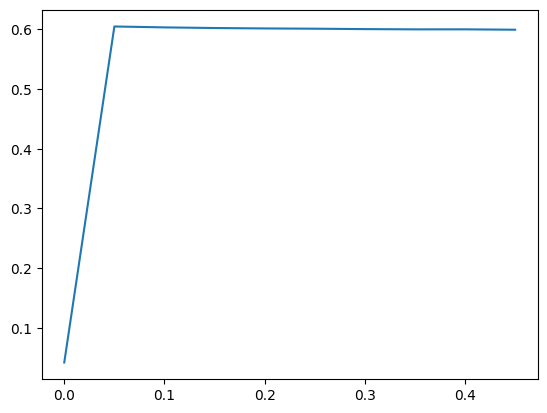

In [46]:
print("Best Threshold: ",thresholds[np.argmax(f1Values)])
plt.plot(thresholds, f1Values)

### Find GOs with highest tp, tn and tp rate

GO:0006807 :  14
GO:0006810 :  12
GO:0007275 :  15
GO:0008152 :  15
GO:0009889 :  10
GO:0009987 :  17
GO:0010468 :  9
GO:0010556 :  9
GO:0016043 :  15
GO:0019219 :  10
GO:0019222 :  12
GO:0019538 :  10
GO:0031323 :  11
GO:0031326 :  9
GO:0032501 :  16
GO:0032502 :  17
GO:0034641 :  13
GO:0043170 :  12
GO:0044237 :  14
GO:0044238 :  13
GO:0048518 :  12
GO:0048522 :  11
GO:0048856 :  16
GO:0050789 :  15
GO:0050794 :  14
GO:0050896 :  16
GO:0051171 :  11
GO:0051179 :  14
GO:0051234 :  13
GO:0051716 :  11
GO:0060255 :  10
GO:0065007 :  16
GO:0071704 :  14
GO:0071840 :  16
GO:0080090 :  11
GO:1901564 :  11


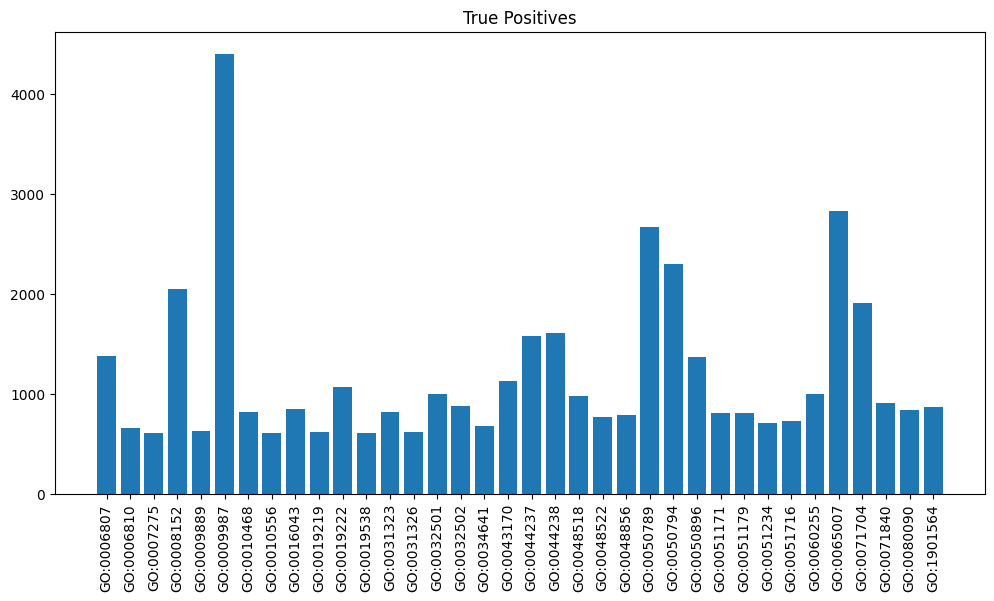

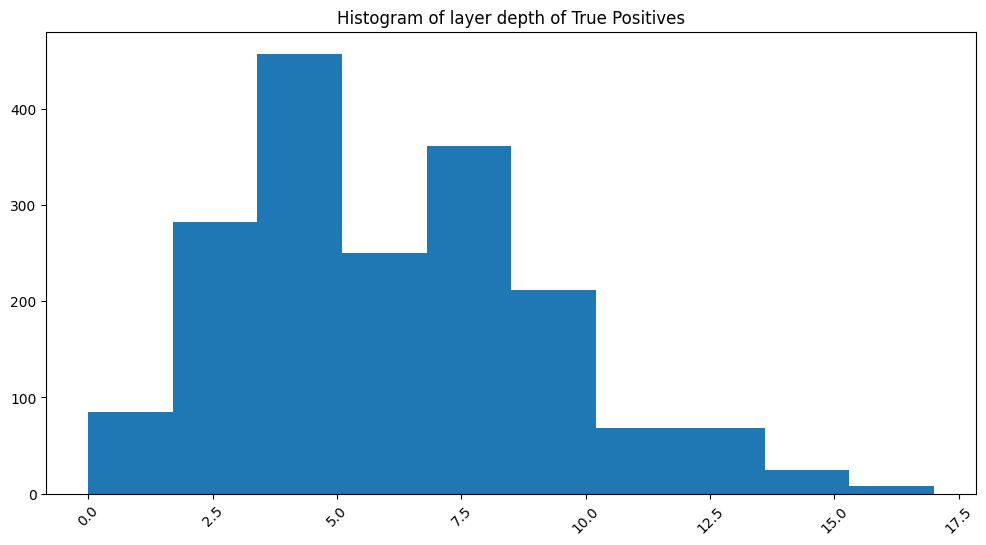

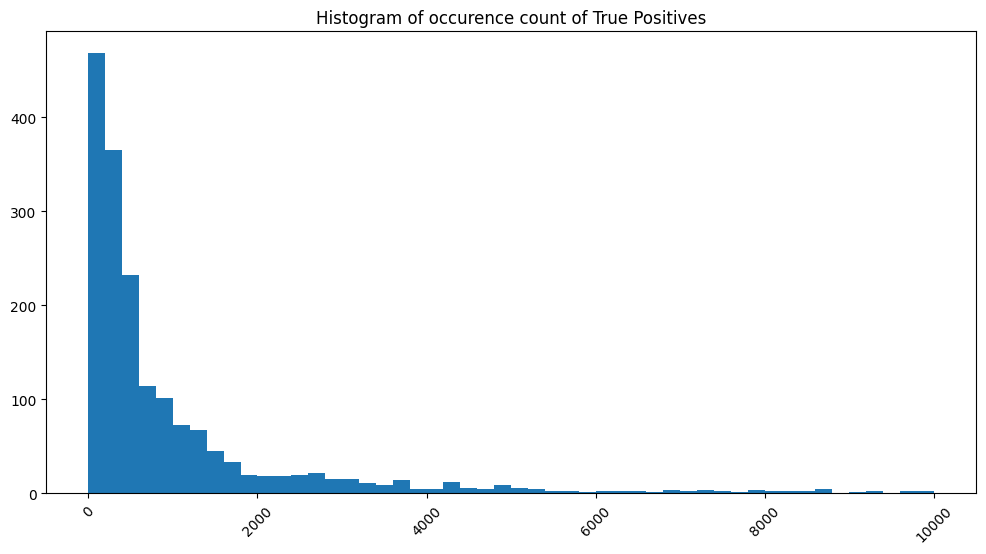

In [166]:
for n in tpValues[tpCounts>600]:
    try:
        print(n, ": ", layerGOs[n])
    except:
        print("failed for ", n)
    
plt.figure(figsize=(12,6))
plt.bar(tpValues[tpCounts>600], tpCounts[tpCounts>600])
plt.xticks(rotation=90)
plt.title("True Positives")
plt.show()

plt.figure(figsize=(12,6))
plt.hist([layerGOs[tpVal] for tpVal in tpValues])
plt.xticks(rotation=45)
plt.title("Histogram of layer depth of True Positives")
plt.show()

plt.figure(figsize=(12,6))
plt.hist([occurenceDict[tpVal] for tpVal in tpValues], bins=50, range=(0,10000))
plt.xticks(rotation=45)
plt.title("Histogram of occurence count of True Positives")
plt.show()


GO:0006355 :  6
GO:0006807 :  14
GO:0006810 :  12
GO:0006950 :  14
GO:0006996 :  14
GO:0007154 :  12
GO:0007165 :  10
GO:0007275 :  15
GO:0008152 :  15
GO:0009056 :  12
GO:0009605 :  15
GO:0009653 :  13
GO:0009889 :  10
GO:0009893 :  11
GO:0009966 :  7
GO:0009987 :  17
GO:0010033 :  9
GO:0010468 :  9
GO:0010556 :  9
GO:0010604 :  9
GO:0010646 :  8
GO:0016043 :  15
GO:0019219 :  10
GO:0019222 :  12
GO:0019538 :  10
GO:0023051 :  8
GO:0023052 :  12
GO:0030154 :  14
GO:0031323 :  11
GO:0031325 :  10
GO:0031326 :  9
GO:0032501 :  16
GO:0032502 :  17
GO:0034641 :  13
GO:0042221 :  11
GO:0043170 :  12
GO:0044085 :  10
GO:0044237 :  14
GO:0044238 :  13
GO:0048513 :  12
GO:0048518 :  12
GO:0048519 :  13
GO:0048522 :  11
GO:0048523 :  12
GO:0048583 :  13
GO:0048731 :  14
GO:0048856 :  16
GO:0048869 :  15
GO:0050789 :  15
GO:0050794 :  14
GO:0050896 :  16
GO:0051128 :  13
GO:0051171 :  11
GO:0051173 :  10
GO:0051179 :  14
GO:0051234 :  13
GO:0051239 :  11
GO:0051252 :  9
GO:0051716 :  11
GO:0060

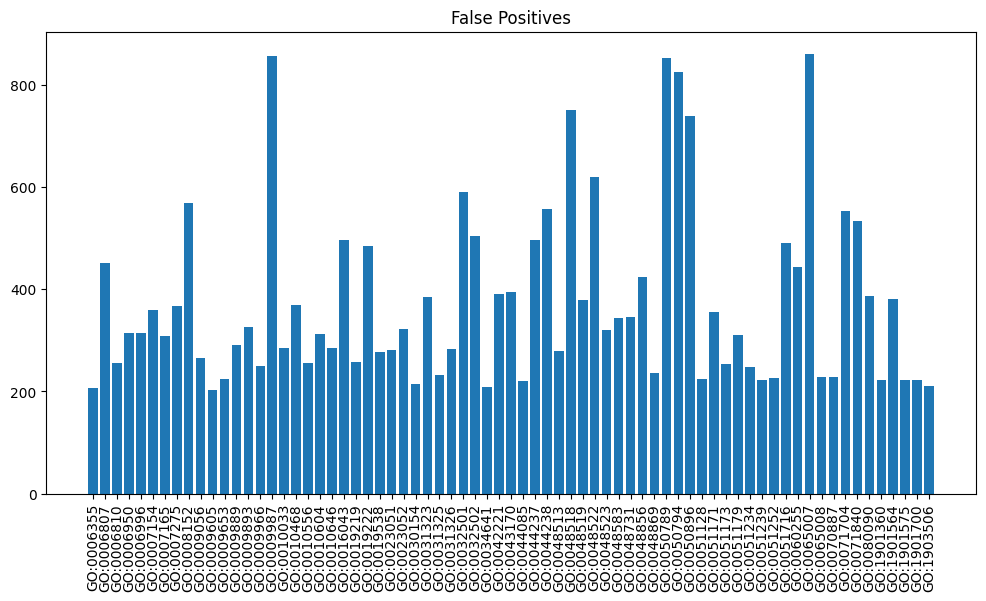

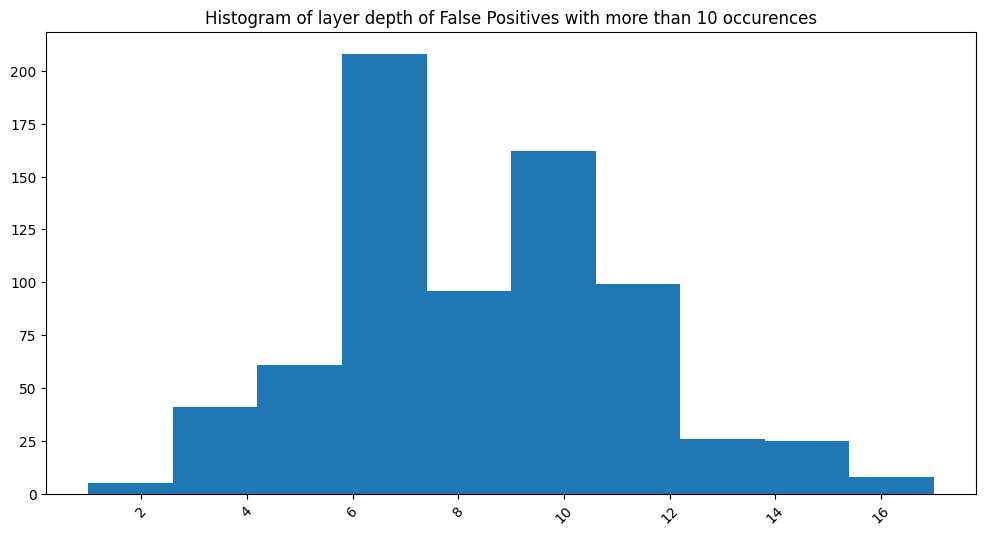

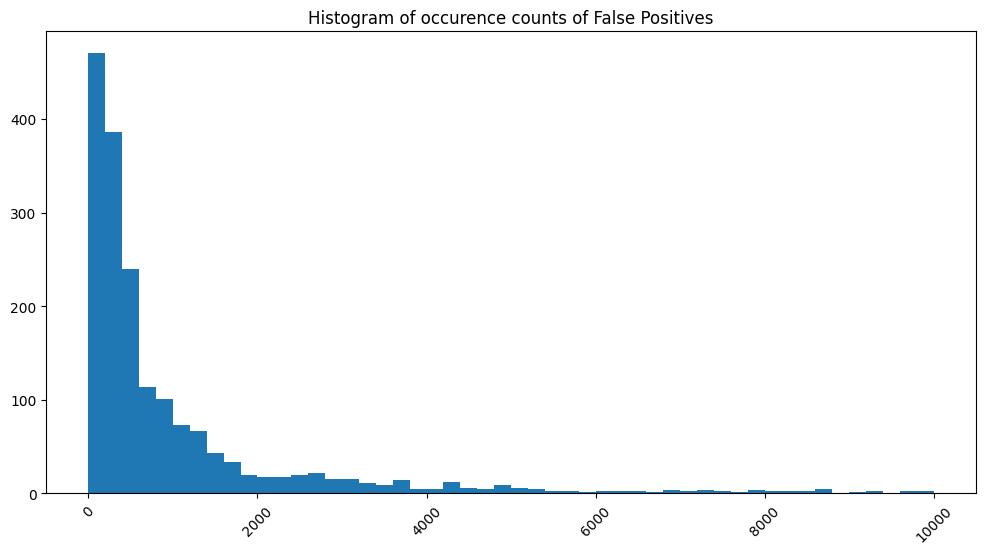

In [167]:
for n in fpValues[fpCounts > 200]:
    print(n, ": ", layerGOs[n])

plt.figure(figsize=(12, 6))
plt.bar(fpValues[fpCounts > 200], fpCounts[fpCounts > 200])
plt.xticks(rotation=90)
plt.title("False Positives")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist([layerGOs[fpVal] for fpVal in fpValues[fpCounts > 10]])
plt.xticks(rotation=45)
plt.title("Histogram of layer depth of False Positives with more than 10 occurences")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist([occurenceDict[fpVal] for fpVal in fpValues], bins=50, range=(0,10000))
plt.xticks(rotation=45)
plt.title(
    "Histogram of occurence counts of False Positives"
)
plt.show()

GO:0000003 :  16
GO:0000902 :  9
GO:0002376 :  13
GO:0002682 :  12
GO:0003006 :  13
GO:0003008 :  12
GO:0006139 :  12
GO:0006355 :  6
GO:0006357 :  5
GO:0006725 :  13
GO:0006793 :  12
GO:0006796 :  11
GO:0006807 :  14
GO:0006810 :  12
GO:0006950 :  14
GO:0006952 :  13
GO:0006996 :  14
GO:0007010 :  10
GO:0007049 :  15
GO:0007154 :  12
GO:0007165 :  10
GO:0007166 :  8
GO:0007275 :  15
GO:0007399 :  13
GO:0007417 :  12
GO:0008104 :  9
GO:0008152 :  15
GO:0009056 :  12
GO:0009058 :  13
GO:0009059 :  10
GO:0009605 :  15
GO:0009607 :  15
GO:0009628 :  9
GO:0009653 :  13
GO:0009719 :  9
GO:0009725 :  8
GO:0009790 :  12
GO:0009887 :  11
GO:0009888 :  13
GO:0009889 :  10
GO:0009890 :  8
GO:0009891 :  9
GO:0009892 :  10
GO:0009893 :  11
GO:0009966 :  7
GO:0009967 :  5
GO:0009968 :  5
GO:0009987 :  17
GO:0010033 :  9
GO:0010243 :  8
GO:0010467 :  10
GO:0010468 :  9
GO:0010556 :  9
GO:0010557 :  8
GO:0010558 :  7
GO:0010604 :  9
GO:0010605 :  9
GO:0010628 :  5
GO:0010629 :  8
GO:0010646 :  8
GO:0

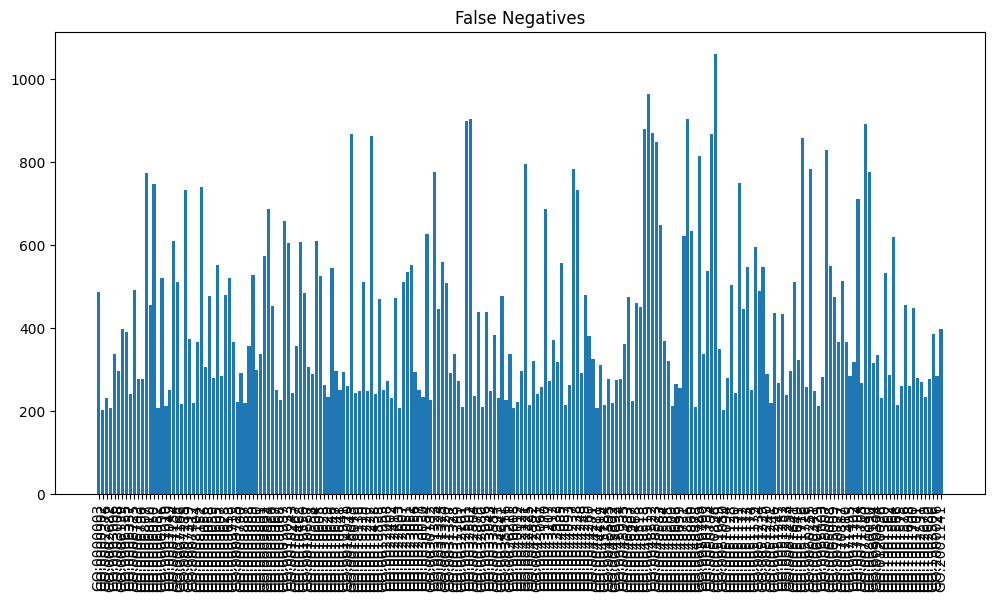

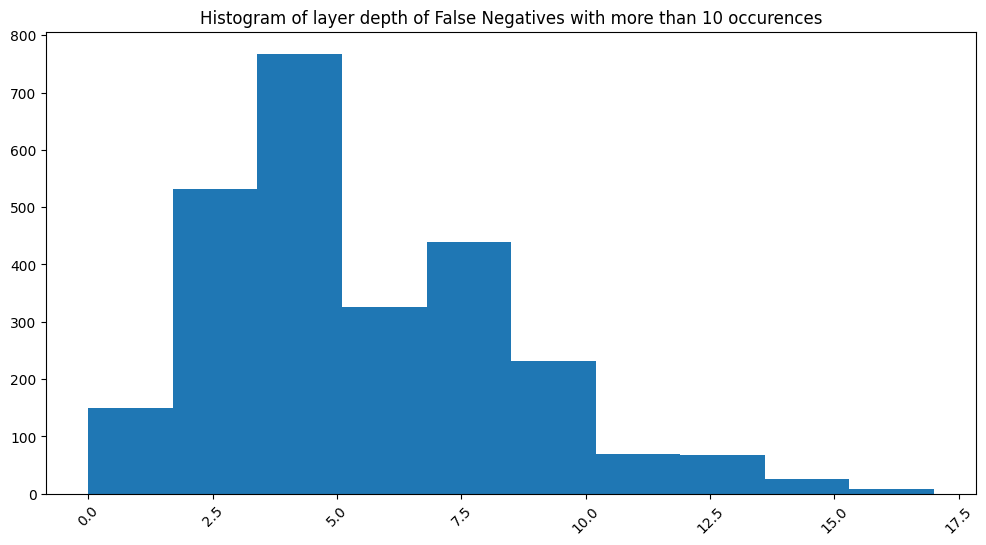

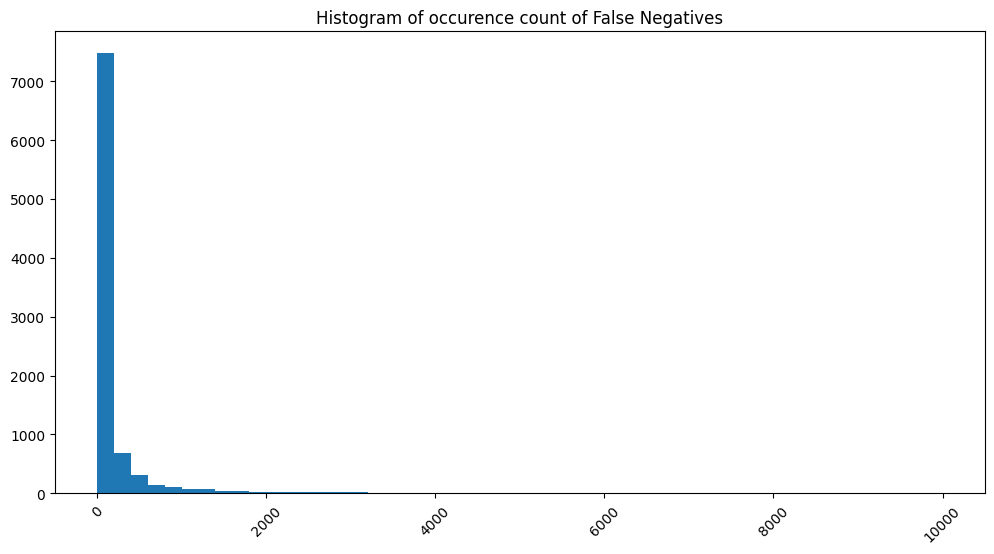

In [168]:
for n in fnValues[fnCounts>200]:
    print(n, ": ", layerGOs[n])
    
plt.figure(figsize=(12,6))
plt.bar(fnValues[fnCounts>200], fnCounts[fnCounts>200])
plt.xticks(rotation=90)
plt.title("False Negatives")
plt.show()

plt.figure(figsize=(12,6))
plt.hist([layerGOs[fnVal] for fnVal in fnValues[fnCounts>10] ])
plt.xticks(rotation=45)
plt.title("Histogram of layer depth of False Negatives with more than 10 occurences")
plt.show()

plt.figure(figsize=(12,6))
plt.hist([occurenceDict[fnVal] for fnVal in fnValues], bins=50, range=(0,10000))
plt.xticks(rotation=45)
plt.title("Histogram of occurence count of False Negatives")
plt.show()


- The GO terms that are true positives most of the time are from different layers in the GO graph. There is no tendency that the model is better at classifying GOs at a higher layer, i.e. are more general.
- The GO terms that are true positive have different frequencies in the dataset. But there is a tendency that true positives are the less common GOs, which is not an expected behavior.
- The GO terms that are false positives or false negatives show a clear tendency to occur in a lower layer of the GO graph (which is more specific). But there are also some errors in the higher layers.
- The GO terms that are false positives or false negatives show a clear tendency to occur in the classes that are less common in the dataset. So this is an indicator that class imbalance is a problem here.